**This notebook is the annotated version of the original [notebook](https://www.kaggle.com/code/radek1/co-visitation-matrix-simplified-imprvd-logic) by @radek1**

This notebook builds on [the work](https://www.kaggle.com/code/vslaykovsky/co-visitation-matrix) by [@vslaykovsky](https://www.kaggle.com/vslaykovsky). As suggested by [@cdeotte](https://www.kaggle.com/cdeotte) [here](https://www.kaggle.com/code/cdeotte/test-data-leak-lb-boost) I am including test information in clculating the co-visitation matrix.

Here I provide a simplified implementation that is easier to follow and that can also be more easily extended!

Please find some additional discussion on this notebook in this [thread](https://www.kaggle.com/competitions/otto-recommender-system/discussion/364210).

**Would appreciate [your upvote on the thread](https://www.kaggle.com/competitions/otto-recommender-system/discussion/364210) to increase visibility.** 🙏

Because the code is simpler, it was straightforward to modify the logic and make a couple of different decisions to achieve a better result.

Additionally, I am also using a version of the dataset that I shared [here](https://www.kaggle.com/competitions/otto-recommender-system/discussion/363843). This further simplifies matters as we no longer have to read the data from `jasonl` files!

**If you like this notebook, please upvote! Thank you! 😊**

## You might also find useful:

* [💡 Do not disregard longer sessions -- they contribute disproportionately to the competition metric!](https://www.kaggle.com/competitions/otto-recommender-system/discussion/364375)
* [🐘 the elephant in the room -- high cardinality of targets and what to do about this](https://www.kaggle.com/competitions/otto-recommender-system/discussion/364722)
* [📅 Dataset for local validation created using organizer's repository (parquet files)](https://www.kaggle.com/competitions/otto-recommender-system/discussion/364534)


### Update:

* added sorting of `AIDs` in test based on number of clicks from [Multiple clicks vs latest items](https://www.kaggle.com/code/pietromaldini1/multiple-clicks-vs-latest-items) by [pietromaldini1](https://www.kaggle.com/pietromaldini1)
* added speed improvements from [Fast Co-Visitation Matrix](https://www.kaggle.com/code/pietromaldini1/multiple-clicks-vs-latest-items) by [dpalbrecht](https://www.kaggle.com/dpalbrecht)
* added weigting by type of `AIDs` in test from [Item type vs multiple clicks vs latest items](https://www.kaggle.com/code/ingvarasgalinskas/item-type-vs-multiple-clicks-vs-latest-items) by [ingvarasgalinskas](https://www.kaggle.com/ingvarasgalinskas)

## imports

In [ ]:
# make sure fastkaggle is install and imported
import os

try: import fastkaggle
except ModuleNotFoundError:
    os.system("pip install -Uq fastkaggle")

from fastkaggle import *

# use fastdebug.utils 
if iskaggle: os.system("pip install nbdev snoop")

if iskaggle:
    path = "../input/fastdebugutils0"
    import sys
    sys.path
    sys.path.insert(1, path)
    import utils as fu
    from utils import *
else: 
    from fastdebug.utils import *
    import fastdebug.utils as fu

0

['/kaggle/working',
 '../input/fastdebugutils0',
 '../input/fastdebugutils0',
 '/kaggle/lib/kagglegym',
 '/kaggle/lib',
 '/kaggle/input/otto-recommender-system',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/root/.local/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages',
 '/src/bq-helper',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
import pandas as pd
import numpy as np

## rd: recsys - otto - covisitation_simplified - load the dataset files and have a peek at them

### rd: recsys - otto - covisitation_simplified - read parquet and csv from dataset, pd.read_parquet('copy & paste the file path'), pd.read_csv('copy & paste path')

In [ ]:
train = pd.read_parquet('../input/otto-full-optimized-memory-footprint//train.parquet')
test = pd.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet')

sample_sub = pd.read_csv('../input/otto-recommender-system//sample_submission.csv')

In [ ]:
train.head()

,session,aid,ts,type
0,0,1517085,1659304800,0
1,0,1563459,1659304904,0
2,0,1309446,1659367439,0
3,0,16246,1659367719,0
4,0,1781822,1659367871,0


In [ ]:
test.head()

,session,aid,ts,type
0,12899779,59625,1661724000,0
1,12899780,1142000,1661724000,0
2,12899780,582732,1661724058,0
3,12899780,973453,1661724109,0
4,12899780,736515,1661724136,0


In [ ]:
sample_sub.head()

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524


## rd: recsys - otto - covisitation_simplified - taking subset for fast experiment

### rd: recsys - otto - covisitation_simplified - subset based on entire sessions, train.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use, random_state=42)['session'], train[train.session.isin(lucky_sessions_train)]

In [ ]:
fraction_of_sessions_to_use = 0.000001 # 0.001 is recommended, but 0.000001 can finish in less than 4 minutes

In [ ]:
train.shape # how many rows

(216716096, 4)

In [ ]:
train.drop_duplicates(['session']).shape # how many unique sessions (drop rows with the same session)

(12899779, 4)

In [ ]:
subset_of_train_no_duplicate = train.sample(frac=fraction_of_sessions_to_use, random_state=42)['session']
subset_of_train_no_duplicate.shape # take 0.000001 from entire train

(217,)

In [ ]:
lucky_sessions_train = train.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use, random_state=42)['session']
lucky_sessions_train.shape # take 0.000001 from a dataframe in which each row is an unique session

(13,)

In [ ]:
lucky_sessions_train.head()
lucky_sessions_train.reset_index(drop=True).head() # make index easier to see

161074658    7345999
136385904    5537326
165592490    7723696
134046856    5390256
136142264    5521908
Name: session, dtype: int32

0    7345999
1    5537326
2    7723696
3    5390256
4    5521908
Name: session, dtype: int32

In [ ]:
train.session.isin(lucky_sessions_train).sum() # how many rows under the 13 sessions

116

In [ ]:
if fraction_of_sessions_to_use != 1:
    lucky_sessions_train = train.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use, random_state=42)['session']
    subset_of_train = train[train.session.isin(lucky_sessions_train)]
    
    lucky_sessions_test = test.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use, random_state=42)['session']
    subset_of_test = test[test.session.isin(lucky_sessions_test)]
else:
    subset_of_train = train
    subset_of_test = test

In [ ]:
subset_of_train.shape

(116, 4)

In [ ]:
subset_of_train

,session,aid,ts,type
47752837,1252181,1150072,1659396245,0
47752838,1252181,1053941,1659839377,0
47752839,1252181,1412178,1659839582,0
47752840,1252181,1412178,1659839601,1
47752841,1252181,567959,1659839627,0
...,...,...,...,...
209483943,12014664,635761,1661429463,0
209483944,12014664,635761,1661429657,1
209483945,12014664,635761,1661429811,1
209483946,12014664,1765902,1661429871,0


## rd: recsys - otto - covisitation_simplified - some setups before training

### rd: recsys - otto - covisitation_simplified - use session column as index, subset_of_train.index = pd.MultiIndex.from_frame(subset_of_train[['session']]), [['session']] as Series not DataFrame

In [ ]:
# see the difference between 
subset_of_train[['session']], subset_of_train['session']

(            session
 47752837    1252181
 47752838    1252181
 47752839    1252181
 47752840    1252181
 47752841    1252181
 ...             ...
 209483943  12014664
 209483944  12014664
 209483945  12014664
 209483946  12014664
 209483947  12014664
 
 [116 rows x 1 columns],
 47752837      1252181
 47752838      1252181
 47752839      1252181
 47752840      1252181
 47752841      1252181
                ...   
 209483943    12014664
 209483944    12014664
 209483945    12014664
 209483946    12014664
 209483947    12014664
 Name: session, Length: 116, dtype: int32)

In [ ]:
subset_of_train.index = pd.MultiIndex.from_frame(subset_of_train[['session']])
subset_of_train

,session,aid,ts,type
session,,,,
1252181,1252181,1150072,1659396245,0
1252181,1252181,1053941,1659839377,0
1252181,1252181,1412178,1659839582,0
1252181,1252181,1412178,1659839601,1
1252181,1252181,567959,1659839627,0
...,...,...,...,...
12014664,12014664,635761,1661429463,0
12014664,12014664,635761,1661429657,1
12014664,12014664,635761,1661429811,1


In [ ]:
subset_of_test.index = pd.MultiIndex.from_frame(subset_of_test[['session']])
subset_of_test

,session,aid,ts,type
session,,,,
13993132,13993132,1096609,1662115398,0
14088154,14088154,14170,1662144895,0


### rd: recsys - otto - covisitation_simplified - get starting and end timestamp for all sessions from start of training set to end of test set, train.ts.min() test.ts.max()

In [ ]:
min_ts = train.ts.min()
max_ts = test.ts.max()

min_ts, max_ts

(1659304800, 1662328791)

### rd: recsys - otto - covisitation_simplified - use defaultdict + Counter to count occurences, next_AIDs = defaultdict(Counter)

In [ ]:
from collections import defaultdict, Counter
next_AIDs = defaultdict(Counter)
next_AIDs

defaultdict(collections.Counter, {})

### rd: recsys - otto - covisitation_simplified - use test for training, get subsets, sessions, sessions_train, sessions_test - subsets = pd.concat([subset_of_train, subset_of_test]) - sessions = subsets.session.unique()

In [ ]:
subsets = pd.concat([subset_of_train, subset_of_test]) # use test set for training too
sessions = subsets.session.unique() # unique sessions in subsets
sessions_train = subset_of_train.session.unique() # unique sessions in train
sessions_test = subset_of_test.session.unique() # unique sessions in test
len(sessions), len(sessions_train), len(sessions_test)

(15, 13, 2)

In [ ]:
subsets

,session,aid,ts,type
session,,,,
1252181,1252181,1150072,1659396245,0
1252181,1252181,1053941,1659839377,0
1252181,1252181,1412178,1659839582,0
1252181,1252181,1412178,1659839601,1
1252181,1252181,567959,1659839627,0
...,...,...,...,...
12014664,12014664,635761,1661429811,1
12014664,12014664,1765902,1661429871,0
12014664,12014664,635761,1661429890,0


In [ ]:
sessions[:5], sessions[-5:], sessions_train[:5], sessions_test[-5:]

(array([1252181, 4769706, 5390256, 5521908, 5537326], dtype=int32),
 array([10523604, 10556736, 12014664, 13993132, 14088154], dtype=int32),
 array([1252181, 4769706, 5390256, 5521908, 5537326], dtype=int32),
 array([13993132, 14088154], dtype=int32))

## rd: recsys - otto - covisitation_simplified - Training: when one aid occurred, keep track of what other aid occurred, how often they occurred. Do this for every aid across both train and test sessions.

### rd: recsys - otto - covisitation_simplified - loop every chunk_size number unique sessions - for i in range(0, sessions.shape[0], chunk_size): 
### rd: recsys - otto - covisitation_simplified - take a chunk_size number of sessions (each session in its entirety, ie, probably with many rows) from subsets as current_chunk - current_chunk = subsets.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True) 

In [ ]:
chunk_size = 30_000

for i in range(0, sessions.shape[0], chunk_size): # loop every 30_000 unique sessions
    
    #### take a chunk_size number of sessions (each session in its entirety, ie., many rows) from subsets as current_chunk
    
    pp(i, sessions[i], sessions.shape[0]-1, i+chunk_size-1, min(sessions.shape[0]-1, i+chunk_size-1))
    current_chunk = subsets.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True) # to remove index column
    pp(current_chunk.head(), current_chunk.tail())
    break

    #### In current_chunk, from each session (in its entirety) only takes the last/latest 30 events and combine them to update current_chunk
#     pp(range(-30,0), list(range(-30,0)))
    current_chunk = current_chunk.groupby('session', as_index=False).nth(list(range(-30,0))).reset_index(drop=True)
#     pp(current_chunk[:31], current_chunk[30:61])
#     pp(doc_sig(pd.DataFrame.reset_index))
#     pp(doc_sig(current_chunk.groupby('session', as_index=False).nth))

    #### merge an session of its entirety onto itself (help to see the relation between one aid and every other aid within each session)
    consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
#     pp(consecutive_AIDs[:30])
#     pp(consecutive_AIDs[29:61])

    #### remove all the rows which aid_x == aid_y (remove the row when the two articles are the same)
    consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
    
    #### add a column named 'days_elapsed' which shows how many days passed between the two aids in a session
    consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60)
#     pp(consecutive_AIDs[:61])

    #### keep the rows if the two aids of a session are occurred within the same day on the right order
    consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed >= 0) & (consecutive_AIDs.days_elapsed <= 1)]
    
    #### among all sessions or all users, for each article occurred, count how often the other articles are occurred
    for aid_x, aid_y in zip(consecutive_AIDs['aid_x'], consecutive_AIDs['aid_y']):
        next_AIDs[aid_x][aid_y] += 1
    

13:32:49.68 LOG:
13:32:49.69 .... i = 0
13:32:49.69 .... sessions[i] = 1252181
13:32:49.69 .... sessions.shape[0]-1 = 14
13:32:49.69 .... i+chunk_size-1 = 29999
13:32:49.70 .... min(sessions.shape[0]-1, i+chunk_size-1) = 14


(0, 1252181, 14, 29999, 14)

13:32:49.70 LOG:
13:32:49.71 .... current_chunk.head() =    session      aid          ts  type
13:32:49.71                             0  1252181  1150072  1659396245     0
13:32:49.71                             1  1252181  1053941  1659839377     0
13:32:49.71                             2  1252181  1412178  1659839582     0
13:32:49.71                             3  1252181  1412178  1659839601     1
13:32:49.71                             4  1252181   567959  1659839627     0
13:32:49.72 .... current_chunk.tail() =       session      aid          ts  type
13:32:49.72                             113  12014664   635761  1661429811     1
13:32:49.72                             114  12014664  1765902  1661429871     0
13:32:49.72                             115  12014664   635761  1661429890     0
13:32:49.72                             116  13993132  1096609  1662115398     0
13:32:49.72                             117  14088154    14170  1662144895     0


(   session      aid          ts  type
 0  1252181  1150072  1659396245     0
 1  1252181  1053941  1659839377     0
 2  1252181  1412178  1659839582     0
 3  1252181  1412178  1659839601     1
 4  1252181   567959  1659839627     0,
       session      aid          ts  type
 113  12014664   635761  1661429811     1
 114  12014664  1765902  1661429871     0
 115  12014664   635761  1661429890     0
 116  13993132  1096609  1662115398     0
 117  14088154    14170  1662144895     0)

### rd: recsys - otto - covisitation_simplified - In current_chunk, from each session (in its entirety) only takes the last/latest 30 events/rows and combine them to update current_chunk (focus on the latest 30 events to save computations) - current_chunk = current_chunk.groupby('session', as_index=False).nth(list(range(-30,0))).reset_index(drop=True)

In [ ]:
chunk_size = 30_000

for i in range(0, sessions.shape[0], chunk_size): # loop every 30_000 unique sessions
    
    #### take a chunk_size number of sessions (each session in its entirety, ie., many rows) from subsets as current_chunk
    
#     pp(i, sessions[i], sessions.shape[0]-1, i+chunk_size-1, min(sessions.shape[0]-1, i+chunk_size-1))
    current_chunk = subsets.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True) # to remove index column
#     pp(current_chunk.head(), current_chunk.tail())
#     break

    #### In current_chunk, from each session (in its entirety) only takes the last/latest 30 events and combine them to update current_chunk
    pp(range(-30,0), list(range(-30,0)))
    current_chunk = current_chunk.groupby('session', as_index=False).nth(list(range(-30,0))).reset_index(drop=True)
    pp(current_chunk[:31], current_chunk[29:61])
    pp(doc_sig(pd.DataFrame.reset_index))
    pp(doc_sig(current_chunk.groupby('session', as_index=False).nth))
    break

    #### merge an session of its entirety onto itself (help to see the relation between one aid and every other aid within each session)
    consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
#     pp(consecutive_AIDs[:30])
#     pp(consecutive_AIDs[29:61])

    #### remove all the rows which aid_x == aid_y (remove the row when the two articles are the same)
    consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
    
    #### add a column named 'days_elapsed' which shows how many days passed between the two aids in a session
    consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60)
#     pp(consecutive_AIDs[:61])

    #### keep the rows if the two aids of a session are occurred within the same day on the right order
    consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed >= 0) & (consecutive_AIDs.days_elapsed <= 1)]
    
    #### among all sessions or all users, for each article occurred, count how often the other articles are occurred
    for aid_x, aid_y in zip(consecutive_AIDs['aid_x'], consecutive_AIDs['aid_y']):
        next_AIDs[aid_x][aid_y] += 1
    

13:32:49.74 LOG:
13:32:49.76 .... range(-30,0) = range(-30, 0)
13:32:49.76 .... list(range(-30,0)) = [-30,
13:32:49.76                            -29,
13:32:49.76                            -28,
13:32:49.76                            -27,
13:32:49.76                            -26,
13:32:49.76                            -25,
13:32:49.76                            -24,
13:32:49.76                            -23,
13:32:49.76                            -22,
13:32:49.76                            -21,
13:32:49.76                            -20,
13:32:49.76                            -19,
13:32:49.76                            -18,
13:32:49.76                            -17,
13:32:49.76                            -16,
13:32:49.76                            -15,
13:32:49.76                            -14,
13:32:49.76                            -13,
13:32:49.76                            -12,
13:32:49.76                            -11,
13:32:49.76                            -10,
13:32:49.76  

(range(-30, 0),
 [-30,
  -29,
  -28,
  -27,
  -26,
  -25,
  -24,
  -23,
  -22,
  -21,
  -20,
  -19,
  -18,
  -17,
  -16,
  -15,
  -14,
  -13,
  -12,
  -11,
  -10,
  -9,
  -8,
  -7,
  -6,
  -5,
  -4,
  -3,
  -2,
  -1])

13:32:49.77 LOG:
13:32:49.78 .... current_chunk[:31] =     session      aid          ts  type
13:32:49.78                           0   1252181  1150072  1659396245     0
13:32:49.78                           1   1252181  1053941  1659839377     0
13:32:49.78                           2   1252181  1412178  1659839582     0
13:32:49.78                           3   1252181  1412178  1659839601     1
13:32:49.78                           4   1252181   567959  1659839627     0
13:32:49.78                           5   1252181   567959  1659839652     1
13:32:49.78                           6   1252181  1590011  1659839669     0
13:32:49.78                           7   1252181  1410065  1659839702     0
13:32:49.78                           8   1252181   527209  1659839727     0
13:32:49.78                           9   1252181   118631  1660746871     0
13:32:49.78                           10  1252181  1810463  1660746883     0
13:32:49.78                           11  1252181  1810463 

(    session      aid          ts  type
 0   1252181  1150072  1659396245     0
 1   1252181  1053941  1659839377     0
 2   1252181  1412178  1659839582     0
 3   1252181  1412178  1659839601     1
 4   1252181   567959  1659839627     0
 5   1252181   567959  1659839652     1
 6   1252181  1590011  1659839669     0
 7   1252181  1410065  1659839702     0
 8   1252181   527209  1659839727     0
 9   1252181   118631  1660746871     0
 10  1252181  1810463  1660746883     0
 11  1252181  1810463  1660746896     1
 12  1252181   809254  1660841728     0
 13  1252181   252823  1660841753     1
 14  1252181   809254  1660841762     1
 15  1252181   755752  1660841916     0
 16  1252181   473784  1660841955     0
 17  1252181  1043532  1660884796     0
 18  1252181   424449  1660884938     0
 19  1252181  1084504  1661677104     0
 20  1252181  1043532  1661677227     0
 21  1252181    30388  1661677294     0
 22  1252181  1001867  1661677339     0
 23  1252181   473301  1661677465     0


13:32:49.80 LOG:
13:32:49.81 .... doc_sig(pd.DataFrame.reset_index) = ('no mro',
13:32:49.81                                           'Reset the index, or a level of it.\n'
13:32:49.81                                           '\n'
13:32:49.81                                           'Reset the index of the DataFrame, and use the default one instead.\n'
13:32:49.81                                           'If the DataFrame has a MultiIndex, this method can remove one or more\n'
13:32:49.81                                           'levels.\n'
13:32:49.81                                           '\n'
13:32:49.81                                           'Parameters\n'
13:32:49.81                                           '----------\n'
13:32:49.81                                           'level : int, str, tuple, or list, default None\n'
13:32:49.81                                           '    Only remove the given levels from the index. Removes all levels by\n'
13:32:49.81      

('no mro',
 "Reset the index, or a level of it.\n\nReset the index of the DataFrame, and use the default one instead.\nIf the DataFrame has a MultiIndex, this method can remove one or more\nlevels.\n\nParameters\n----------\nlevel : int, str, tuple, or list, default None\n    Only remove the given levels from the index. Removes all levels by\n    default.\ndrop : bool, default False\n    Do not try to insert index into dataframe columns. This resets\n    the index to the default integer index.\ninplace : bool, default False\n    Modify the DataFrame in place (do not create a new object).\ncol_level : int or str, default 0\n    If the columns have multiple levels, determines which level the\n    labels are inserted into. By default it is inserted into the first\n    level.\ncol_fill : object, default ''\n    If the columns have multiple levels, determines how the other\n    levels are named. If None then the index name is repeated.\n\nReturns\n-------\nDataFrame or None\n    DataFrame w

13:32:49.82 LOG:
13:32:49.83 .... doc_sig(current_chunk.groupby('session', as_index=False).nth) = ('no mro',
13:32:49.83                                                                       'Take the nth row from each group if n is an int, or a subset of rows\n'
13:32:49.83                                                                       'if n is a list of ints.\n'
13:32:49.83                                                                       '\n'
13:32:49.83                                                                       'If dropna, will take the nth non-null row, dropna is either\n'
13:32:49.83                                                                       "'all' or 'any'; this is equivalent to calling dropna(how=dropna)\n"
13:32:49.83                                                                       'before the groupby.\n'
13:32:49.83                                                                       '\n'
13:32:49.83                                      

('no mro',
 "Take the nth row from each group if n is an int, or a subset of rows\nif n is a list of ints.\n\nIf dropna, will take the nth non-null row, dropna is either\n'all' or 'any'; this is equivalent to calling dropna(how=dropna)\nbefore the groupby.\n\nParameters\n----------\nn : int or list of ints\n    A single nth value for the row or a list of nth values.\ndropna : {'any', 'all', None}, default None\n    Apply the specified dropna operation before counting which row is\n    the nth row.\n\nReturns\n-------\nSeries or DataFrame\n    N-th value within each group.\n\nSee Also\n--------\nSeries.groupby : Apply a function groupby to a Series.\nDataFrame.groupby : Apply a function groupby\n    to each row or column of a DataFrame.\n\nExamples\n--------\n\n>>> df = pd.DataFrame({'A': [1, 1, 2, 1, 2],\n...                    'B': [np.nan, 2, 3, 4, 5]}, columns=['A', 'B'])\n>>> g = df.groupby('A')\n>>> g.nth(0)\n     B\nA\n1  NaN\n2  3.0\n>>> g.nth(1)\n     B\nA\n1  2.0\n2  5.0\n>>> 

### rd: recsys - otto - covisitation_simplified - merge an session of its entirety onto itself (help to see the relation between one aid and every other aid within each session) - consecutive_AIDs = current_chunk.merge(current_chunk, on='session')

In [ ]:
chunk_size = 30_000

for i in range(0, sessions.shape[0], chunk_size): # loop every 30_000 unique sessions
    
    #### take a chunk_size number of sessions (each session in its entirety, ie., many rows) from subsets as current_chunk
    
#     pp(i, sessions[i], sessions.shape[0]-1, i+chunk_size-1, min(sessions.shape[0]-1, i+chunk_size-1))
    current_chunk = subsets.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True) # to remove index column
#     pp(current_chunk.head(), current_chunk.tail())
#     break

    #### In current_chunk, from each session (in its entirety) only takes the last/latest 30 events and combine them to update current_chunk
#     pp(range(-30,0), list(range(-30,0)))
    current_chunk = current_chunk.groupby('session', as_index=False).nth(list(range(-30,0))).reset_index(drop=True)
#     pp(current_chunk[:31], current_chunk[29:61])
#     pp(doc_sig(pd.DataFrame.reset_index))
#     pp(doc_sig(current_chunk.groupby('session', as_index=False).nth))
#     break

    #### merge an session of its entirety onto itself (help to see the relation between one aid and every other aid within each session)
    consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
    pp(consecutive_AIDs[:30])
    pp(consecutive_AIDs[29:61])
    break

    #### remove all the rows which aid_x == aid_y (remove the row when the two articles are the same)
    consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
    
    #### add a column named 'days_elapsed' which shows how many days passed between the two aids in a session
    consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60)
#     pp(consecutive_AIDs[:61])

    #### keep the rows if the two aids of a session are occurred within the same day on the right order
    consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed >= 0) & (consecutive_AIDs.days_elapsed <= 1)]
    
    #### among all sessions or all users, for each article occurred, count how often the other articles are occurred
    for aid_x, aid_y in zip(consecutive_AIDs['aid_x'], consecutive_AIDs['aid_y']):
        next_AIDs[aid_x][aid_y] += 1
    

13:32:49.86 LOG:
13:32:49.88 .... consecutive_AIDs[:30] =     session    aid_x        ts_x  type_x    aid_y        ts_y  type_y
13:32:49.88                              0   1252181  1150072  1659396245       0  1150072  1659396245       0
13:32:49.88                              1   1252181  1150072  1659396245       0  1053941  1659839377       0
13:32:49.88                              2   1252181  1150072  1659396245       0  1412178  1659839582       0
13:32:49.88                              3   1252181  1150072  1659396245       0  1412178  1659839601       1
13:32:49.88                              4   1252181  1150072  1659396245       0   567959  1659839627       0
13:32:49.88                              5   1252181  1150072  1659396245       0   567959  1659839652       1
13:32:49.88                              6   1252181  1150072  1659396245       0  1590011  1659839669       0
13:32:49.88                              7   1252181  1150072  1659396245       0  1410065  165

,session,aid_x,ts_x,type_x,aid_y,ts_y,type_y
0,1252181,1150072,1659396245,0,1150072,1659396245,0
1,1252181,1150072,1659396245,0,1053941,1659839377,0
2,1252181,1150072,1659396245,0,1412178,1659839582,0
3,1252181,1150072,1659396245,0,1412178,1659839601,1
4,1252181,1150072,1659396245,0,567959,1659839627,0
5,1252181,1150072,1659396245,0,567959,1659839652,1
6,1252181,1150072,1659396245,0,1590011,1659839669,0
7,1252181,1150072,1659396245,0,1410065,1659839702,0
8,1252181,1150072,1659396245,0,527209,1659839727,0
9,1252181,1150072,1659396245,0,118631,1660746871,0


13:32:49.89 LOG:
13:32:49.90 .... consecutive_AIDs[29:61] =     session    aid_x        ts_x  type_x    aid_y        ts_y  type_y
13:32:49.90                                29  1252181  1053941  1659839377       0   567959  1659839652       1
13:32:49.90                                30  1252181  1053941  1659839377       0  1590011  1659839669       0
13:32:49.90                                31  1252181  1053941  1659839377       0  1410065  1659839702       0
13:32:49.90                                32  1252181  1053941  1659839377       0   527209  1659839727       0
13:32:49.90                                33  1252181  1053941  1659839377       0   118631  1660746871       0
13:32:49.90                                34  1252181  1053941  1659839377       0  1810463  1660746883       0
13:32:49.90                                35  1252181  1053941  1659839377       0  1810463  1660746896       1
13:32:49.90                                36  1252181  1053941  1659839377    

,session,aid_x,ts_x,type_x,aid_y,ts_y,type_y
29,1252181,1053941,1659839377,0,567959,1659839652,1
30,1252181,1053941,1659839377,0,1590011,1659839669,0
31,1252181,1053941,1659839377,0,1410065,1659839702,0
32,1252181,1053941,1659839377,0,527209,1659839727,0
33,1252181,1053941,1659839377,0,118631,1660746871,0
34,1252181,1053941,1659839377,0,1810463,1660746883,0
35,1252181,1053941,1659839377,0,1810463,1660746896,1
36,1252181,1053941,1659839377,0,809254,1660841728,0
37,1252181,1053941,1659839377,0,252823,1660841753,1
38,1252181,1053941,1659839377,0,809254,1660841762,1


### rd: recsys - otto - covisitation_simplified - remove all the rows which aid_x == aid_y (remove the row when the two articles are the same) as they are meaningless - consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]

### rd: recsys - otto - covisitation_simplified - add a column named 'days_elapsed' which shows how many days passed between the two aids in a session - consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60)

### rd: recsys - otto - covisitation_simplified - keep the rows if the two aids of a session are occurred within the same day on the right order (one after the other) -     consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed >= 0) & (consecutive_AIDs.days_elapsed <= 1)]

In [ ]:
chunk_size = 30_000

for i in range(0, sessions.shape[0], chunk_size): # loop every 30_000 unique sessions
    
    #### take a chunk_size number of sessions (each session in its entirety, ie., many rows) from subsets as current_chunk
    
#     pp(i, sessions[i], sessions.shape[0]-1, i+chunk_size-1, min(sessions.shape[0]-1, i+chunk_size-1))
    current_chunk = subsets.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True) # to remove index column
#     pp(current_chunk.head(), current_chunk.tail())
#     break

    #### In current_chunk, from each session (in its entirety) only takes the last/latest 30 events and combine them to update current_chunk
#     pp(range(-30,0), list(range(-30,0)))
    current_chunk = current_chunk.groupby('session', as_index=False).nth(list(range(-30,0))).reset_index(drop=True)
#     pp(current_chunk[:31], current_chunk[29:61])
#     pp(doc_sig(pd.DataFrame.reset_index))
#     pp(doc_sig(current_chunk.groupby('session', as_index=False).nth))
#     break

    #### merge an session of its entirety onto itself (help to see the relation between one aid and every other aid within each session)
    consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
#     pp(consecutive_AIDs[:30])
#     pp(consecutive_AIDs[29:61])
#     break

    #### remove all the rows which aid_x == aid_y (remove the row when the two articles are the same)
    consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
    
    #### add a column named 'days_elapsed' which shows how many days passed between the two aids in a session
    consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60)
    pp(consecutive_AIDs[:20])

    #### keep the rows if the two aids of a session are occurred within the same day on the right order
    consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed >= 0) & (consecutive_AIDs.days_elapsed <= 1)]
    pp(consecutive_AIDs[:20])
    break
    
    #### among all sessions or all users, for each article occurred, count how often the other articles are occurred
    for aid_x, aid_y in zip(consecutive_AIDs['aid_x'], consecutive_AIDs['aid_y']):
        next_AIDs[aid_x][aid_y] += 1
    

13:32:49.94 LOG:
13:32:49.95 .... consecutive_AIDs[:20] =     session    aid_x        ts_x  type_x    aid_y        ts_y  type_y  \
13:32:49.95                              1   1252181  1150072  1659396245       0  1053941  1659839377       0   
13:32:49.95                              2   1252181  1150072  1659396245       0  1412178  1659839582       0   
13:32:49.95                              3   1252181  1150072  1659396245       0  1412178  1659839601       1   
13:32:49.95                              4   1252181  1150072  1659396245       0   567959  1659839627       0   
13:32:49.95                              5   1252181  1150072  1659396245       0   567959  1659839652       1   
13:32:49.95                              6   1252181  1150072  1659396245       0  1590011  1659839669       0   
13:32:49.95                              7   1252181  1150072  1659396245       0  1410065  1659839702       0   
13:32:49.95                              8   1252181  1150072  16593962

,session,aid_x,ts_x,type_x,aid_y,ts_y,type_y,days_elapsed
1,1252181,1150072,1659396245,0,1053941,1659839377,0,5.128843
2,1252181,1150072,1659396245,0,1412178,1659839582,0,5.131215
3,1252181,1150072,1659396245,0,1412178,1659839601,1,5.131435
4,1252181,1150072,1659396245,0,567959,1659839627,0,5.131736
5,1252181,1150072,1659396245,0,567959,1659839652,1,5.132025
6,1252181,1150072,1659396245,0,1590011,1659839669,0,5.132222
7,1252181,1150072,1659396245,0,1410065,1659839702,0,5.132604
8,1252181,1150072,1659396245,0,527209,1659839727,0,5.132894
9,1252181,1150072,1659396245,0,118631,1660746871,0,15.632245
10,1252181,1150072,1659396245,0,1810463,1660746883,0,15.632384


13:32:49.97 LOG:
13:32:49.98 .... consecutive_AIDs[:20] =      session    aid_x        ts_x  type_x    aid_y        ts_y  type_y  \
13:32:49.98                              26   1252181  1053941  1659839377       0  1412178  1659839582       0   
13:32:49.98                              27   1252181  1053941  1659839377       0  1412178  1659839601       1   
13:32:49.98                              28   1252181  1053941  1659839377       0   567959  1659839627       0   
13:32:49.98                              29   1252181  1053941  1659839377       0   567959  1659839652       1   
13:32:49.98                              30   1252181  1053941  1659839377       0  1590011  1659839669       0   
13:32:49.98                              31   1252181  1053941  1659839377       0  1410065  1659839702       0   
13:32:49.98                              32   1252181  1053941  1659839377       0   527209  1659839727       0   
13:32:49.98                              52   1252181  1412178 

,session,aid_x,ts_x,type_x,aid_y,ts_y,type_y,days_elapsed
26,1252181,1053941,1659839377,0,1412178,1659839582,0,0.002373
27,1252181,1053941,1659839377,0,1412178,1659839601,1,0.002593
28,1252181,1053941,1659839377,0,567959,1659839627,0,0.002894
29,1252181,1053941,1659839377,0,567959,1659839652,1,0.003183
30,1252181,1053941,1659839377,0,1590011,1659839669,0,0.003380
31,1252181,1053941,1659839377,0,1410065,1659839702,0,0.003762
32,1252181,1053941,1659839377,0,527209,1659839727,0,0.004051
52,1252181,1412178,1659839582,0,567959,1659839627,0,0.000521
53,1252181,1412178,1659839582,0,567959,1659839652,1,0.000810
54,1252181,1412178,1659839582,0,1590011,1659839669,0,0.001007


### rd: recsys - otto - covisitation_simplified - among all sessions/rows selected (regardless which session we are looking at), for each aid occurred, count how often the other aids are occurred -     for aid_x, aid_y in zip(consecutive_AIDs['aid_x'], consecutive_AIDs['aid_y']): next_AIDs[aid_x][aid_y] += 1

In [ ]:
chunk_size = 30_000

for i in range(0, sessions.shape[0], chunk_size): # loop every 30_000 unique sessions
    
    #### take a chunk_size number of sessions (each session in its entirety, ie., many rows) from subsets as current_chunk
    
#     pp(i, sessions[i], sessions.shape[0]-1, i+chunk_size-1, min(sessions.shape[0]-1, i+chunk_size-1))
    current_chunk = subsets.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True) # to remove index column
#     pp(current_chunk.head(), current_chunk.tail())
#     break

    #### In current_chunk, from each session (in its entirety) only takes the last/latest 30 events and combine them to update current_chunk
#     pp(range(-30,0), list(range(-30,0)))
    current_chunk = current_chunk.groupby('session', as_index=False).nth(list(range(-30,0))).reset_index(drop=True)
#     pp(current_chunk[:31], current_chunk[29:61])
#     pp(doc_sig(pd.DataFrame.reset_index))
#     pp(doc_sig(current_chunk.groupby('session', as_index=False).nth))
#     break

    #### merge an session of its entirety onto itself (help to see the relation between one aid and every other aid within each session)
    consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
#     pp(consecutive_AIDs[:30])
#     pp(consecutive_AIDs[29:61])
#     break

    #### remove all the rows which aid_x == aid_y (remove the row when the two articles are the same)
    consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
    
    #### add a column named 'days_elapsed' which shows how many days passed between the two aids in a session
    consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60)
#     pp(consecutive_AIDs[:20])

    #### keep the rows if the two aids of a session are occurred within the same day on the right order
    consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed >= 0) & (consecutive_AIDs.days_elapsed <= 1)]
#     pp(consecutive_AIDs[:20])
#     break
    
    #### among all sessions or all users, for each article occurred, count how often the other articles are occurred
    for aid_x, aid_y in zip(consecutive_AIDs['aid_x'], consecutive_AIDs['aid_y']):
        next_AIDs[aid_x][aid_y] += 1
    pp(next_AIDs)
    break

13:32:50.01 LOG:
13:32:50.02 .... next_AIDs = defaultdict(<class 'collections.Counter'>,
13:32:50.02                              {30388: Counter({1001867: 1, 473301: 1}),
13:32:50.02                               44215: Counter({635761: 4, 1765902: 1}),
13:32:50.02                               64194: Counter({1266300: 2, 215407: 1, 1397797: 1}),
13:32:50.02                               87202: Counter({681053: 2, 137221: 1, 517894: 1}),
13:32:50.02                               118631: Counter({1810463: 2}),
13:32:50.02                               137221: Counter({87202: 3, 517894: 2, 681053: 2}),
13:32:50.02                               140798: Counter({1047179: 6, 1473792: 4}),
13:32:50.02                               150461: Counter({1615007: 2, 945579: 1}),
13:32:50.02                               215407: Counter({1266300: 1, 1397797: 1}),
13:32:50.02                               252823: Counter({809254: 1,
13:32:50.02                                                755752: 

defaultdict(collections.Counter,
            {1053941: Counter({1412178: 2,
                      567959: 2,
                      1590011: 1,
                      1410065: 1,
                      527209: 1}),
             1412178: Counter({567959: 4, 1590011: 2, 1410065: 2, 527209: 2}),
             567959: Counter({1590011: 2, 1410065: 2, 527209: 2}),
             1590011: Counter({1410065: 1, 527209: 1}),
             1410065: Counter({527209: 1}),
             118631: Counter({1810463: 2}),
             809254: Counter({252823: 1,
                      755752: 2,
                      473784: 2,
                      1043532: 2,
                      424449: 2}),
             252823: Counter({809254: 1,
                      755752: 1,
                      473784: 1,
                      1043532: 1,
                      424449: 1}),
             755752: Counter({473784: 1, 1043532: 1, 424449: 1}),
             473784: Counter({1043532: 1, 424449: 1}),
             1043532: Cou

### rd: src - recsys - otto - covisitation_simplified

In [ ]:
chunk_size = 30_000

for i in range(0, sessions.shape[0], chunk_size): # loop every 30_000 unique sessions
    
    #### take a chunk_size number of sessions (each session in its entirety, ie., many rows) from subsets as current_chunk
    
#     pp(i, sessions[i], sessions.shape[0]-1, i+chunk_size-1, min(sessions.shape[0]-1, i+chunk_size-1))
    current_chunk = subsets.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True) # to remove index column
#     pp(current_chunk.head(), current_chunk.tail())
#     break

    #### In current_chunk, from each session (in its entirety) only takes the last/latest 30 events and combine them to update current_chunk
#     pp(range(-30,0), list(range(-30,0)))
    current_chunk = current_chunk.groupby('session', as_index=False).nth(list(range(-30,0))).reset_index(drop=True)
#     pp(current_chunk[:31], current_chunk[29:61])
#     pp(doc_sig(pd.DataFrame.reset_index))
#     pp(doc_sig(current_chunk.groupby('session', as_index=False).nth))
#     break

    #### merge an session of its entirety onto itself (help to see the relation between one aid and every other aid within each session)
    consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
#     pp(consecutive_AIDs[:30])
#     pp(consecutive_AIDs[29:61])
#     break

    #### remove all the rows which aid_x == aid_y (remove the row when the two articles are the same)
    consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
    
    #### add a column named 'days_elapsed' which shows how many days passed between the two aids in a session
    consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60)
#     pp(consecutive_AIDs[:20])

    #### keep the rows if the two aids of a session are occurred within the same day on the right order
    consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed >= 0) & (consecutive_AIDs.days_elapsed <= 1)]
#     pp(consecutive_AIDs[:20])
#     break
    
    #### among all sessions or all users, for each article occurred, count how often the other articles are occurred
    for aid_x, aid_y in zip(consecutive_AIDs['aid_x'], consecutive_AIDs['aid_y']):
        next_AIDs[aid_x][aid_y] += 1
#     pp(next_AIDs)
#     break

### rd: recsys - otto - covisitation_simplified - remove some data objects to save RAM

In [ ]:
del train, subset_of_train, subsets # to save RAM

## rd: recsys - otto - covisitation_simplified - make predictions

### rd: recsys - otto - covisitation_simplified - group the test set by session, under each session, put all aids into a list, and put all action types into another list - test.reset_index(drop=True).groupby('session')['aid'].apply(list)

In [ ]:
test, test.reset_index(drop=True)

(          session      aid          ts  type
 0        12899779    59625  1661724000     0
 1        12899780  1142000  1661724000     0
 2        12899780   582732  1661724058     0
 3        12899780   973453  1661724109     0
 4        12899780   736515  1661724136     0
 ...           ...      ...         ...   ...
 6928118  14571577  1141710  1662328774     0
 6928119  14571578   519105  1662328775     0
 6928120  14571579   739876  1662328775     0
 6928121  14571580   202353  1662328781     0
 6928122  14571581  1100210  1662328791     0
 
 [6928123 rows x 4 columns],
           session      aid          ts  type
 0        12899779    59625  1661724000     0
 1        12899780  1142000  1661724000     0
 2        12899780   582732  1661724058     0
 3        12899780   973453  1661724109     0
 4        12899780   736515  1661724136     0
 ...           ...      ...         ...   ...
 6928118  14571577  1141710  1662328774     0
 6928119  14571578   519105  1662328775     0
 69

In [ ]:
test_session_AIDs = test.reset_index(drop=True).groupby('session')['aid'].apply(list)
test_session_types = test.reset_index(drop=True).groupby('session')['type'].apply(list)

In [ ]:
test_session_AIDs
test_session_types

session
12899779                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               [59625]
12899780                                                                                                                                                                                                                                                                                                                                                                                                         

session
12899779                                                                                                                                                                                                                   [0]
12899780                                                                                                                                                                                                       [0, 0, 0, 0, 0]
12899781                                                                                                                                                                                     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
12899782    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2]
12899783                                                                                            

### rd: recsys - otto - covisitation_simplified - setup, create some containers, such as labels, no_data, no_data_all_aids - type_weight_multipliers = {0: 1, 1: 6, 2: 3} - session_types = ['clicks', 'carts', 'orders']

In [ ]:
labels = []

no_data = 0
no_data_all_aids = 0
type_weight_multipliers = {0: 1, 1: 6, 2: 3}
session_types = ['clicks', 'carts', 'orders']

### rd: recsys - otto - covisitation_simplified - loop every session, access all of its aids and types - for AIDs, types in zip(test_session_AIDs, test_session_types):
### rd: recsys - otto - covisitation_simplified - when there are >= 20 aids in a session: 
### rd: recsys - otto - covisitation_simplified - assign logspaced weight to each aid under each session, as the latter aids should have higher weight/probability to occur than the earlier aids. - if len(AIDs) >= 20: - weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1

In [ ]:
labels = []

no_data = 0
no_data_all_aids = 0
type_weight_multipliers = {0: 1, 1: 6, 2: 3}
session_types = ['clicks', 'carts', 'orders']
idx = 0
for AIDs, types in zip(test_session_AIDs, test_session_types): #### for each session, get all of its aids and types
    if len(AIDs) >= 20:
        #### assign logspaced weight to each arcticle id under each session
        pp(AIDs, len(AIDs), np.logspace(0.1,1,len(AIDs),base=2, endpoint=True), np.logspace(0.1,1,len(AIDs),base=2, endpoint=False))
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
        pp(weights)
        pp(doc_sig(np.logspace))
        break

        #### create a defaultdict to store weight for each id article under a session
        aids_temp=defaultdict(lambda: 0)
    
        #### loop each article id, its weight and its type from all aids, their weights, and types
#         pp(AIDs) # there are repeated aids
        for aid,w,t in zip(AIDs,weights,types): 
        
            #### Within each session, accumulate the weight for each aid based on its occurences, 
            #### event_type and logspaced weight; save the accumulated weight for each aid into a defaultdict, 
            #### no duplicated aid here in this dict
            aids_temp[aid] += w * type_weight_multipliers[t]
            
        #### sort a defaultdict from largest value to smallest, and then put its keys into a list
#         pp(aids_temp.items())
#         pp(sorted(aids_temp.items(), key=lambda item: -item[1]))
#         pp(sorted(aids_temp.items(), key=lambda item: item[1])) 
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
#         pp(aids_temp, sorted_aids)
#         break

        #### store the first 20 aids into the list 'labels'
        labels.append(sorted_aids[:20])
        
    else:
        
        #### reverse the order of AIDs, remove the duplicated, put into a list, reassign it to AIDs
#         if len(AIDs) > 10:
#             pp(AIDs, AIDs[::-1], dict.fromkeys(AIDs[::-1]), list(dict.fromkeys(AIDs[::-1])), doc_sig(dict.fromkeys))
# https://stackoverflow.com/questions/31633635/what-is-the-meaning-of-inta-1-in-python [::-1] means reverse order
#             pp(AIDs, list(dict.fromkeys(AIDs[::-1])), list(dict.fromkeys(AIDs[::1])), list(dict.fromkeys(AIDs)))
#             break
        AIDs = list(dict.fromkeys(AIDs[::-1]))
    
        #### keep track the length of AIDs
        AIDs_len_start = len(AIDs)
        
        candidates = []
        for AID in AIDs:
            #### if AID is in the keys of next_AIDs, then take the 20 most common other aids occurred when AID occurred into a list
            #### and add this list into the list candidate (not a list of list, just a merged list)
            if AID in next_AIDs: candidates += [aid for aid, count in next_AIDs[AID].most_common(20)]
#         if len(candidates) > 0: 
#             pp(candidates, Counter(candidates), Counter(candidates).most_common(40))
#             break

        #### use Counter to find the first 40 most common aid in candidate, and if they are not in AIDs then merge them into AIDs list
        AIDs += [AID for AID, cnt in Counter(candidates).most_common(40) if AID not in AIDs]
        
        #### append the first 20 aids to labels; 
        #### also count how many times a test session have no aid in next_AIDs from training
        #### count how many new other aids offerred by next_AIDs
        labels.append(AIDs[:20])
        if candidates == []: no_data += 1
        if AIDs_len_start == len(AIDs): no_data_all_aids += 1
            
#         pp(AIDs, labels, no_data, no_data_all_aids)
#         idx += 1
#         if idx > 2: break

13:33:51.87 LOG:
13:33:51.89 .... AIDs = [1669402,
13:33:51.89              1494780,
13:33:51.89              1494780,
13:33:51.89              1494780,
13:33:51.89              1494780,
13:33:51.89              1674681,
13:33:51.89              602722,
13:33:51.89              1596098,
13:33:51.89              45034,
13:33:51.89              603159,
13:33:51.89              413962,
13:33:51.89              413962,
13:33:51.89              413962,
13:33:51.89              779477,
13:33:51.89              1037537,
13:33:51.89              779477,
13:33:51.89              779477,
13:33:51.89              476063,
13:33:51.89              562753,
13:33:51.89              779477,
13:33:51.89              562753,
13:33:51.89              476063,
13:33:51.89              779477,
13:33:51.89              779477,
13:33:51.89              562753,
13:33:51.89              779477,
13:33:51.89              476063,
13:33:51.89              975116,
13:33:51.89              975116,
13:33:51.89        

([1669402,
  1494780,
  1494780,
  1494780,
  1494780,
  1674681,
  602722,
  1596098,
  45034,
  603159,
  413962,
  413962,
  413962,
  779477,
  1037537,
  779477,
  779477,
  476063,
  562753,
  779477,
  562753,
  476063,
  779477,
  779477,
  562753,
  779477,
  476063,
  975116,
  975116,
  595994,
  595994,
  595994,
  1299062,
  1352725,
  1344773,
  1344773,
  794259,
  363336,
  829180,
  1711180,
  127404,
  654809,
  723956,
  476063,
  975116,
  406001,
  889671,
  889671,
  834354,
  834354,
  889671,
  1099390,
  987399,
  987399,
  638410,
  1072927,
  530899,
  229748,
  229748,
  740494,
  740494,
  834354,
  1669402,
  829180,
  1696036,
  479970,
  834354,
  1033148,
  595994,
  1007613],
 70,
 array([1.07177346, 1.08150736, 1.09132965, 1.10124116, 1.11124268,
        1.12133503, 1.13151905, 1.14179555, 1.15216539, 1.16262941,
        1.17318846, 1.18384341, 1.19459512, 1.20544449, 1.21639239,
        1.22743972, 1.23858738, 1.24983629, 1.26118735, 1.27264151,
    

13:33:51.90 LOG:
13:33:51.91 .... weights = array([0.07177346, 0.08150736, 0.09132965, 0.10124116, 0.11124268,
13:33:51.91                       0.12133503, 0.13151905, 0.14179555, 0.15216539, 0.16262941,
13:33:51.91                       0.17318846, 0.18384341, 0.19459512, 0.20544449, 0.21639239,
13:33:51.91                       0.22743972, 0.23858738, 0.24983629, 0.26118735, 0.27264151,
13:33:51.91                       0.2841997 , 0.29586286, 0.30763194, 0.31950791, 0.33149174,
13:33:51.91                       0.34358441, 0.3557869 , 0.36810021, 0.38052536, 0.39306335,
13:33:51.91                       0.40571522, 0.41848198, 0.4313647 , 0.44436442, 0.4574822 ,
13:33:51.91                       0.47071911, 0.48407625, 0.4975547 , 0.51115555, 0.52487993,
13:33:51.91                       0.53872896, 0.55270376, 0.56680549, 0.58103528, 0.59539432,
13:33:51.91                       0.60988376, 0.62450479, 0.63925862, 0.65414644, 0.66916947,
13:33:51.91                       0.6843289

array([0.07177346, 0.08150736, 0.09132965, 0.10124116, 0.11124268,
       0.12133503, 0.13151905, 0.14179555, 0.15216539, 0.16262941,
       0.17318846, 0.18384341, 0.19459512, 0.20544449, 0.21639239,
       0.22743972, 0.23858738, 0.24983629, 0.26118735, 0.27264151,
       0.2841997 , 0.29586286, 0.30763194, 0.31950791, 0.33149174,
       0.34358441, 0.3557869 , 0.36810021, 0.38052536, 0.39306335,
       0.40571522, 0.41848198, 0.4313647 , 0.44436442, 0.4574822 ,
       0.47071911, 0.48407625, 0.4975547 , 0.51115555, 0.52487993,
       0.53872896, 0.55270376, 0.56680549, 0.58103528, 0.59539432,
       0.60988376, 0.62450479, 0.63925862, 0.65414644, 0.66916947,
       0.68432894, 0.69962609, 0.71506216, 0.73063843, 0.74635617,
       0.76221665, 0.77822118, 0.79437106, 0.81066762, 0.82711218,
       0.8437061 , 0.86045072, 0.87734741, 0.89439756, 0.91160257,
       0.92896382, 0.94648276, 0.9641608 , 0.98199939, 1.        ])

13:33:51.92 LOG:
13:33:51.93 .... doc_sig(np.logspace) = ('no mro',
13:33:51.93                              'Return numbers spaced evenly on a log scale.\n'
13:33:51.93                              '\n'
13:33:51.93                              'In linear space, the sequence starts at ``base ** start``\n'
13:33:51.93                              '(`base` to the power of `start`) and ends with ``base ** stop``\n'
13:33:51.93                              '(see `endpoint` below).\n'
13:33:51.93                              '\n'
13:33:51.93                              '.. versionchanged:: 1.16.0\n'
13:33:51.93                              '    Non-scalar `start` and `stop` are now supported.\n'
13:33:51.93                              '\n'
13:33:51.93                              'Parameters\n'
13:33:51.93                              '----------\n'
13:33:51.93                              'start : array_like\n'
13:33:51.93                              '    ``base ** start`` is the starti

('no mro',
 "Return numbers spaced evenly on a log scale.\n\nIn linear space, the sequence starts at ``base ** start``\n(`base` to the power of `start`) and ends with ``base ** stop``\n(see `endpoint` below).\n\n.. versionchanged:: 1.16.0\n    Non-scalar `start` and `stop` are now supported.\n\nParameters\n----------\nstart : array_like\n    ``base ** start`` is the starting value of the sequence.\nstop : array_like\n    ``base ** stop`` is the final value of the sequence, unless `endpoint`\n    is False.  In that case, ``num + 1`` values are spaced over the\n    interval in log-space, of which all but the last (a sequence of\n    length `num`) are returned.\nnum : integer, optional\n    Number of samples to generate.  Default is 50.\nendpoint : boolean, optional\n    If true, `stop` is the last sample. Otherwise, it is not included.\n    Default is True.\nbase : array_like, optional\n    The base of the log space. The step size between the elements in\n    ``ln(samples) / ln(base)`` (

### rd: recsys - otto - covisitation_simplified - create a defaultdict (if no value to the key, set value to 0) - aids_temp=defaultdict(lambda: 0)

In [ ]:
labels = []

no_data = 0
no_data_all_aids = 0
type_weight_multipliers = {0: 1, 1: 6, 2: 3}
session_types = ['clicks', 'carts', 'orders']

idx = 0
for AIDs, types in zip(test_session_AIDs, test_session_types): #### for each session, get all of its aids and types
    if len(AIDs) >= 20:
        #### assign logspaced weight to each arcticle id under each session
#         pp(AIDs, len(AIDs), np.logspace(0.1,1,len(AIDs),base=2, endpoint=True), np.logspace(0.1,1,len(AIDs),base=2, endpoint=False))
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
#         pp(weights)
#         pp(doc_sig(np.logspace))
#         break

        #### create a defaultdict to store weight for each id article under a session
        aids_temp=defaultdict(lambda: 0)
        pp(aids_temp['a'], help(defaultdict))
        break
    
        #### loop each article id, its weight and its type from all aids, their weights, and types
#         pp(AIDs) # there are repeated aids
        for aid,w,t in zip(AIDs,weights,types): 
        
            #### Within each session, accumulate the weight for each aid based on its occurences, 
            #### event_type and logspaced weight; save the accumulated weight for each aid into a defaultdict, 
            #### no duplicated aid here in this dict
            aids_temp[aid] += w * type_weight_multipliers[t]
            
        #### sort a defaultdict from largest value to smallest, and then put its keys into a list
#         pp(aids_temp.items())
#         pp(sorted(aids_temp.items(), key=lambda item: -item[1]))
#         pp(sorted(aids_temp.items(), key=lambda item: item[1])) 
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
#         pp(aids_temp, sorted_aids)
#         break

        #### store the first 20 aids into the list 'labels'
        labels.append(sorted_aids[:20])
        
    else:
        
        #### reverse the order of AIDs, remove the duplicated, put into a list, reassign it to AIDs
#         if len(AIDs) > 10:
#             pp(AIDs, AIDs[::-1], dict.fromkeys(AIDs[::-1]), list(dict.fromkeys(AIDs[::-1])), doc_sig(dict.fromkeys))
# https://stackoverflow.com/questions/31633635/what-is-the-meaning-of-inta-1-in-python [::-1] means reverse order
#             pp(AIDs, list(dict.fromkeys(AIDs[::-1])), list(dict.fromkeys(AIDs[::1])), list(dict.fromkeys(AIDs)))
#             break
        AIDs = list(dict.fromkeys(AIDs[::-1]))
    
        #### keep track the length of AIDs
        AIDs_len_start = len(AIDs)
        
        candidates = []
        for AID in AIDs:
            #### if AID is in the keys of next_AIDs, then take the 20 most common other aids occurred when AID occurred into a list
            #### and add this list into the list candidate (not a list of list, just a merged list)
            if AID in next_AIDs: candidates += [aid for aid, count in next_AIDs[AID].most_common(20)]
#         if len(candidates) > 0: 
#             pp(candidates, Counter(candidates), Counter(candidates).most_common(40))
#             break

        #### use Counter to find the first 40 most common aid in candidate, and if they are not in AIDs then merge them into AIDs list
        AIDs += [AID for AID, cnt in Counter(candidates).most_common(40) if AID not in AIDs]
        
        #### append the first 20 aids to labels; 
        #### also count how many times a test session have no aid in next_AIDs from training
        #### count how many new other aids offerred by next_AIDs
        labels.append(AIDs[:20])
        if candidates == []: no_data += 1
        if AIDs_len_start == len(AIDs): no_data_all_aids += 1
            
#         pp(AIDs, labels, no_data, no_data_all_aids)
#         idx += 1
#         if idx > 2: break

13:33:51.97 LOG:
13:33:51.98 .... aids_temp['a'] = 0
13:33:51.98 .... help(defaultdict) = None


Help on class defaultdict in module collections:

class defaultdict(builtins.dict)
 |  defaultdict(default_factory[, ...]) --> dict with default factory
 |  
 |  The default factory is called without arguments to produce
 |  a new value when a key is not present, in __getitem__ only.
 |  A defaultdict compares equal to a dict with the same items.
 |  All remaining arguments are treated the same as if they were
 |  passed to the dict constructor, including keyword arguments.
 |  
 |  Method resolution order:
 |      defaultdict
 |      builtins.dict
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __copy__(...)
 |      D.copy() -> a shallow copy of D.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __missing__(...)
 |      __missing__(key) # Called by __getitem__ for missing key; pseudo-code:
 |      if self.default_facto

(0, None)

### rd: recsys - otto - covisitation_simplified - loop each aid, weight, event_type of a session: - for aid,w,t in zip(AIDs,weights,types):
### rd: recsys - otto - covisitation_simplified - Within each session, accumulate the weight for each aid based on its occurences, event_type and logspaced weight; save the accumulated weight as value and each aid as key into a defaultdict (aids_temp), no duplicated aid here in this dict, and every session has its own aid_temp - aids_temp[aid] += w * type_weight_multipliers[t]

In [ ]:
labels = []

no_data = 0
no_data_all_aids = 0
type_weight_multipliers = {0: 1, 1: 6, 2: 3}
session_types = ['clicks', 'carts', 'orders']

idx = 0
for AIDs, types in zip(test_session_AIDs, test_session_types): #### for each session, get all of its aids and types
    if len(AIDs) >= 20:
        #### assign logspaced weight to each arcticle id under each session
#         pp(AIDs, len(AIDs), np.logspace(0.1,1,len(AIDs),base=2, endpoint=True), np.logspace(0.1,1,len(AIDs),base=2, endpoint=False))
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
#         pp(weights)
#         pp(doc_sig(np.logspace))
#         break

        #### create a defaultdict to store weight for each id article under a session
        aids_temp=defaultdict(lambda: 0)
#         pp(aids_temp['a'], help(defaultdict))
#         break
    
        #### loop each article id, its weight and its type from all aids, their weights, and types
        for aid,w,t in zip(AIDs,weights,types):
        
            #### Within each session, accumulate the weight for each aid based on its occurences, 
            #### event_type and logspaced weight; save the accumulated weight for each aid into a defaultdict, 
            #### no duplicated aid here in this dict
            aids_temp[aid] += w * type_weight_multipliers[t]
        pp(AIDs, aids_temp) 
        break
        
        #### sort a defaultdict from largest value to smallest, and then put its keys into a list
#         pp(aids_temp.items())
#         pp(sorted(aids_temp.items(), key=lambda item: -item[1]))
#         pp(sorted(aids_temp.items(), key=lambda item: item[1])) 
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
#         pp(aids_temp, sorted_aids)
#         break

        #### store the first 20 aids into the list 'labels'
        labels.append(sorted_aids[:20])
        
    else:
        
        #### reverse the order of AIDs, remove the duplicated, put into a list, reassign it to AIDs
#         if len(AIDs) > 10:
#             pp(AIDs, AIDs[::-1], dict.fromkeys(AIDs[::-1]), list(dict.fromkeys(AIDs[::-1])), doc_sig(dict.fromkeys))
# https://stackoverflow.com/questions/31633635/what-is-the-meaning-of-inta-1-in-python [::-1] means reverse order
#             pp(AIDs, list(dict.fromkeys(AIDs[::-1])), list(dict.fromkeys(AIDs[::1])), list(dict.fromkeys(AIDs)))
#             break
        AIDs = list(dict.fromkeys(AIDs[::-1]))
    
        #### keep track the length of AIDs
        AIDs_len_start = len(AIDs)
        
        candidates = []
        for AID in AIDs:
            #### if AID is in the keys of next_AIDs, then take the 20 most common other aids occurred when AID occurred into a list
            #### and add this list into the list candidate (not a list of list, just a merged list)
            if AID in next_AIDs: candidates += [aid for aid, count in next_AIDs[AID].most_common(20)]
#         if len(candidates) > 0: 
#             pp(candidates, Counter(candidates), Counter(candidates).most_common(40))
#             break

        #### use Counter to find the first 40 most common aid in candidate, and if they are not in AIDs then merge them into AIDs list
        AIDs += [AID for AID, cnt in Counter(candidates).most_common(40) if AID not in AIDs]
        
        #### append the first 20 aids to labels; 
        #### also count how many times a test session have no aid in next_AIDs from training
        #### count how many new other aids offerred by next_AIDs
        labels.append(AIDs[:20])
        if candidates == []: no_data += 1
        if AIDs_len_start == len(AIDs): no_data_all_aids += 1
            
#         pp(AIDs, labels, no_data, no_data_all_aids)
#         idx += 1
#         if idx > 2: break

13:33:52.00 LOG:
13:33:52.01 .... AIDs = [1669402,
13:33:52.01              1494780,
13:33:52.01              1494780,
13:33:52.01              1494780,
13:33:52.01              1494780,
13:33:52.01              1674681,
13:33:52.01              602722,
13:33:52.01              1596098,
13:33:52.01              45034,
13:33:52.01              603159,
13:33:52.01              413962,
13:33:52.01              413962,
13:33:52.01              413962,
13:33:52.01              779477,
13:33:52.01              1037537,
13:33:52.01              779477,
13:33:52.01              779477,
13:33:52.01              476063,
13:33:52.01              562753,
13:33:52.01              779477,
13:33:52.01              562753,
13:33:52.01              476063,
13:33:52.01              779477,
13:33:52.01              779477,
13:33:52.01              562753,
13:33:52.01              779477,
13:33:52.01              476063,
13:33:52.01              975116,
13:33:52.01              975116,
13:33:52.01        

([1669402,
  1494780,
  1494780,
  1494780,
  1494780,
  1674681,
  602722,
  1596098,
  45034,
  603159,
  413962,
  413962,
  413962,
  779477,
  1037537,
  779477,
  779477,
  476063,
  562753,
  779477,
  562753,
  476063,
  779477,
  779477,
  562753,
  779477,
  476063,
  975116,
  975116,
  595994,
  595994,
  595994,
  1299062,
  1352725,
  1344773,
  1344773,
  794259,
  363336,
  829180,
  1711180,
  127404,
  654809,
  723956,
  476063,
  975116,
  406001,
  889671,
  889671,
  834354,
  834354,
  889671,
  1099390,
  987399,
  987399,
  638410,
  1072927,
  530899,
  229748,
  229748,
  740494,
  740494,
  834354,
  1669402,
  829180,
  1696036,
  479970,
  834354,
  1033148,
  595994,
  1007613],
 defaultdict(<function __main__.<lambda>()>,
             {1669402: 2.70381569764724,
              1494780: 0.9415342346298132,
              1674681: 0.12133503273713808,
              602722: 0.1315190467584635,
              1596098: 0.1417955524424579,
              45034: 0.

### rd: recsys - otto - covisitation_simplified - sort a defaultdict from largest weight to smallest weight of all aids in each session???, and then put its keys into a list named sorted_aids - sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]

### rd: recsys - otto - covisitation_simplified - store the first 20 aids (the most weighted or most likely aids to be acted upon within a session) into the list 'labels' -         labels.append(sorted_aids[:20])

In [ ]:
labels = []

no_data = 0
no_data_all_aids = 0
type_weight_multipliers = {0: 1, 1: 6, 2: 3}
session_types = ['clicks', 'carts', 'orders']

idx = 0
for AIDs, types in zip(test_session_AIDs, test_session_types): #### for each session, get all of its aids and types
    if len(AIDs) >= 20:
        #### assign logspaced weight to each arcticle id under each session
#         pp(AIDs, len(AIDs), np.logspace(0.1,1,len(AIDs),base=2, endpoint=True), np.logspace(0.1,1,len(AIDs),base=2, endpoint=False))
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
#         pp(weights)
#         pp(doc_sig(np.logspace))
#         break

        #### create a defaultdict to store weight for each id article under a session
        aids_temp=defaultdict(lambda: 0)
#         pp(aids_temp['a'], help(defaultdict))
#         break
    
        #### loop each article id, its weight and its type from all aids, their weights, and types
        for aid,w,t in zip(AIDs,weights,types): 
        
            #### Within each session, accumulate the weight for each aid based on its occurences, 
            #### event_type and logspaced weight; save the accumulated weight for each aid into a defaultdict, 
            #### no duplicated aid here in this dict
            aids_temp[aid] += w * type_weight_multipliers[t]
#         pp(AIDs, aids_temp) 
#         break
        
        #### sort a defaultdict from largest value to smallest, and then put its keys into a list
        pp(aids_temp.items())
        pp(sorted(aids_temp.items(), key=lambda item: -item[1]))
        pp(sorted(aids_temp.items(), key=lambda item: item[1])) 
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
        pp(aids_temp, sorted_aids)
        pp(help(sorted))
        break

        #### store the first 20 aids into the list 'labels'
        labels.append(sorted_aids[:20])
        
    else:
        
        #### reverse the order of AIDs, remove the duplicated, put into a list, reassign it to AIDs
#         if len(AIDs) > 10:
#             pp(AIDs, AIDs[::-1], dict.fromkeys(AIDs[::-1]), list(dict.fromkeys(AIDs[::-1])), doc_sig(dict.fromkeys))
# https://stackoverflow.com/questions/31633635/what-is-the-meaning-of-inta-1-in-python [::-1] means reverse order
#             pp(AIDs, list(dict.fromkeys(AIDs[::-1])), list(dict.fromkeys(AIDs[::1])), list(dict.fromkeys(AIDs)))
#             break
        AIDs = list(dict.fromkeys(AIDs[::-1]))
    
        #### keep track the length of AIDs
        AIDs_len_start = len(AIDs)
        
        candidates = []
        for AID in AIDs:
            #### if AID is in the keys of next_AIDs, then take the 20 most common other aids occurred when AID occurred into a list
            #### and add this list into the list candidate (not a list of list, just a merged list)
            if AID in next_AIDs: candidates += [aid for aid, count in next_AIDs[AID].most_common(20)]
#         if len(candidates) > 0: 
#             pp(candidates, Counter(candidates), Counter(candidates).most_common(40))
#             break

        #### use Counter to find the first 40 most common aid in candidate, and if they are not in AIDs then merge them into AIDs list
        AIDs += [AID for AID, cnt in Counter(candidates).most_common(40) if AID not in AIDs]
        
        #### append the first 20 aids to labels; 
        #### also count how many times a test session have no aid in next_AIDs from training
        #### count how many new other aids offerred by next_AIDs
        labels.append(AIDs[:20])
        if candidates == []: no_data += 1
        if AIDs_len_start == len(AIDs): no_data_all_aids += 1
            
#         pp(AIDs, labels, no_data, no_data_all_aids)
#         idx += 1
#         if idx > 2: break

13:33:52.03 LOG:
13:33:52.04 .... aids_temp.items() = dict_items([(1669402, 2.70381569764724), (1494780, 0.9415342346298132), (1674681, 0.12133503273713808), (602722, 0.1315190467584635), (1596098, 0.1417955524424579), (45034, 0.15216538980246397), (603159, 0.16262940648086266), (413962, 1.4708440241070397), (779477, 4.7053138154586955), (1037537, 0.2163923899480118), (476063, 2.961835608717208), (562753, 2.182815559438255), (975116, 3.2466466975049197), (595994, 6.191834812668787), (1299062, 0.43136469857942994), (1352725, 0.4443644156438129), (1344773, 3.2817968809446407), (794259, 0.4840762496333857), (363336, 0.4975546953197658), (829180, 3.194348242916396), (1711180, 3.149279603696791), (127404, 3.2323737629344955), (654809, 0.5527037644960433), (723956, 0.5668054882868307), (406001, 0.6098837577117002), (889671, 5.144385428629587), (834354, 12.671315804076116), (1099390, 0.6996260857281598), (987399, 5.098892770923411), (638410, 0.746356168683505), (1072927, 0.7622166521151952), 

dict_items([(1669402, 2.70381569764724), (1494780, 0.9415342346298132), (1674681, 0.12133503273713808), (602722, 0.1315190467584635), (1596098, 0.1417955524424579), (45034, 0.15216538980246397), (603159, 0.16262940648086266), (413962, 1.4708440241070397), (779477, 4.7053138154586955), (1037537, 0.2163923899480118), (476063, 2.961835608717208), (562753, 2.182815559438255), (975116, 3.2466466975049197), (595994, 6.191834812668787), (1299062, 0.43136469857942994), (1352725, 0.4443644156438129), (1344773, 3.2817968809446407), (794259, 0.4840762496333857), (363336, 0.4975546953197658), (829180, 3.194348242916396), (1711180, 3.149279603696791), (127404, 3.2323737629344955), (654809, 0.5527037644960433), (723956, 0.5668054882868307), (406001, 0.6098837577117002), (889671, 5.144385428629587), (834354, 12.671315804076116), (1099390, 0.6996260857281598), (987399, 5.098892770923411), (638410, 0.746356168683505), (1072927, 0.7622166521151952), (530899, 0.7782211811540747), (229748, 1.6050386848775

13:33:52.05 LOG:
13:33:52.06 .... sorted(aids_temp.items(), key=lambda item: -item[1]) = [(834354, 12.671315804076116),
13:33:52.06                                                              (595994, 6.191834812668787),
13:33:52.06                                                              (740494, 5.889348764642284),
13:33:52.06                                                              (889671, 5.144385428629587),
13:33:52.06                                                              (987399, 5.098892770923411),
13:33:52.06                                                              (779477, 4.7053138154586955),
13:33:52.06                                                              (1344773, 3.2817968809446407),
13:33:52.06                                                              (975116, 3.2466466975049197),
13:33:52.06                                                              (127404, 3.2323737629344955),
13:33:52.06                                                

[(834354, 12.671315804076116),
 (595994, 6.191834812668787),
 (740494, 5.889348764642284),
 (889671, 5.144385428629587),
 (987399, 5.098892770923411),
 (779477, 4.7053138154586955),
 (1344773, 3.2817968809446407),
 (975116, 3.2466466975049197),
 (127404, 3.2323737629344955),
 (829180, 3.194348242916396),
 (1711180, 3.149279603696791),
 (1007613, 3.0),
 (476063, 2.961835608717208),
 (1033148, 2.8924823993495936),
 (479970, 2.786891471107457),
 (1696036, 2.734807695716773),
 (1669402, 2.70381569764724),
 (562753, 2.182815559438255),
 (229748, 1.605038684877593),
 (413962, 1.4708440241070397),
 (1494780, 0.9415342346298132),
 (530899, 0.7782211811540747),
 (1072927, 0.7622166521151952),
 (638410, 0.746356168683505),
 (1099390, 0.6996260857281598),
 (406001, 0.6098837577117002),
 (723956, 0.5668054882868307),
 (654809, 0.5527037644960433),
 (363336, 0.4975546953197658),
 (794259, 0.4840762496333857),
 (1352725, 0.4443644156438129),
 (1299062, 0.43136469857942994),
 (1037537, 0.216392389948

13:33:52.07 LOG:
13:33:52.08 .... sorted(aids_temp.items(), key=lambda item: item[1]) = [(1674681, 0.12133503273713808),
13:33:52.08                                                             (602722, 0.1315190467584635),
13:33:52.08                                                             (1596098, 0.1417955524424579),
13:33:52.08                                                             (45034, 0.15216538980246397),
13:33:52.08                                                             (603159, 0.16262940648086266),
13:33:52.08                                                             (1037537, 0.2163923899480118),
13:33:52.08                                                             (1299062, 0.43136469857942994),
13:33:52.08                                                             (1352725, 0.4443644156438129),
13:33:52.08                                                             (794259, 0.4840762496333857),
13:33:52.08                                              

[(1674681, 0.12133503273713808),
 (602722, 0.1315190467584635),
 (1596098, 0.1417955524424579),
 (45034, 0.15216538980246397),
 (603159, 0.16262940648086266),
 (1037537, 0.2163923899480118),
 (1299062, 0.43136469857942994),
 (1352725, 0.4443644156438129),
 (794259, 0.4840762496333857),
 (363336, 0.4975546953197658),
 (654809, 0.5527037644960433),
 (723956, 0.5668054882868307),
 (406001, 0.6098837577117002),
 (1099390, 0.6996260857281598),
 (638410, 0.746356168683505),
 (1072927, 0.7622166521151952),
 (530899, 0.7782211811540747),
 (1494780, 0.9415342346298132),
 (413962, 1.4708440241070397),
 (229748, 1.605038684877593),
 (562753, 2.182815559438255),
 (1669402, 2.70381569764724),
 (1696036, 2.734807695716773),
 (479970, 2.786891471107457),
 (1033148, 2.8924823993495936),
 (476063, 2.961835608717208),
 (1007613, 3.0),
 (1711180, 3.149279603696791),
 (829180, 3.194348242916396),
 (127404, 3.2323737629344955),
 (975116, 3.2466466975049197),
 (1344773, 3.2817968809446407),
 (779477, 4.7053

13:33:52.09 LOG:
13:33:52.10 .... aids_temp = defaultdict(<function <lambda>>,
13:33:52.10                              {45034: 0.15216538980246397,
13:33:52.10                               127404: 3.2323737629344955,
13:33:52.10                               229748: 1.605038684877593,
13:33:52.10                               363336: 0.4975546953197658,
13:33:52.10                               406001: 0.6098837577117002,
13:33:52.10                               413962: 1.4708440241070397,
13:33:52.10                               476063: 2.961835608717208,
13:33:52.10                               479970: 2.786891471107457,
13:33:52.10                               530899: 0.7782211811540747,
13:33:52.10                               562753: 2.182815559438255,
13:33:52.10                               595994: 6.191834812668787,
13:33:52.10                               602722: 0.1315190467584635,
13:33:52.10                               603159: 0.16262940648086266,
13:33:52.10    

(defaultdict(<function __main__.<lambda>()>,
             {1669402: 2.70381569764724,
              1494780: 0.9415342346298132,
              1674681: 0.12133503273713808,
              602722: 0.1315190467584635,
              1596098: 0.1417955524424579,
              45034: 0.15216538980246397,
              603159: 0.16262940648086266,
              413962: 1.4708440241070397,
              779477: 4.7053138154586955,
              1037537: 0.2163923899480118,
              476063: 2.961835608717208,
              562753: 2.182815559438255,
              975116: 3.2466466975049197,
              595994: 6.191834812668787,
              1299062: 0.43136469857942994,
              1352725: 0.4443644156438129,
              1344773: 3.2817968809446407,
              794259: 0.4840762496333857,
              363336: 0.4975546953197658,
              829180: 3.194348242916396,
              1711180: 3.149279603696791,
              127404: 3.2323737629344955,
              654809: 0.55

13:33:52.11 LOG:
13:33:52.12 .... help(sorted) = None


Help on built-in function sorted in module builtins:

sorted(iterable, /, *, key=None, reverse=False)
    Return a new list containing all items from the iterable in ascending order.
    
    A custom key function can be supplied to customize the sort order, and the
    reverse flag can be set to request the result in descending order.



### rd: recsys - otto - covisitation_simplified - when there are < 20 aids in a session: - if len(AIDs) > 10:
### rd: recsys - otto - covisitation_simplified - within each test session, reverse the order of AIDs, remove the duplicated, put into a list, reassign it to AIDs - AIDs = list(dict.fromkeys(AIDs[::-1]))

In [ ]:
labels = []

no_data = 0
no_data_all_aids = 0
type_weight_multipliers = {0: 1, 1: 6, 2: 3}
session_types = ['clicks', 'carts', 'orders']

idx = 0
for AIDs, types in zip(test_session_AIDs, test_session_types): #### for each session, get all of its aids and types
    if len(AIDs) >= 20:
        #### assign logspaced weight to each arcticle id under each session
#         pp(AIDs, len(AIDs), np.logspace(0.1,1,len(AIDs),base=2, endpoint=True), np.logspace(0.1,1,len(AIDs),base=2, endpoint=False))
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
#         pp(weights)
#         pp(doc_sig(np.logspace))
#         break

        #### create a defaultdict to store weight for each id article under a session
        aids_temp=defaultdict(lambda: 0)
#         pp(aids_temp['a'], help(defaultdict))
#         break
    
        #### loop each article id, its weight and its type from all aids, their weights, and types
        for aid,w,t in zip(AIDs,weights,types): 
        
            #### Within each session, accumulate the weight for each aid based on its occurences, 
            #### event_type and logspaced weight; save the accumulated weight for each aid into a defaultdict, 
            #### no duplicated aid here in this dict
            aids_temp[aid] += w * type_weight_multipliers[t]
#         pp(AIDs, aids_temp) 
#         break
        
        #### sort a defaultdict from largest value to smallest, and then put its keys into a list
#         pp(aids_temp.items())
#         pp(sorted(aids_temp.items(), key=lambda item: -item[1]))
#         pp(sorted(aids_temp.items(), key=lambda item: item[1])) 
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
#         pp(aids_temp, sorted_aids)
#         pp(help(sorted))
#         break

        #### store the first 20 aids into the list 'labels'
        labels.append(sorted_aids[:20])
        
    else:
        
        #### reverse the order of AIDs, remove the duplicated, put into a list, reassign it to AIDs
        if len(AIDs) > 10:
            pp(AIDs, AIDs[::-1], dict.fromkeys(AIDs[::-1]), list(dict.fromkeys(AIDs[::-1])))
# https://stackoverflow.com/questions/31633635/what-is-the-meaning-of-inta-1-in-python [::-1] means reverse order
            pp(AIDs, list(dict.fromkeys(AIDs[::-1])), list(dict.fromkeys(AIDs[::1])), list(dict.fromkeys(AIDs)))
            break
        AIDs = list(dict.fromkeys(AIDs[::-1]))
    
        #### keep track the length of AIDs
        AIDs_len_start = len(AIDs)
        
        candidates = []
        for AID in AIDs:
            #### if AID is in the keys of next_AIDs, then take the 20 most common other aids occurred when AID occurred into a list
            #### and add this list into the list candidate (not a list of list, just a merged list)
            if AID in next_AIDs: candidates += [aid for aid, count in next_AIDs[AID].most_common(20)]
#         if len(candidates) > 0: 
#             pp(candidates, Counter(candidates), Counter(candidates).most_common(40))
#             break

        #### use Counter to find the first 40 most common aid in candidate, and if they are not in AIDs then merge them into AIDs list
        AIDs += [AID for AID, cnt in Counter(candidates).most_common(40) if AID not in AIDs]
        
        #### append the first 20 aids to labels; 
        #### also count how many times a test session have no aid in next_AIDs from training
        #### count how many new other aids offerred by next_AIDs
        labels.append(AIDs[:20])
        if candidates == []: no_data += 1
        if AIDs_len_start == len(AIDs): no_data_all_aids += 1
            
#         pp(AIDs, labels, no_data, no_data_all_aids)
#         idx += 1
#         if idx > 2: break

13:33:52.14 LOG:
13:33:52.15 .... AIDs = [141736,
13:33:52.15              199008,
13:33:52.15              57315,
13:33:52.15              194067,
13:33:52.15              199008,
13:33:52.15              199008,
13:33:52.15              199008,
13:33:52.15              199008,
13:33:52.15              199008,
13:33:52.15              199008,
13:33:52.15              918667]
13:33:52.15 .... AIDs[::-1] = [918667,
13:33:52.15                    199008,
13:33:52.15                    199008,
13:33:52.15                    199008,
13:33:52.15                    199008,
13:33:52.15                    199008,
13:33:52.15                    199008,
13:33:52.15                    194067,
13:33:52.15                    57315,
13:33:52.15                    199008,
13:33:52.15                    141736]
13:33:52.15 .... dict.fromkeys(AIDs[::-1]) = {57315: None, 141736: None, 194067: None, 199008: None, 918667: None}
13:33:52.15 .... list(dict.fromkeys(AIDs[::-1])) = [918667, 199008, 194067, 57

([141736,
  199008,
  57315,
  194067,
  199008,
  199008,
  199008,
  199008,
  199008,
  199008,
  918667],
 [918667,
  199008,
  199008,
  199008,
  199008,
  199008,
  199008,
  194067,
  57315,
  199008,
  141736],
 {918667: None, 199008: None, 194067: None, 57315: None, 141736: None},
 [918667, 199008, 194067, 57315, 141736])

13:33:52.16 LOG:
13:33:52.18 .... AIDs = [141736,
13:33:52.18              199008,
13:33:52.18              57315,
13:33:52.18              194067,
13:33:52.18              199008,
13:33:52.18              199008,
13:33:52.18              199008,
13:33:52.18              199008,
13:33:52.18              199008,
13:33:52.18              199008,
13:33:52.18              918667]
13:33:52.18 .... list(dict.fromkeys(AIDs[::-1])) = [918667, 199008, 194067, 57315, 141736]
13:33:52.18 .... list(dict.fromkeys(AIDs[::1])) = [141736, 199008, 57315, 194067, 918667]
13:33:52.18 .... list(dict.fromkeys(AIDs)) = [141736, 199008, 57315, 194067, 918667]


([141736,
  199008,
  57315,
  194067,
  199008,
  199008,
  199008,
  199008,
  199008,
  199008,
  918667],
 [918667, 199008, 194067, 57315, 141736],
 [141736, 199008, 57315, 194067, 918667],
 [141736, 199008, 57315, 194067, 918667])

### rd: recsys - otto - covisitation_simplified - keep track the length of AIDs and create an empty list named candidates - AIDs_len_start = len(AIDs)
### rd: recsys - otto - covisitation_simplified - (within a session) for each AID inside AIDs: if AID is in the keys of next_AIDs (from training), then take the 20 most common other aids occurred (from next_AIDs) when AID occurred, into a list and add this list into the list named candidate (not a list of list, just a merged list). Each candidate in its full size has len(AIDs) * 20 number of other aids, which can have duplicated ids. -         for AID in AIDs: - if AID in next_AIDs: - candidates = candidates + [aid for aid, count in next_AIDs[AID].most_common(20)]

In [ ]:
labels = []

no_data = 0
no_data_all_aids = 0
type_weight_multipliers = {0: 1, 1: 6, 2: 3}
session_types = ['clicks', 'carts', 'orders']

idx = 0
for AIDs, types in zip(test_session_AIDs, test_session_types): #### for each session, get all of its aids and types
    if len(AIDs) >= 20:
        #### assign logspaced weight to each arcticle id under each session
#         pp(AIDs, len(AIDs), np.logspace(0.1,1,len(AIDs),base=2, endpoint=True), np.logspace(0.1,1,len(AIDs),base=2, endpoint=False))
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
#         pp(weights)
#         pp(doc_sig(np.logspace))
#         break

        #### create a defaultdict to store weight for each id article under a session
        aids_temp=defaultdict(lambda: 0)
#         pp(aids_temp['a'], help(defaultdict))
#         break
    
        #### loop each article id, its weight and its type from all aids, their weights, and types
        for aid,w,t in zip(AIDs,weights,types): 
        
            #### Within each session, accumulate the weight for each aid based on its occurences, 
            #### event_type and logspaced weight; save the accumulated weight for each aid into a defaultdict, 
            #### no duplicated aid here in this dict
            aids_temp[aid] += w * type_weight_multipliers[t]
#         pp(AIDs, aids_temp) 
#         break
        
        #### sort a defaultdict from largest value to smallest, and then put its keys into a list
#         pp(aids_temp.items())
#         pp(sorted(aids_temp.items(), key=lambda item: -item[1]))
#         pp(sorted(aids_temp.items(), key=lambda item: item[1])) 
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
#         pp(aids_temp, sorted_aids)
#         pp(help(sorted))
#         break

        #### store the first 20 aids into the list 'labels'
        labels.append(sorted_aids[:20])
        
    else:
        
        #### reverse the order of AIDs, remove the duplicated, put into a list, reassign it to AIDs
#         if len(AIDs) > 10:
#             pp(AIDs, AIDs[::-1], dict.fromkeys(AIDs[::-1]), list(dict.fromkeys(AIDs[::-1])))
# # https://stackoverflow.com/questions/31633635/what-is-the-meaning-of-inta-1-in-python [::-1] means reverse order
#             pp(AIDs, list(dict.fromkeys(AIDs[::-1])), list(dict.fromkeys(AIDs[::1])), list(dict.fromkeys(AIDs)))
#             break
        AIDs = list(dict.fromkeys(AIDs[::-1]))
    
        #### keep track the length of AIDs
        AIDs_len_start = len(AIDs)
        
        candidates = []

        for AID in AIDs:
            #### if AID is in the keys of next_AIDs, then take the 20 most common other aids occurred when AID occurred into a list
            #### and add this list into the list candidate (not a list of list, just a merged list)
            if AID in next_AIDs: 
                candidates = candidates + [aid for aid, count in next_AIDs[AID].most_common(20)]

#         if not bool(candidates): pp(AIDs)
#         if len(candidates) > 0: 
#             pp(candidates, Counter(candidates), Counter(candidates).most_common(40))
#             break

        #### use Counter to find the first 40 most common aid in candidate, and if they are not in AIDs then merge them into AIDs list
        AIDs += [AID for AID, cnt in Counter(candidates).most_common(40) if AID not in AIDs]
        
        #### append the first 20 aids to labels; 
        #### also count how many times a test session have no aid in next_AIDs from training
        #### count how many new other aids offerred by next_AIDs
        labels.append(AIDs[:20])
        if candidates == []: no_data += 1
        if AIDs_len_start == len(AIDs): no_data_all_aids += 1
            
#         pp(AIDs, labels, no_data, no_data_all_aids)
#         idx += 1
#         if idx > 2: break

13:33:52.21 LOG:
13:33:52.22 .... <argument> = [59625]


[59625]

13:33:52.23 LOG:
13:33:52.23 .... <argument> = [1142000, 736515, 973453, 582732]


[1142000, 736515, 973453, 582732]

13:33:52.24 LOG:
13:33:52.24 .... <argument> = [918667, 199008, 194067, 57315, 141736]


[918667, 199008, 194067, 57315, 141736]

13:33:52.24 LOG:
13:33:52.25 .... <argument> = [1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]


[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]

13:33:52.25 LOG:
13:33:52.25 .... <argument> = [1190477, 22981, 1546830, 1579935, 476216, 1269952, 1036375]


[1190477, 22981, 1546830, 1579935, 476216, 1269952, 1036375]

13:33:52.26 LOG:
13:33:52.26 .... <argument> = [955252]


[955252]

13:33:52.26 LOG:
13:33:52.26 .... <argument> = [1024433, 1682750]


[1024433, 1682750]

13:33:52.27 LOG:
13:33:52.27 .... <argument> = [1663048, 1259911, 39846, 245131]


[1663048, 1259911, 39846, 245131]

13:33:52.27 LOG:
13:33:52.27 .... <argument> = [1569899, 631398, 525156]


[1569899, 631398, 525156]

13:33:52.28 LOG:
13:33:52.28 .... <argument> = [1219653, 1830166]


[1219653, 1830166]

13:33:52.29 LOG:
13:33:52.29 .... <argument> = [1305729, 1787713, 1365651, 1501214, 915175]


[1305729, 1787713, 1365651, 1501214, 915175]

13:33:52.29 LOG:
13:33:52.29 .... <argument> = [132681, 1672169, 1537160]


[132681, 1672169, 1537160]

13:33:52.30 LOG:
13:33:52.30 .... <argument> = [450729, 736802, 942589, 808362, 1132001, 1585431, 1792644, 1181781]


[450729, 736802, 942589, 808362, 1132001, 1585431, 1792644, 1181781]

13:33:52.31 LOG:
13:33:52.31 .... <argument> = [1242729, 1746099]


[1242729, 1746099]

13:33:52.31 LOG:
13:33:52.31 .... <argument> = [641250, 207754]


[641250, 207754]

13:33:52.32 LOG:
13:33:52.32 .... <argument> = [4503]


[4503]

13:33:52.32 LOG:
13:33:52.33 .... <argument> = [156020, 1335784]


[156020, 1335784]

13:33:52.33 LOG:
13:33:52.33 .... <argument> = [99354,
13:33:52.33                    558573,
13:33:52.33                    1291799,
13:33:52.33                    211030,
13:33:52.33                    1344706,
13:33:52.33                    653178,
13:33:52.33                    1536321,
13:33:52.33                    660518,
13:33:52.33                    1441157,
13:33:52.33                    379440]


[99354,
 558573,
 1291799,
 211030,
 1344706,
 653178,
 1536321,
 660518,
 1441157,
 379440]

13:33:52.34 LOG:
13:33:52.34 .... <argument> = [609871]


[609871]

13:33:52.34 LOG:
13:33:52.35 .... <argument> = [725164, 861433, 812857, 703051, 173308, 1750538, 1645990]


[725164, 861433, 812857, 703051, 173308, 1750538, 1645990]

13:33:52.35 LOG:
13:33:52.35 .... <argument> = [488045, 229371]


[488045, 229371]

13:33:52.36 LOG:
13:33:52.36 .... <argument> = [1558691]


[1558691]

13:33:52.36 LOG:
13:33:52.36 .... <argument> = [967498, 22940]


[967498, 22940]

13:33:52.37 LOG:
13:33:52.37 .... <argument> = [619898]


[619898]

13:33:52.37 LOG:
13:33:52.38 .... <argument> = [1407421, 473986, 409527, 200257, 864925, 871551, 251413]


[1407421, 473986, 409527, 200257, 864925, 871551, 251413]

13:33:52.38 LOG:
13:33:52.38 .... <argument> = [934396, 1766994]


[934396, 1766994]

13:33:52.39 LOG:
13:33:52.39 .... <argument> = [861724, 161153]


[861724, 161153]

13:33:52.39 LOG:
13:33:52.39 .... <argument> = [954951, 42708, 1591142, 1645990]


[954951, 42708, 1591142, 1645990]

13:33:52.40 LOG:
13:33:52.40 .... <argument> = [891286, 30478, 1251548, 520133]


[891286, 30478, 1251548, 520133]

13:33:52.40 LOG:
13:33:52.41 .... <argument> = [1042563]


[1042563]

13:33:52.41 LOG:
13:33:52.41 .... <argument> = [702421, 837621, 16770]


[702421, 837621, 16770]

13:33:52.42 LOG:
13:33:52.42 .... <argument> = [28543, 1047575, 35237, 43022, 726566, 874041, 1664302]


[28543, 1047575, 35237, 43022, 726566, 874041, 1664302]

13:33:52.43 LOG:
13:33:52.43 .... <argument> = [367383, 277371, 201670, 1093674, 598138, 541904, 1331583, 1401375]


[367383, 277371, 201670, 1093674, 598138, 541904, 1331583, 1401375]

13:33:52.43 LOG:
13:33:52.43 .... <argument> = [1356337]


[1356337]

13:33:52.44 LOG:
13:33:52.44 .... <argument> = [986164]


[986164]

13:33:52.45 LOG:
13:33:52.45 .... <argument> = [1361418]


[1361418]

13:33:52.45 LOG:
13:33:52.45 .... <argument> = [815311, 122810, 108676, 1754009]


[815311, 122810, 108676, 1754009]

13:33:52.46 LOG:
13:33:52.47 .... <argument> = [276267]


[276267]

13:33:52.47 LOG:
13:33:52.47 .... <argument> = [942372, 1557108, 1359971]


[942372, 1557108, 1359971]

13:33:52.47 LOG:
13:33:52.48 .... <argument> = [1418100]


[1418100]

13:33:52.48 LOG:
13:33:52.49 .... <argument> = [1214819, 1064014, 1726485]


[1214819, 1064014, 1726485]

13:33:52.49 LOG:
13:33:52.49 .... <argument> = [1383942, 1838106, 1063368, 552652]


[1383942, 1838106, 1063368, 552652]

13:33:52.50 LOG:
13:33:52.50 .... <argument> = [1848427]


[1848427]

13:33:52.51 LOG:
13:33:52.51 .... <argument> = [1743324,
13:33:52.51                    1820938,
13:33:52.51                    564363,
13:33:52.51                    799666,
13:33:52.51                    1336393,
13:33:52.51                    313053,
13:33:52.51                    1509329,
13:33:52.51                    247787,
13:33:52.51                    290770,
13:33:52.51                    1444213,
13:33:52.51                    1207788,
13:33:52.51                    905740,
13:33:52.51                    1009567,
13:33:52.51                    258640,
13:33:52.51                    191614]


[1743324,
 1820938,
 564363,
 799666,
 1336393,
 313053,
 1509329,
 247787,
 290770,
 1444213,
 1207788,
 905740,
 1009567,
 258640,
 191614]

13:33:52.52 LOG:
13:33:52.52 .... <argument> = [1034916]


[1034916]

13:33:52.52 LOG:
13:33:52.53 .... <argument> = [938014,
13:33:52.53                    67154,
13:33:52.53                    959399,
13:33:52.53                    1056103,
13:33:52.53                    1414499,
13:33:52.53                    1135200,
13:33:52.53                    408313,
13:33:52.53                    1702774,
13:33:52.53                    416466,
13:33:52.53                    1610884]


[938014,
 67154,
 959399,
 1056103,
 1414499,
 1135200,
 408313,
 1702774,
 416466,
 1610884]

13:33:52.53 LOG:
13:33:52.53 .... <argument> = [380292, 1013514, 914769, 180234, 975791, 950036, 1246880, 1714898]


[380292, 1013514, 914769, 180234, 975791, 950036, 1246880, 1714898]

13:33:52.54 LOG:
13:33:52.54 .... <argument> = [1447078, 1307583]


[1447078, 1307583]

13:33:52.55 LOG:
13:33:52.55 .... <argument> = [1736360]


[1736360]

13:33:52.55 LOG:
13:33:52.55 .... <argument> = [1742451]


[1742451]

13:33:52.56 LOG:
13:33:52.56 .... <argument> = [1333534, 409354]


[1333534, 409354]

13:33:52.56 LOG:
13:33:52.57 .... <argument> = [25964, 329725, 618429, 881836, 651801, 235568, 1702657]


[25964, 329725, 618429, 881836, 651801, 235568, 1702657]

13:33:52.57 LOG:
13:33:52.57 .... <argument> = [1095597, 1140357, 1807958, 914928, 1343486, 1617506, 1238640, 46318]


[1095597, 1140357, 1807958, 914928, 1343486, 1617506, 1238640, 46318]

13:33:52.58 LOG:
13:33:52.58 .... <argument> = [433190]


[433190]

13:33:52.58 LOG:
13:33:52.59 .... <argument> = [1606591, 1704504, 306013, 711993, 230425, 677063, 480578]


[1606591, 1704504, 306013, 711993, 230425, 677063, 480578]

13:33:52.59 LOG:
13:33:52.59 .... <argument> = [138431, 621238, 476629, 151775, 1636805, 1196256, 1697138, 225619, 784175]


[138431, 621238, 476629, 151775, 1636805, 1196256, 1697138, 225619, 784175]

13:33:52.60 LOG:
13:33:52.60 .... <argument> = [1182062, 258647, 1251508]


[1182062, 258647, 1251508]

13:33:52.60 LOG:
13:33:52.61 .... <argument> = [1379999, 301163]


[1379999, 301163]

13:33:52.61 LOG:
13:33:52.61 .... <argument> = [1551646]


[1551646]

13:33:52.62 LOG:
13:33:52.62 .... <argument> = [705659, 2209]


[705659, 2209]

13:33:52.63 LOG:
13:33:52.63 .... <argument> = [1326565, 926561, 136439, 1132096]


[1326565, 926561, 136439, 1132096]

13:33:52.64 LOG:
13:33:52.64 .... <argument> = [79434, 435395, 569926, 20646, 1241744]


[79434, 435395, 569926, 20646, 1241744]

13:33:52.65 LOG:
13:33:52.65 .... <argument> = [6321]


[6321]

13:33:52.66 LOG:
13:33:52.66 .... <argument> = [636101]


[636101]

13:33:52.67 LOG:
13:33:52.67 .... <argument> = [1043508, 764336]


[1043508, 764336]

13:33:52.67 LOG:
13:33:52.68 .... <argument> = [90961,
13:33:52.68                    1670052,
13:33:52.68                    733110,
13:33:52.68                    608801,
13:33:52.68                    682504,
13:33:52.68                    250297,
13:33:52.68                    799604,
13:33:52.68                    970477,
13:33:52.68                    1620386,
13:33:52.68                    255527,
13:33:52.68                    1577871,
13:33:52.68                    734008,
13:33:52.68                    325125]


[90961,
 1670052,
 733110,
 608801,
 682504,
 250297,
 799604,
 970477,
 1620386,
 255527,
 1577871,
 734008,
 325125]

13:33:52.68 LOG:
13:33:52.68 .... <argument> = [542997, 1293588, 850306, 703118]


[542997, 1293588, 850306, 703118]

13:33:52.69 LOG:
13:33:52.69 .... <argument> = [1480934]


[1480934]

13:33:52.70 LOG:
13:33:52.70 .... <argument> = [1278329, 1421450]


[1278329, 1421450]

13:33:52.71 LOG:
13:33:52.71 .... <argument> = [360483]


[360483]

13:33:52.71 LOG:
13:33:52.71 .... <argument> = [687449,
13:33:52.71                    93635,
13:33:52.71                    1737566,
13:33:52.71                    271117,
13:33:52.71                    1202229,
13:33:52.71                    1095721,
13:33:52.71                    566467,
13:33:52.71                    430419,
13:33:52.71                    1176853,
13:33:52.71                    1427717]


[687449,
 93635,
 1737566,
 271117,
 1202229,
 1095721,
 566467,
 430419,
 1176853,
 1427717]

13:33:52.72 LOG:
13:33:52.72 .... <argument> = [1494433, 1368651, 1676064, 1074266, 1672515]


[1494433, 1368651, 1676064, 1074266, 1672515]

13:33:52.73 LOG:
13:33:52.73 .... <argument> = [224749]


[224749]

13:33:52.74 LOG:
13:33:52.74 .... <argument> = [439495, 588256]


[439495, 588256]

13:33:52.74 LOG:
13:33:52.75 .... <argument> = [54385, 1758423]


[54385, 1758423]

13:33:52.75 LOG:
13:33:52.75 .... <argument> = [1065027]


[1065027]

13:33:52.76 LOG:
13:33:52.76 .... <argument> = [1574424, 1196026]


[1574424, 1196026]

13:33:52.77 LOG:
13:33:52.77 .... <argument> = [284287]


[284287]

13:33:52.77 LOG:
13:33:52.77 .... <argument> = [682001, 1382328, 333024, 252476, 1590431, 1514518]


[682001, 1382328, 333024, 252476, 1590431, 1514518]

13:33:52.78 LOG:
13:33:52.78 .... <argument> = [1207885, 1294997, 1721572]


[1207885, 1294997, 1721572]

13:33:52.79 LOG:
13:33:52.79 .... <argument> = [923948]


[923948]

13:33:52.80 LOG:
13:33:52.80 .... <argument> = [568264, 97191]


[568264, 97191]

13:33:52.81 LOG:
13:33:52.81 .... <argument> = [143920]


[143920]

13:33:52.81 LOG:
13:33:52.82 .... <argument> = [960659]


[960659]

13:33:52.82 LOG:
13:33:52.82 .... <argument> = [291706]


[291706]

13:33:52.83 LOG:
13:33:52.83 .... <argument> = [1057154, 321817]


[1057154, 321817]

13:33:52.84 LOG:
13:33:52.84 .... <argument> = [1309098]


[1309098]

13:33:52.84 LOG:
13:33:52.85 .... <argument> = [1451742]


[1451742]

13:33:52.85 LOG:
13:33:52.85 .... <argument> = [1476166, 711876, 45494, 260753, 1627270, 1302436]


[1476166, 711876, 45494, 260753, 1627270, 1302436]

13:33:52.86 LOG:
13:33:52.86 .... <argument> = [1647563, 1752011, 1356337, 513525, 1045755, 1334447]


[1647563, 1752011, 1356337, 513525, 1045755, 1334447]

13:33:52.87 LOG:
13:33:52.87 .... <argument> = [1412336, 1153482, 1750113]


[1412336, 1153482, 1750113]

13:33:52.88 LOG:
13:33:52.88 .... <argument> = [191532]


[191532]

13:33:52.88 LOG:
13:33:52.88 .... <argument> = [10901]


[10901]

13:33:52.89 LOG:
13:33:52.89 .... <argument> = [1349276, 811371, 754412, 689660, 832432, 781826]


[1349276, 811371, 754412, 689660, 832432, 781826]

13:33:52.89 LOG:
13:33:52.89 .... <argument> = [330085]


[330085]

13:33:52.90 LOG:
13:33:52.90 .... <argument> = [289406]


[289406]

13:33:52.90 LOG:
13:33:52.91 .... <argument> = [510818, 1854499, 1081857, 206730]


[510818, 1854499, 1081857, 206730]

13:33:52.91 LOG:
13:33:52.91 .... <argument> = [1756028, 144125, 679694, 1032200, 1277690, 1219643, 404609, 975318]


[1756028, 144125, 679694, 1032200, 1277690, 1219643, 404609, 975318]

13:33:52.92 LOG:
13:33:52.92 .... <argument> = [1594943]


[1594943]

13:33:52.92 LOG:
13:33:52.92 .... <argument> = [404633]


[404633]

13:33:52.93 LOG:
13:33:52.93 .... <argument> = [1430995, 772019, 1180573, 556326, 1446722, 1268569, 1290663, 356889]


[1430995, 772019, 1180573, 556326, 1446722, 1268569, 1290663, 356889]

13:33:52.93 LOG:
13:33:52.94 .... <argument> = [1589199, 1350395, 364851, 1561268]


[1589199, 1350395, 364851, 1561268]

13:33:52.94 LOG:
13:33:52.95 .... <argument> = [777987]


[777987]

13:33:52.95 LOG:
13:33:52.95 .... <argument> = [341740, 270850]


[341740, 270850]

13:33:52.96 LOG:
13:33:52.96 .... <argument> = [1711459]


[1711459]

13:33:52.96 LOG:
13:33:52.97 .... <argument> = [814462, 1098601, 1649480]


[814462, 1098601, 1649480]

13:33:52.97 LOG:
13:33:52.97 .... <argument> = [1615654]


[1615654]

13:33:52.98 LOG:
13:33:52.98 .... <argument> = [820627, 532036]


[820627, 532036]

13:33:52.99 LOG:
13:33:52.99 .... <argument> = [819423, 38843, 854944, 101653, 460360, 224347]


[819423, 38843, 854944, 101653, 460360, 224347]

13:33:52.99 LOG:
13:33:52.99 .... <argument> = [128007,
13:33:52.99                    1214755,
13:33:52.99                    1360606,
13:33:52.99                    1515511,
13:33:52.99                    1502122,
13:33:52.99                    673262,
13:33:52.99                    209046,
13:33:52.99                    358012,
13:33:52.99                    1381944,
13:33:52.99                    1541892,
13:33:52.99                    462845,
13:33:52.99                    61599]


[128007,
 1214755,
 1360606,
 1515511,
 1502122,
 673262,
 209046,
 358012,
 1381944,
 1541892,
 462845,
 61599]

13:33:53.00 LOG:
13:33:53.00 .... <argument> = [178939, 108125]


[178939, 108125]

13:33:53.01 LOG:
13:33:53.01 .... <argument> = [1534383, 305158]


[1534383, 305158]

13:33:53.01 LOG:
13:33:53.01 .... <argument> = [1635351,
13:33:53.01                    821300,
13:33:53.01                    646708,
13:33:53.01                    1038671,
13:33:53.01                    32322,
13:33:53.01                    1065696,
13:33:53.01                    825034,
13:33:53.01                    700085,
13:33:53.01                    1674807,
13:33:53.01                    1136156]


[1635351,
 821300,
 646708,
 1038671,
 32322,
 1065696,
 825034,
 700085,
 1674807,
 1136156]

13:33:53.02 LOG:
13:33:53.02 .... <argument> = [917900]


[917900]

13:33:53.03 LOG:
13:33:53.03 .... <argument> = [558573, 1101606, 531395, 1610239, 1626009, 1217563, 1522691]


[558573, 1101606, 531395, 1610239, 1626009, 1217563, 1522691]

13:33:53.03 LOG:
13:33:53.03 .... <argument> = [220797, 21209, 1386923, 1725392, 118880, 24159, 1536592, 1340196, 1379108]


[220797, 21209, 1386923, 1725392, 118880, 24159, 1536592, 1340196, 1379108]

13:33:53.04 LOG:
13:33:53.04 .... <argument> = [195179]


[195179]

13:33:53.05 LOG:
13:33:53.05 .... <argument> = [506009, 688884, 1455357, 1638518, 1386073, 526157]


[506009, 688884, 1455357, 1638518, 1386073, 526157]

13:33:53.05 LOG:
13:33:53.06 .... <argument> = [249007, 1127083]


[249007, 1127083]

13:33:53.06 LOG:
13:33:53.06 .... <argument> = [259246, 1155739, 805848]


[259246, 1155739, 805848]

13:33:53.07 LOG:
13:33:53.07 .... <argument> = [1390864]


[1390864]

13:33:53.07 LOG:
13:33:53.08 .... <argument> = [1115498]


[1115498]

13:33:53.08 LOG:
13:33:53.08 .... <argument> = [1280391]


[1280391]

13:33:53.09 LOG:
13:33:53.09 .... <argument> = [798265, 585523, 1242508, 1844795]


[798265, 585523, 1242508, 1844795]

13:33:53.09 LOG:
13:33:53.10 .... <argument> = [232578, 1091465]


[232578, 1091465]

13:33:53.10 LOG:
13:33:53.10 .... <argument> = [321312, 726694]


[321312, 726694]

13:33:53.11 LOG:
13:33:53.11 .... <argument> = [325587,
13:33:53.11                    1274447,
13:33:53.11                    56576,
13:33:53.11                    758889,
13:33:53.11                    9712,
13:33:53.11                    1844698,
13:33:53.11                    1026267,
13:33:53.11                    251409,
13:33:53.11                    262840,
13:33:53.11                    159789,
13:33:53.11                    1745713]


[325587,
 1274447,
 56576,
 758889,
 9712,
 1844698,
 1026267,
 251409,
 262840,
 159789,
 1745713]

13:33:53.11 LOG:
13:33:53.12 .... <argument> = [779699, 1650634]


[779699, 1650634]

13:33:53.12 LOG:
13:33:53.12 .... <argument> = [810043, 1552910, 1646329]


[810043, 1552910, 1646329]

13:33:53.13 LOG:
13:33:53.14 .... <argument> = [1232025, 547575]


[1232025, 547575]

13:33:53.15 LOG:
13:33:53.15 .... <argument> = [125478]


[125478]

13:33:53.16 LOG:
13:33:53.16 .... <argument> = [1740796]


[1740796]

13:33:53.17 LOG:
13:33:53.17 .... <argument> = [197957]


[197957]

13:33:53.18 LOG:
13:33:53.18 .... <argument> = [932022, 459882]


[932022, 459882]

13:33:53.19 LOG:
13:33:53.19 .... <argument> = [1270482, 1307179, 626322]


[1270482, 1307179, 626322]

13:33:53.19 LOG:
13:33:53.19 .... <argument> = [474393, 1313994, 1245637]


[474393, 1313994, 1245637]

13:33:53.20 LOG:
13:33:53.20 .... <argument> = [264570]


[264570]

13:33:53.21 LOG:
13:33:53.21 .... <argument> = [1571865]


[1571865]

13:33:53.21 LOG:
13:33:53.22 .... <argument> = [1652087, 673407, 725706, 758446, 1465840, 627187, 1602805, 107982, 1414079]


[1652087, 673407, 725706, 758446, 1465840, 627187, 1602805, 107982, 1414079]

13:33:53.22 LOG:
13:33:53.23 .... <argument> = [260865, 1293374, 705593, 1394671, 1419449, 941558, 683164]


[260865, 1293374, 705593, 1394671, 1419449, 941558, 683164]

13:33:53.23 LOG:
13:33:53.23 .... <argument> = [298732, 274422]


[298732, 274422]

13:33:53.24 LOG:
13:33:53.24 .... <argument> = [271387]


[271387]

13:33:53.24 LOG:
13:33:53.24 .... <argument> = [155580, 1291900]


[155580, 1291900]

13:33:53.25 LOG:
13:33:53.25 .... <argument> = [1030910]


[1030910]

13:33:53.26 LOG:
13:33:53.26 .... <argument> = [1190361]


[1190361]

13:33:53.26 LOG:
13:33:53.26 .... <argument> = [129764, 1691643, 1758634]


[129764, 1691643, 1758634]

13:33:53.27 LOG:
13:33:53.27 .... <argument> = [1836089, 855399, 1490620, 961134]


[1836089, 855399, 1490620, 961134]

13:33:53.28 LOG:
13:33:53.28 .... <argument> = [1325338,
13:33:53.28                    1135314,
13:33:53.28                    659399,
13:33:53.28                    108125,
13:33:53.28                    1120255,
13:33:53.28                    1583100,
13:33:53.28                    1122047,
13:33:53.28                    316394,
13:33:53.28                    1412071,
13:33:53.28                    1402537,
13:33:53.28                    933576]


[1325338,
 1135314,
 659399,
 108125,
 1120255,
 1583100,
 1122047,
 316394,
 1412071,
 1402537,
 933576]

13:33:53.28 LOG:
13:33:53.28 .... <argument> = [1274553]


[1274553]

13:33:53.29 LOG:
13:33:53.29 .... <argument> = [144135,
13:33:53.29                    151965,
13:33:53.29                    1081016,
13:33:53.29                    470802,
13:33:53.29                    1257191,
13:33:53.29                    1067506,
13:33:53.29                    1236058,
13:33:53.29                    51953,
13:33:53.29                    1281746,
13:33:53.29                    938014]


[144135,
 151965,
 1081016,
 470802,
 1257191,
 1067506,
 1236058,
 51953,
 1281746,
 938014]

13:33:53.29 LOG:
13:33:53.30 .... <argument> = [1545414,
13:33:53.30                    648016,
13:33:53.30                    542738,
13:33:53.30                    981272,
13:33:53.30                    1354736,
13:33:53.30                    444494,
13:33:53.30                    249949,
13:33:53.30                    1127177,
13:33:53.30                    707254,
13:33:53.30                    1338926]


[1545414,
 648016,
 542738,
 981272,
 1354736,
 444494,
 249949,
 1127177,
 707254,
 1338926]

13:33:53.30 LOG:
13:33:53.30 .... <argument> = [589592, 28651, 30818, 183848, 1844379]


[589592, 28651, 30818, 183848, 1844379]

13:33:53.31 LOG:
13:33:53.31 .... <argument> = [965974, 904693]


[965974, 904693]

13:33:53.32 LOG:
13:33:53.32 .... <argument> = [1386890, 948338, 250718, 1709636, 1739471, 324280, 1172428]


[1386890, 948338, 250718, 1709636, 1739471, 324280, 1172428]

13:33:53.32 LOG:
13:33:53.32 .... <argument> = [1015266,
13:33:53.32                    1460500,
13:33:53.32                    78628,
13:33:53.32                    889671,
13:33:53.32                    759502,
13:33:53.32                    363324,
13:33:53.32                    1714681,
13:33:53.32                    905448,
13:33:53.32                    1264167,
13:33:53.32                    874124,
13:33:53.32                    865933,
13:33:53.32                    978966,
13:33:53.32                    1639484,
13:33:53.32                    1595571,
13:33:53.32                    216371]


[1015266,
 1460500,
 78628,
 889671,
 759502,
 363324,
 1714681,
 905448,
 1264167,
 874124,
 865933,
 978966,
 1639484,
 1595571,
 216371]

13:33:53.33 LOG:
13:33:53.33 .... <argument> = [682630, 1384443]


[682630, 1384443]

13:33:53.34 LOG:
13:33:53.34 .... <argument> = [1560287, 1425538]


[1560287, 1425538]

13:33:53.35 LOG:
13:33:53.35 .... <argument> = [1247728, 1691463, 1572430, 1187871, 888918, 1585733, 904809, 720682]


[1247728, 1691463, 1572430, 1187871, 888918, 1585733, 904809, 720682]

13:33:53.35 LOG:
13:33:53.36 .... <argument> = [230370, 859822, 1843767, 849568, 381152, 1093076, 504072, 247799]


[230370, 859822, 1843767, 849568, 381152, 1093076, 504072, 247799]

13:33:53.36 LOG:
13:33:53.36 .... <argument> = [1360963,
13:33:53.36                    1347835,
13:33:53.36                    245812,
13:33:53.36                    886812,
13:33:53.36                    382693,
13:33:53.36                    984587,
13:33:53.36                    978556,
13:33:53.36                    1513110,
13:33:53.36                    850947,
13:33:53.36                    1606560]


[1360963,
 1347835,
 245812,
 886812,
 382693,
 984587,
 978556,
 1513110,
 850947,
 1606560]

13:33:53.37 LOG:
13:33:53.37 .... <argument> = [1758603, 1263108, 1257293, 801774, 110930, 405486]


[1758603, 1263108, 1257293, 801774, 110930, 405486]

13:33:53.38 LOG:
13:33:53.38 .... <argument> = [610887, 577558, 34321]


[610887, 577558, 34321]

13:33:53.39 LOG:
13:33:53.39 .... <argument> = [800147]


[800147]

13:33:53.40 LOG:
13:33:53.40 .... <argument> = [1835907, 822115, 252600, 1364415, 1602986, 1611528, 416225]


[1835907, 822115, 252600, 1364415, 1602986, 1611528, 416225]

13:33:53.41 LOG:
13:33:53.41 .... <argument> = [550147]


[550147]

13:33:53.42 LOG:
13:33:53.42 .... <argument> = [1545025, 1582485]


[1545025, 1582485]

13:33:53.43 LOG:
13:33:53.43 .... <argument> = [1619386, 505968, 327012, 964724, 1499656]


[1619386, 505968, 327012, 964724, 1499656]

13:33:53.44 LOG:
13:33:53.44 .... <argument> = [1438899, 1245216]


[1438899, 1245216]

13:33:53.45 LOG:
13:33:53.45 .... <argument> = [511409]


[511409]

13:33:53.46 LOG:
13:33:53.46 .... <argument> = [409620]


[409620]

13:33:53.47 LOG:
13:33:53.47 .... <argument> = [1014597,
13:33:53.47                    1787442,
13:33:53.47                    1187148,
13:33:53.47                    370141,
13:33:53.47                    1444861,
13:33:53.47                    1830235,
13:33:53.47                    1679713,
13:33:53.47                    231113,
13:33:53.47                    720192,
13:33:53.47                    1782678,
13:33:53.47                    54958,
13:33:53.47                    3504,
13:33:53.47                    1190306,
13:33:53.47                    1320277,
13:33:53.47                    484592]


[1014597,
 1787442,
 1187148,
 370141,
 1444861,
 1830235,
 1679713,
 231113,
 720192,
 1782678,
 54958,
 3504,
 1190306,
 1320277,
 484592]

13:33:53.48 LOG:
13:33:53.48 .... <argument> = [1202763, 236352, 1184230]


[1202763, 236352, 1184230]

13:33:53.48 LOG:
13:33:53.49 .... <argument> = [1833236]


[1833236]

13:33:53.49 LOG:
13:33:53.49 .... <argument> = [732299]


[732299]

13:33:53.50 LOG:
13:33:53.50 .... <argument> = [1759166]


[1759166]

13:33:53.51 LOG:
13:33:53.51 .... <argument> = [1320734, 1567288]


[1320734, 1567288]

13:33:53.52 LOG:
13:33:53.52 .... <argument> = [445830]


[445830]

13:33:53.52 LOG:
13:33:53.53 .... <argument> = [601909, 935671, 1804349]


[601909, 935671, 1804349]

13:33:53.53 LOG:
13:33:53.54 .... <argument> = [1342567]


[1342567]

13:33:53.54 LOG:
13:33:53.54 .... <argument> = [1635995]


[1635995]

13:33:53.55 LOG:
13:33:53.55 .... <argument> = [994230, 183408, 1695303, 1382328]


[994230, 183408, 1695303, 1382328]

13:33:53.56 LOG:
13:33:53.56 .... <argument> = [187686]


[187686]

13:33:53.57 LOG:
13:33:53.57 .... <argument> = [850483]


[850483]

13:33:53.57 LOG:
13:33:53.57 .... <argument> = [1587233, 184976]


[1587233, 184976]

13:33:53.58 LOG:
13:33:53.58 .... <argument> = [1099100]


[1099100]

13:33:53.59 LOG:
13:33:53.59 .... <argument> = [1782099, 1355511]


[1782099, 1355511]

13:33:53.60 LOG:
13:33:53.60 .... <argument> = [520388]


[520388]

13:33:53.60 LOG:
13:33:53.61 .... <argument> = [1645990]


[1645990]

13:33:53.61 LOG:
13:33:53.61 .... <argument> = [1766339, 1158280]


[1766339, 1158280]

13:33:53.62 LOG:
13:33:53.62 .... <argument> = [903014, 1250786]


[903014, 1250786]

13:33:53.63 LOG:
13:33:53.63 .... <argument> = [881592]


[881592]

13:33:53.63 LOG:
13:33:53.63 .... <argument> = [662750, 505745, 1095609, 1666813]


[662750, 505745, 1095609, 1666813]

13:33:53.64 LOG:
13:33:53.64 .... <argument> = [934781, 1813930, 1754248]


[934781, 1813930, 1754248]

13:33:53.64 LOG:
13:33:53.64 .... <argument> = [979388]


[979388]

13:33:53.65 LOG:
13:33:53.65 .... <argument> = [786469]


[786469]

13:33:53.65 LOG:
13:33:53.65 .... <argument> = [1587914, 530268, 453360, 519551, 296622, 1560267, 1342719, 587252]


[1587914, 530268, 453360, 519551, 296622, 1560267, 1342719, 587252]

13:33:53.66 LOG:
13:33:53.66 .... <argument> = [633754]


[633754]

13:33:53.67 LOG:
13:33:53.67 .... <argument> = [682579, 1294924]


[682579, 1294924]

13:33:53.67 LOG:
13:33:53.67 .... <argument> = [521405, 1195903, 1206619, 84643, 1646360, 881807, 1650587, 1621765, 760741]


[521405, 1195903, 1206619, 84643, 1646360, 881807, 1650587, 1621765, 760741]

13:33:53.68 LOG:
13:33:53.68 .... <argument> = [800220, 537035, 37339, 256175, 1705606]


[800220, 537035, 37339, 256175, 1705606]

13:33:53.68 LOG:
13:33:53.68 .... <argument> = [567476, 618888, 1837008]


[567476, 618888, 1837008]

13:33:53.69 LOG:
13:33:53.69 .... <argument> = [1519088, 1516571]


[1519088, 1516571]

13:33:53.70 LOG:
13:33:53.70 .... <argument> = [1347100, 1751056]


[1347100, 1751056]

13:33:53.70 LOG:
13:33:53.70 .... <argument> = [289406, 1122211, 74861]


[289406, 1122211, 74861]

13:33:53.71 LOG:
13:33:53.71 .... <argument> = [841206, 1603001]


[841206, 1603001]

13:33:53.71 LOG:
13:33:53.71 .... <argument> = [990334]


[990334]

13:33:53.72 LOG:
13:33:53.72 .... <argument> = [1328568, 877318, 191089, 1146002, 849217, 78262, 554660, 1110894, 1354482]


[1328568, 877318, 191089, 1146002, 849217, 78262, 554660, 1110894, 1354482]

13:33:53.73 LOG:
13:33:53.73 .... <argument> = [690138, 699378, 1808961]


[690138, 699378, 1808961]

13:33:53.73 LOG:
13:33:53.73 .... <argument> = [129651]


[129651]

13:33:53.74 LOG:
13:33:53.74 .... <argument> = [1840048, 554230, 291583, 1528579]


[1840048, 554230, 291583, 1528579]

13:33:53.74 LOG:
13:33:53.74 .... <argument> = [858376, 1173485]


[858376, 1173485]

13:33:53.75 LOG:
13:33:53.75 .... <argument> = [556314, 880854, 939040]


[556314, 880854, 939040]

13:33:53.75 LOG:
13:33:53.75 .... <argument> = [289004, 1678286]


[289004, 1678286]

13:33:53.76 LOG:
13:33:53.76 .... <argument> = [756740, 735721]


[756740, 735721]

13:33:53.77 LOG:
13:33:53.77 .... <argument> = [1037068]


[1037068]

13:33:53.77 LOG:
13:33:53.77 .... <argument> = [152502, 187686]


[152502, 187686]

13:33:53.78 LOG:
13:33:53.78 .... <argument> = [280965]


[280965]

13:33:53.78 LOG:
13:33:53.78 .... <argument> = [1006198, 122983, 827580, 1424634]


[1006198, 122983, 827580, 1424634]

13:33:53.79 LOG:
13:33:53.79 .... <argument> = [1274966]


[1274966]

13:33:53.80 LOG:
13:33:53.80 .... <argument> = [1850598, 704864, 1785578]


[1850598, 704864, 1785578]

13:33:53.80 LOG:
13:33:53.80 .... <argument> = [1725068, 56520, 645920]


[1725068, 56520, 645920]

13:33:53.81 LOG:
13:33:53.81 .... <argument> = [1831227]


[1831227]

13:33:53.81 LOG:
13:33:53.82 .... <argument> = [1341141, 1798996, 1502600, 249286, 1242123, 1072927, 721434, 1702657]


[1341141, 1798996, 1502600, 249286, 1242123, 1072927, 721434, 1702657]

13:33:53.82 LOG:
13:33:53.82 .... <argument> = [1754719, 1097391, 1720028, 331491]


[1754719, 1097391, 1720028, 331491]

13:33:53.83 LOG:
13:33:53.83 .... <argument> = [1259138]


[1259138]

13:33:53.83 LOG:
13:33:53.84 .... <argument> = [980024, 654580, 119113]


[980024, 654580, 119113]

13:33:53.84 LOG:
13:33:53.84 .... <argument> = [423932, 1202752, 423359, 257912, 16944]


[423932, 1202752, 423359, 257912, 16944]

13:33:53.85 LOG:
13:33:53.85 .... <argument> = [1281746, 508776, 1430645, 425292]


[1281746, 508776, 1430645, 425292]

13:33:53.85 LOG:
13:33:53.85 .... <argument> = [877470, 108125, 1440439, 229371, 814997]


[877470, 108125, 1440439, 229371, 814997]

13:33:53.86 LOG:
13:33:53.86 .... <argument> = [469555]


[469555]

13:33:53.86 LOG:
13:33:53.86 .... <argument> = [174509]


[174509]

13:33:53.87 LOG:
13:33:53.87 .... <argument> = [145332, 18232]


[145332, 18232]

13:33:53.87 LOG:
13:33:53.88 .... <argument> = [1833990, 1731920, 854685, 1233030, 1604220]


[1833990, 1731920, 854685, 1233030, 1604220]

13:33:53.88 LOG:
13:33:53.88 .... <argument> = [149896]


[149896]

13:33:53.89 LOG:
13:33:53.89 .... <argument> = [309445, 1359971, 1083665]


[309445, 1359971, 1083665]

13:33:53.89 LOG:
13:33:53.89 .... <argument> = [1431330]


[1431330]

13:33:53.90 LOG:
13:33:53.90 .... <argument> = [195381]


[195381]

13:33:53.90 LOG:
13:33:53.91 .... <argument> = [1639066]


[1639066]

13:33:53.91 LOG:
13:33:53.91 .... <argument> = [1651724]


[1651724]

13:33:53.92 LOG:
13:33:53.92 .... <argument> = [78766,
13:33:53.92                    946853,
13:33:53.92                    1489732,
13:33:53.92                    1518552,
13:33:53.92                    551787,
13:33:53.92                    1593526,
13:33:53.92                    1604782,
13:33:53.92                    1640070,
13:33:53.92                    794870,
13:33:53.92                    132658,
13:33:53.92                    918490,
13:33:53.92                    1464289,
13:33:53.92                    916410,
13:33:53.92                    612170]


[78766,
 946853,
 1489732,
 1518552,
 551787,
 1593526,
 1604782,
 1640070,
 794870,
 132658,
 918490,
 1464289,
 916410,
 612170]

13:33:53.92 LOG:
13:33:53.93 .... <argument> = [906168, 1232627]


[906168, 1232627]

13:33:53.93 LOG:
13:33:53.93 .... <argument> = [331682]


[331682]

13:33:53.94 LOG:
13:33:53.94 .... <argument> = [642804]


[642804]

13:33:53.95 LOG:
13:33:53.95 .... <argument> = [1244151]


[1244151]

13:33:53.95 LOG:
13:33:53.95 .... <argument> = [493683]


[493683]

13:33:53.96 LOG:
13:33:53.96 .... <argument> = [1305920, 1635696, 931983, 137514]


[1305920, 1635696, 931983, 137514]

13:33:53.96 LOG:
13:33:53.97 .... <argument> = [1445562, 1012438, 762188, 801774, 798763, 1037646]


[1445562, 1012438, 762188, 801774, 798763, 1037646]

13:33:53.97 LOG:
13:33:53.97 .... <argument> = [1784888, 475300]


[1784888, 475300]

13:33:53.98 LOG:
13:33:53.98 .... <argument> = [1315944, 1625234]


[1315944, 1625234]

13:33:53.98 LOG:
13:33:53.99 .... <argument> = [1830813]


[1830813]

13:33:53.99 LOG:
13:33:53.99 .... <argument> = [1389984]


[1389984]

13:33:54.00 LOG:
13:33:54.00 .... <argument> = [1731425, 139139, 235135]


[1731425, 139139, 235135]

13:33:54.01 LOG:
13:33:54.01 .... <argument> = [1469891]


[1469891]

13:33:54.01 LOG:
13:33:54.01 .... <argument> = [1668511]


[1668511]

13:33:54.02 LOG:
13:33:54.02 .... <argument> = [494878, 206969, 1031119, 1577128, 269651, 1057733, 1644278]


[494878, 206969, 1031119, 1577128, 269651, 1057733, 1644278]

13:33:54.03 LOG:
13:33:54.03 .... <argument> = [758525]


[758525]

13:33:54.03 LOG:
13:33:54.03 .... <argument> = [411271]


[411271]

13:33:54.04 LOG:
13:33:54.04 .... <argument> = [563432, 418027, 10116, 788890, 1776244]


[563432, 418027, 10116, 788890, 1776244]

13:33:54.05 LOG:
13:33:54.05 .... <argument> = [281464, 204813, 880589, 1011530, 828327, 1585788, 1567816]


[281464, 204813, 880589, 1011530, 828327, 1585788, 1567816]

13:33:54.05 LOG:
13:33:54.06 .... <argument> = [584027, 510488]


[584027, 510488]

13:33:54.06 LOG:
13:33:54.06 .... <argument> = [1372457, 617783]


[1372457, 617783]

13:33:54.07 LOG:
13:33:54.07 .... <argument> = [21305, 755127]


[21305, 755127]

13:33:54.08 LOG:
13:33:54.08 .... <argument> = [1314491]


[1314491]

13:33:54.08 LOG:
13:33:54.09 .... <argument> = [153704, 1597834, 1515955, 1723905, 478707]


[153704, 1597834, 1515955, 1723905, 478707]

13:33:54.09 LOG:
13:33:54.09 .... <argument> = [1333254, 846265, 977500, 185252, 1776347, 1318316, 422078]


[1333254, 846265, 977500, 185252, 1776347, 1318316, 422078]

13:33:54.10 LOG:
13:33:54.10 .... <argument> = [1397987]


[1397987]

13:33:54.10 LOG:
13:33:54.11 .... <argument> = [624674, 1351114, 1032830, 1721372, 1231891]


[624674, 1351114, 1032830, 1721372, 1231891]

13:33:54.11 LOG:
13:33:54.11 .... <argument> = [1157411, 114092]


[1157411, 114092]

13:33:54.12 LOG:
13:33:54.12 .... <argument> = [735729]


[735729]

13:33:54.12 LOG:
13:33:54.13 .... <argument> = [490563, 1479826, 910319]


[490563, 1479826, 910319]

13:33:54.13 LOG:
13:33:54.13 .... <argument> = [1629155]


[1629155]

13:33:54.14 LOG:
13:33:54.14 .... <argument> = [892964]


[892964]

13:33:54.15 LOG:
13:33:54.15 .... <argument> = [110836]


[110836]

13:33:54.15 LOG:
13:33:54.15 .... <argument> = [350152, 869726, 1444266]


[350152, 869726, 1444266]

13:33:54.16 LOG:
13:33:54.16 .... <argument> = [1451358, 230100]


[1451358, 230100]

13:33:54.17 LOG:
13:33:54.17 .... <argument> = [1326157]


[1326157]

13:33:54.17 LOG:
13:33:54.18 .... <argument> = [1280716, 337471, 1793171]


[1280716, 337471, 1793171]

13:33:54.18 LOG:
13:33:54.18 .... <argument> = [1844379, 1363719, 236756, 114275, 171093, 1569122]


[1844379, 1363719, 236756, 114275, 171093, 1569122]

13:33:54.19 LOG:
13:33:54.19 .... <argument> = [99634]


[99634]

13:33:54.19 LOG:
13:33:54.20 .... <argument> = [1489526,
13:33:54.20                    1320014,
13:33:54.20                    382802,
13:33:54.20                    1309446,
13:33:54.20                    47128,
13:33:54.20                    572266,
13:33:54.20                    6602,
13:33:54.20                    51631,
13:33:54.20                    1844682,
13:33:54.20                    564157,
13:33:54.20                    954198,
13:33:54.20                    1387430,
13:33:54.20                    282400,
13:33:54.20                    76420,
13:33:54.20                    549612]


[1489526,
 1320014,
 382802,
 1309446,
 47128,
 572266,
 6602,
 51631,
 1844682,
 564157,
 954198,
 1387430,
 282400,
 76420,
 549612]

13:33:54.20 LOG:
13:33:54.20 .... <argument> = [733694]


[733694]

13:33:54.21 LOG:
13:33:54.21 .... <argument> = [1518154]


[1518154]

13:33:54.21 LOG:
13:33:54.21 .... <argument> = [1706228, 676748, 420672, 1566944, 1572293, 489254, 435804, 1815596]


[1706228, 676748, 420672, 1566944, 1572293, 489254, 435804, 1815596]

13:33:54.22 LOG:
13:33:54.22 .... <argument> = [1358508, 1539309]


[1358508, 1539309]

13:33:54.23 LOG:
13:33:54.23 .... <argument> = [1588564, 1034447]


[1588564, 1034447]

13:33:54.23 LOG:
13:33:54.23 .... <argument> = [664595, 1201727, 1132166, 1485093, 1441583, 1789712]


[664595, 1201727, 1132166, 1485093, 1441583, 1789712]

13:33:54.24 LOG:
13:33:54.24 .... <argument> = [106566]


[106566]

13:33:54.25 LOG:
13:33:54.25 .... <argument> = [1082417, 1715883, 392910, 785135, 215156]


[1082417, 1715883, 392910, 785135, 215156]

13:33:54.25 LOG:
13:33:54.25 .... <argument> = [215618, 389871, 1313777, 141364, 398325, 1436002, 349161, 365577, 645357]


[215618, 389871, 1313777, 141364, 398325, 1436002, 349161, 365577, 645357]

13:33:54.26 LOG:
13:33:54.26 .... <argument> = [1428321,
13:33:54.26                    277870,
13:33:54.26                    461590,
13:33:54.26                    1847290,
13:33:54.26                    582057,
13:33:54.26                    1795294,
13:33:54.26                    571627,
13:33:54.26                    1209771,
13:33:54.26                    72748,
13:33:54.26                    1430563,
13:33:54.26                    1098720,
13:33:54.26                    181044]


[1428321,
 277870,
 461590,
 1847290,
 582057,
 1795294,
 571627,
 1209771,
 72748,
 1430563,
 1098720,
 181044]

13:33:54.27 LOG:
13:33:54.27 .... <argument> = [227603,
13:33:54.27                    514478,
13:33:54.27                    258021,
13:33:54.27                    717853,
13:33:54.27                    1676344,
13:33:54.27                    1837614,
13:33:54.27                    827776,
13:33:54.27                    39862,
13:33:54.27                    953545,
13:33:54.27                    284960,
13:33:54.27                    612693]


[227603,
 514478,
 258021,
 717853,
 1676344,
 1837614,
 827776,
 39862,
 953545,
 284960,
 612693]

13:33:54.27 LOG:
13:33:54.28 .... <argument> = [832192]


[832192]

13:33:54.28 LOG:
13:33:54.28 .... <argument> = [1663342, 520820]


[1663342, 520820]

13:33:54.29 LOG:
13:33:54.29 .... <argument> = [1262947, 1237554, 1290996, 314795, 1647528, 159173]


[1262947, 1237554, 1290996, 314795, 1647528, 159173]

13:33:54.30 LOG:
13:33:54.30 .... <argument> = [549612, 1384693, 536184, 670066, 1733943, 712423, 352474, 952175]


[549612, 1384693, 536184, 670066, 1733943, 712423, 352474, 952175]

13:33:54.30 LOG:
13:33:54.31 .... <argument> = [1455953]


[1455953]

13:33:54.31 LOG:
13:33:54.31 .... <argument> = [864394]


[864394]

13:33:54.32 LOG:
13:33:54.32 .... <argument> = [108197]


[108197]

13:33:54.32 LOG:
13:33:54.33 .... <argument> = [979900]


[979900]

13:33:54.33 LOG:
13:33:54.33 .... <argument> = [495435, 1746663]


[495435, 1746663]

13:33:54.34 LOG:
13:33:54.34 .... <argument> = [1157411]


[1157411]

13:33:54.35 LOG:
13:33:54.35 .... <argument> = [1474672,
13:33:54.35                    588279,
13:33:54.35                    549327,
13:33:54.35                    458188,
13:33:54.35                    120840,
13:33:54.35                    347814,
13:33:54.35                    970074,
13:33:54.35                    842757,
13:33:54.35                    501373,
13:33:54.35                    1140879,
13:33:54.35                    1362717,
13:33:54.35                    258596,
13:33:54.35                    743155,
13:33:54.35                    665796]


[1474672,
 588279,
 549327,
 458188,
 120840,
 347814,
 970074,
 842757,
 501373,
 1140879,
 1362717,
 258596,
 743155,
 665796]

13:33:54.35 LOG:
13:33:54.36 .... <argument> = [290143, 992663]


[290143, 992663]

13:33:54.36 LOG:
13:33:54.36 .... <argument> = [28614, 387139]


[28614, 387139]

13:33:54.37 LOG:
13:33:54.37 .... <argument> = [1368314]


[1368314]

13:33:54.38 LOG:
13:33:54.38 .... <argument> = [49928, 1377352, 1848591, 909140]


[49928, 1377352, 1848591, 909140]

13:33:54.38 LOG:
13:33:54.38 .... <argument> = [694960, 988362]


[694960, 988362]

13:33:54.39 LOG:
13:33:54.39 .... <argument> = [916619]


[916619]

13:33:54.39 LOG:
13:33:54.39 .... <argument> = [1116095]


[1116095]

13:33:54.40 LOG:
13:33:54.40 .... <argument> = [1570000, 1565649]


[1570000, 1565649]

13:33:54.40 LOG:
13:33:54.40 .... <argument> = [771166, 884589, 1842716, 596109, 228284, 472804]


[771166, 884589, 1842716, 596109, 228284, 472804]

13:33:54.41 LOG:
13:33:54.41 .... <argument> = [591925]


[591925]

13:33:54.42 LOG:
13:33:54.42 .... <argument> = [1406560]


[1406560]

13:33:54.42 LOG:
13:33:54.43 .... <argument> = [406905]


[406905]

13:33:54.43 LOG:
13:33:54.43 .... <argument> = [622789]


[622789]

13:33:54.44 LOG:
13:33:54.44 .... <argument> = [971341, 679167, 799923]


[971341, 679167, 799923]

13:33:54.45 LOG:
13:33:54.45 .... <argument> = [1350248,
13:33:54.45                    1452148,
13:33:54.45                    879717,
13:33:54.45                    1606221,
13:33:54.45                    283428,
13:33:54.45                    176070,
13:33:54.45                    163984,
13:33:54.45                    28771,
13:33:54.45                    1701031,
13:33:54.45                    147716]


[1350248,
 1452148,
 879717,
 1606221,
 283428,
 176070,
 163984,
 28771,
 1701031,
 147716]

13:33:54.45 LOG:
13:33:54.45 .... <argument> = [241332]


[241332]

13:33:54.46 LOG:
13:33:54.46 .... <argument> = [1423964, 540036]


[1423964, 540036]

13:33:54.47 LOG:
13:33:54.47 .... <argument> = [469321, 1794690]


[469321, 1794690]

13:33:54.47 LOG:
13:33:54.47 .... <argument> = [341365, 1119263]


[341365, 1119263]

13:33:54.48 LOG:
13:33:54.48 .... <argument> = [286820, 627426, 224409, 291229]


[286820, 627426, 224409, 291229]

13:33:54.48 LOG:
13:33:54.48 .... <argument> = [772127, 792196, 909449, 1526552, 363506]


[772127, 792196, 909449, 1526552, 363506]

13:33:54.49 LOG:
13:33:54.49 .... <argument> = [820242,
13:33:54.49                    1425053,
13:33:54.49                    247872,
13:33:54.49                    462254,
13:33:54.49                    440409,
13:33:54.49                    1823141,
13:33:54.49                    258709,
13:33:54.49                    1122211,
13:33:54.49                    252092,
13:33:54.49                    289406,
13:33:54.49                    285492,
13:33:54.49                    1575992]


[820242,
 1425053,
 247872,
 462254,
 440409,
 1823141,
 258709,
 1122211,
 252092,
 289406,
 285492,
 1575992]

13:33:54.50 LOG:
13:33:54.50 .... <argument> = [1420543, 1802029]


[1420543, 1802029]

13:33:54.51 LOG:
13:33:54.51 .... <argument> = [55272]


[55272]

13:33:54.51 LOG:
13:33:54.51 .... <argument> = [944895]


[944895]

13:33:54.52 LOG:
13:33:54.52 .... <argument> = [856266, 805826, 50154, 1141033, 293000]


[856266, 805826, 50154, 1141033, 293000]

13:33:54.52 LOG:
13:33:54.53 .... <argument> = [126478,
13:33:54.53                    410490,
13:33:54.53                    919278,
13:33:54.53                    1764976,
13:33:54.53                    860722,
13:33:54.53                    1519088,
13:33:54.53                    523174,
13:33:54.53                    307097,
13:33:54.53                    1689044,
13:33:54.53                    409620]


[126478,
 410490,
 919278,
 1764976,
 860722,
 1519088,
 523174,
 307097,
 1689044,
 409620]

13:33:54.53 LOG:
13:33:54.53 .... <argument> = [1477413, 518510, 1373193, 225259, 375966]


[1477413, 518510, 1373193, 225259, 375966]

13:33:54.54 LOG:
13:33:54.54 .... <argument> = [229899]


[229899]

13:33:54.54 LOG:
13:33:54.55 .... <argument> = [856323]


[856323]

13:33:54.55 LOG:
13:33:54.55 .... <argument> = [1187871, 1765162]


[1187871, 1765162]

13:33:54.56 LOG:
13:33:54.56 .... <argument> = [60749, 570426, 1324979, 1229555]


[60749, 570426, 1324979, 1229555]

13:33:54.56 LOG:
13:33:54.57 .... <argument> = [485261, 1439409, 1281615]


[485261, 1439409, 1281615]

13:33:54.57 LOG:
13:33:54.57 .... <argument> = [574105, 1670735, 113935, 819288]


[574105, 1670735, 113935, 819288]

13:33:54.58 LOG:
13:33:54.58 .... <argument> = [986638, 464285, 1592149, 1567844]


[986638, 464285, 1592149, 1567844]

13:33:54.58 LOG:
13:33:54.58 .... <argument> = [1383464]


[1383464]

13:33:54.59 LOG:
13:33:54.59 .... <argument> = [25391]


[25391]

13:33:54.59 LOG:
13:33:54.60 .... <argument> = [841461]


[841461]

13:33:54.60 LOG:
13:33:54.60 .... <argument> = [1131422]


[1131422]

13:33:54.61 LOG:
13:33:54.61 .... <argument> = [187686]


[187686]

13:33:54.61 LOG:
13:33:54.62 .... <argument> = [1708163]


[1708163]

13:33:54.62 LOG:
13:33:54.62 .... <argument> = [701817]


[701817]

13:33:54.63 LOG:
13:33:54.63 .... <argument> = [1341843]


[1341843]

13:33:54.63 LOG:
13:33:54.63 .... <argument> = [1186096, 555996, 1529663, 782306, 904958, 1166806, 342242, 93726, 1795955]


[1186096, 555996, 1529663, 782306, 904958, 1166806, 342242, 93726, 1795955]

13:33:54.64 LOG:
13:33:54.64 .... <argument> = [1043508]


[1043508]

13:33:54.65 LOG:
13:33:54.65 .... <argument> = [1406666, 1270528]


[1406666, 1270528]

13:33:54.65 LOG:
13:33:54.66 .... <argument> = [573780, 766326, 1276792, 291783, 658734, 823529, 1604242]


[573780, 766326, 1276792, 291783, 658734, 823529, 1604242]

13:33:54.66 LOG:
13:33:54.66 .... <argument> = [1627469]


[1627469]

13:33:54.67 LOG:
13:33:54.67 .... <argument> = [474736,
13:33:54.67                    1722560,
13:33:54.67                    1715896,
13:33:54.67                    636148,
13:33:54.67                    1083380,
13:33:54.67                    1160146,
13:33:54.67                    1273827,
13:33:54.67                    1101435,
13:33:54.67                    331731,
13:33:54.67                    970785,
13:33:54.67                    424295,
13:33:54.67                    1345438,
13:33:54.67                    968250,
13:33:54.67                    1478107,
13:33:54.67                    1133328]


[474736,
 1722560,
 1715896,
 636148,
 1083380,
 1160146,
 1273827,
 1101435,
 331731,
 970785,
 424295,
 1345438,
 968250,
 1478107,
 1133328]

13:33:54.67 LOG:
13:33:54.68 .... <argument> = [285492]


[285492]

13:33:54.68 LOG:
13:33:54.68 .... <argument> = [298320, 239610]


[298320, 239610]

13:33:54.69 LOG:
13:33:54.69 .... <argument> = [470187, 589964, 1545215]


[470187, 589964, 1545215]

13:33:54.69 LOG:
13:33:54.69 .... <argument> = [801044, 694144]


[801044, 694144]

13:33:54.70 LOG:
13:33:54.70 .... <argument> = [1112814]


[1112814]

13:33:54.70 LOG:
13:33:54.71 .... <argument> = [1164334]


[1164334]

13:33:54.71 LOG:
13:33:54.71 .... <argument> = [1597139, 1420240, 424618, 852087, 584064, 13710]


[1597139, 1420240, 424618, 852087, 584064, 13710]

13:33:54.72 LOG:
13:33:54.72 .... <argument> = [1173032, 284631]


[1173032, 284631]

13:33:54.72 LOG:
13:33:54.72 .... <argument> = [819288]


[819288]

13:33:54.73 LOG:
13:33:54.73 .... <argument> = [1792691, 385213]


[1792691, 385213]

13:33:54.73 LOG:
13:33:54.73 .... <argument> = [631899]


[631899]

13:33:54.74 LOG:
13:33:54.74 .... <argument> = [470507]


[470507]

13:33:54.74 LOG:
13:33:54.75 .... <argument> = [706042, 906935]


[706042, 906935]

13:33:54.75 LOG:
13:33:54.75 .... <argument> = [209781, 921829]


[209781, 921829]

13:33:54.76 LOG:
13:33:54.76 .... <argument> = [4453, 1667230]


[4453, 1667230]

13:33:54.76 LOG:
13:33:54.76 .... <argument> = [1430179,
13:33:54.76                    240751,
13:33:54.76                    1816774,
13:33:54.76                    1662006,
13:33:54.76                    904034,
13:33:54.76                    658234,
13:33:54.76                    80770,
13:33:54.76                    1190472,
13:33:54.76                    870232,
13:33:54.76                    1133209,
13:33:54.76                    942224,
13:33:54.76                    1068669,
13:33:54.76                    1639325,
13:33:54.76                    1499178]


[1430179,
 240751,
 1816774,
 1662006,
 904034,
 658234,
 80770,
 1190472,
 870232,
 1133209,
 942224,
 1068669,
 1639325,
 1499178]

13:33:54.77 LOG:
13:33:54.77 .... <argument> = [682691, 551132, 154018, 1064768, 477541, 807444, 954650, 441217, 812004]


[682691, 551132, 154018, 1064768, 477541, 807444, 954650, 441217, 812004]

13:33:54.77 LOG:
13:33:54.78 .... <argument> = [218540, 607738]


[218540, 607738]

13:33:54.78 LOG:
13:33:54.78 .... <argument> = [135618, 85567, 792339]


[135618, 85567, 792339]

13:33:54.79 LOG:
13:33:54.79 .... <argument> = [1751325, 80589, 409467, 1674581, 1685375]


[1751325, 80589, 409467, 1674581, 1685375]

13:33:54.79 LOG:
13:33:54.80 .... <argument> = [270169, 1494845, 976892, 586193, 1055367]


[270169, 1494845, 976892, 586193, 1055367]

13:33:54.80 LOG:
13:33:54.80 .... <argument> = [1766926, 1432554]


[1766926, 1432554]

13:33:54.81 LOG:
13:33:54.81 .... <argument> = [169239]


[169239]

13:33:54.82 LOG:
13:33:54.82 .... <argument> = [1779252, 1736150]


[1779252, 1736150]

13:33:54.82 LOG:
13:33:54.82 .... <argument> = [347814]


[347814]

13:33:54.83 LOG:
13:33:54.83 .... <argument> = [1409629, 1254221]


[1409629, 1254221]

13:33:54.84 LOG:
13:33:54.84 .... <argument> = [1658987]


[1658987]

13:33:54.84 LOG:
13:33:54.84 .... <argument> = [472428, 895827, 1829472, 312373]


[472428, 895827, 1829472, 312373]

13:33:54.85 LOG:
13:33:54.85 .... <argument> = [1659685]


[1659685]

13:33:54.86 LOG:
13:33:54.86 .... <argument> = [157563]


[157563]

13:33:54.86 LOG:
13:33:54.86 .... <argument> = [539252]


[539252]

13:33:54.87 LOG:
13:33:54.87 .... <argument> = [1086830, 842655]


[1086830, 842655]

13:33:54.87 LOG:
13:33:54.88 .... <argument> = [749023]


[749023]

13:33:54.88 LOG:
13:33:54.88 .... <argument> = [816965, 1615362, 978308]


[816965, 1615362, 978308]

13:33:54.89 LOG:
13:33:54.89 .... <argument> = [1538526, 552972, 1058229, 1614785, 302551, 1150935, 1739996]


[1538526, 552972, 1058229, 1614785, 302551, 1150935, 1739996]

13:33:54.89 LOG:
13:33:54.90 .... <argument> = [1769274]


[1769274]

13:33:54.90 LOG:
13:33:54.90 .... <argument> = [509549, 216889, 1159444, 1308055, 1273128]


[509549, 216889, 1159444, 1308055, 1273128]

13:33:54.91 LOG:
13:33:54.91 .... <argument> = [1289029, 363604]


[1289029, 363604]

13:33:54.91 LOG:
13:33:54.91 .... <argument> = [541107]


[541107]

13:33:54.92 LOG:
13:33:54.92 .... <argument> = [1086272,
13:33:54.92                    115416,
13:33:54.92                    1343145,
13:33:54.92                    597946,
13:33:54.92                    1673623,
13:33:54.92                    1126803,
13:33:54.92                    732758,
13:33:54.92                    1730464,
13:33:54.92                    22440,
13:33:54.92                    1071122,
13:33:54.92                    1773258,
13:33:54.92                    413128,
13:33:54.92                    96165,
13:33:54.92                    1751274]


[1086272,
 115416,
 1343145,
 597946,
 1673623,
 1126803,
 732758,
 1730464,
 22440,
 1071122,
 1773258,
 413128,
 96165,
 1751274]

13:33:54.93 LOG:
13:33:54.93 .... <argument> = [540998, 1011548, 682088]


[540998, 1011548, 682088]

13:33:54.93 LOG:
13:33:54.93 .... <argument> = [1331786,
13:33:54.93                    88789,
13:33:54.93                    1737408,
13:33:54.93                    1070336,
13:33:54.93                    998432,
13:33:54.93                    1624153,
13:33:54.93                    1583680,
13:33:54.93                    1101053,
13:33:54.93                    145606,
13:33:54.93                    194869,
13:33:54.93                    1437687,
13:33:54.93                    739392]


[1331786,
 88789,
 1737408,
 1070336,
 998432,
 1624153,
 1583680,
 1101053,
 145606,
 194869,
 1437687,
 739392]

13:33:54.94 LOG:
13:33:54.94 .... <argument> = [48117, 1247959]


[48117, 1247959]

13:33:54.95 LOG:
13:33:54.95 .... <argument> = [1189163, 1827820]


[1189163, 1827820]

13:33:54.95 LOG:
13:33:54.95 .... <argument> = [226788, 1032810, 86049, 1648600, 801348]


[226788, 1032810, 86049, 1648600, 801348]

13:33:54.96 LOG:
13:33:54.96 .... <argument> = [245232]


[245232]

13:33:54.96 LOG:
13:33:54.96 .... <argument> = [1644266]


[1644266]

13:33:54.97 LOG:
13:33:54.97 .... <argument> = [1680086]


[1680086]

13:33:54.98 LOG:
13:33:54.98 .... <argument> = [605105, 1636744, 658503]


[605105, 1636744, 658503]

13:33:54.98 LOG:
13:33:54.98 .... <argument> = [71903,
13:33:54.98                    793060,
13:33:54.98                    898579,
13:33:54.98                    1081094,
13:33:54.98                    873957,
13:33:54.98                    1022566,
13:33:54.98                    681418,
13:33:54.98                    526757,
13:33:54.98                    882615,
13:33:54.98                    927543]


[71903,
 793060,
 898579,
 1081094,
 873957,
 1022566,
 681418,
 526757,
 882615,
 927543]

13:33:54.99 LOG:
13:33:54.99 .... <argument> = [1110593]


[1110593]

13:33:55.00 LOG:
13:33:55.00 .... <argument> = [1461086, 9497, 500439, 1451972, 1808629]


[1461086, 9497, 500439, 1451972, 1808629]

13:33:55.00 LOG:
13:33:55.01 .... <argument> = [1598282, 801774, 756588]


[1598282, 801774, 756588]

13:33:55.01 LOG:
13:33:55.01 .... <argument> = [1638068,
13:33:55.01                    554028,
13:33:55.01                    178845,
13:33:55.01                    975442,
13:33:55.01                    1428321,
13:33:55.01                    1026526,
13:33:55.01                    406962,
13:33:55.01                    112350,
13:33:55.01                    1432755,
13:33:55.01                    1192215,
13:33:55.01                    1252357,
13:33:55.01                    954276]


[1638068,
 554028,
 178845,
 975442,
 1428321,
 1026526,
 406962,
 112350,
 1432755,
 1192215,
 1252357,
 954276]

13:33:55.02 LOG:
13:33:55.02 .... <argument> = [1542180]


[1542180]

13:33:55.02 LOG:
13:33:55.02 .... <argument> = [713074]


[713074]

13:33:55.03 LOG:
13:33:55.03 .... <argument> = [142836]


[142836]

13:33:55.04 LOG:
13:33:55.04 .... <argument> = [35534]


[35534]

13:33:55.05 LOG:
13:33:55.05 .... <argument> = [1242496, 72084]


[1242496, 72084]

13:33:55.06 LOG:
13:33:55.06 .... <argument> = [693533, 986164]


[693533, 986164]

13:33:55.06 LOG:
13:33:55.06 .... <argument> = [573705]


[573705]

13:33:55.07 LOG:
13:33:55.07 .... <argument> = [789095]


[789095]

13:33:55.08 LOG:
13:33:55.08 .... <argument> = [915602]


[915602]

13:33:55.08 LOG:
13:33:55.08 .... <argument> = [299131, 1751274]


[299131, 1751274]

13:33:55.09 LOG:
13:33:55.09 .... <argument> = [1487224, 928726, 661397, 744114]


[1487224, 928726, 661397, 744114]

13:33:55.10 LOG:
13:33:55.10 .... <argument> = [1502268, 1551356, 1844471, 1824093, 1659226]


[1502268, 1551356, 1844471, 1824093, 1659226]

13:33:55.10 LOG:
13:33:55.10 .... <argument> = [585186, 83856]


[585186, 83856]

13:33:55.11 LOG:
13:33:55.11 .... <argument> = [590095,
13:33:55.11                    1100628,
13:33:55.11                    644656,
13:33:55.11                    229215,
13:33:55.11                    1624652,
13:33:55.11                    1172177,
13:33:55.11                    417182,
13:33:55.11                    1097028,
13:33:55.11                    827562,
13:33:55.11                    1242744,
13:33:55.11                    526498,
13:33:55.11                    1460983,
13:33:55.11                    1723959,
13:33:55.11                    1370962]


[590095,
 1100628,
 644656,
 229215,
 1624652,
 1172177,
 417182,
 1097028,
 827562,
 1242744,
 526498,
 1460983,
 1723959,
 1370962]

13:33:55.12 LOG:
13:33:55.12 .... <argument> = [1074695]


[1074695]

13:33:55.13 LOG:
13:33:55.13 .... <argument> = [854867, 824077]


[854867, 824077]

13:33:55.13 LOG:
13:33:55.13 .... <argument> = [832873]


[832873]

13:33:55.14 LOG:
13:33:55.14 .... <argument> = [572237, 1644534]


[572237, 1644534]

13:33:55.15 LOG:
13:33:55.15 .... <argument> = [1278671]


[1278671]

13:33:55.16 LOG:
13:33:55.16 .... <argument> = [416839, 1632977, 1613930, 1775736, 1006180, 590651, 25653, 1735875, 334174]


[416839, 1632977, 1613930, 1775736, 1006180, 590651, 25653, 1735875, 334174]

13:33:55.16 LOG:
13:33:55.17 .... <argument> = [1232286, 542814, 1335595, 1199487]


[1232286, 542814, 1335595, 1199487]

13:33:55.17 LOG:
13:33:55.17 .... <argument> = [910123]


[910123]

13:33:55.18 LOG:
13:33:55.18 .... <argument> = [333247]


[333247]

13:33:55.19 LOG:
13:33:55.19 .... <argument> = [40063]


[40063]

13:33:55.19 LOG:
13:33:55.20 .... <argument> = [905448]


[905448]

13:33:55.20 LOG:
13:33:55.20 .... <argument> = [1624965]


[1624965]

13:33:55.21 LOG:
13:33:55.21 .... <argument> = [1366313]


[1366313]

13:33:55.22 LOG:
13:33:55.22 .... <argument> = [1459288, 704068, 1752011, 585186, 1420377]


[1459288, 704068, 1752011, 585186, 1420377]

13:33:55.22 LOG:
13:33:55.22 .... <argument> = [1061250, 332195]


[1061250, 332195]

13:33:55.23 LOG:
13:33:55.23 .... <argument> = [184976]


[184976]

13:33:55.24 LOG:
13:33:55.24 .... <argument> = [71237, 147248, 1765065, 1753000, 314672, 330397, 557157]


[71237, 147248, 1765065, 1753000, 314672, 330397, 557157]

13:33:55.24 LOG:
13:33:55.24 .... <argument> = [1441288, 1078269]


[1441288, 1078269]

13:33:55.25 LOG:
13:33:55.25 .... <argument> = [117313]


[117313]

13:33:55.26 LOG:
13:33:55.26 .... <argument> = [1836248]


[1836248]

13:33:55.26 LOG:
13:33:55.26 .... <argument> = [746209, 1311790]


[746209, 1311790]

13:33:55.27 LOG:
13:33:55.27 .... <argument> = [433861, 298888]


[433861, 298888]

13:33:55.28 LOG:
13:33:55.28 .... <argument> = [921162]


[921162]

13:33:55.28 LOG:
13:33:55.28 .... <argument> = [972075, 711097]


[972075, 711097]

13:33:55.29 LOG:
13:33:55.29 .... <argument> = [429979, 1465357, 425184, 423113, 555120]


[429979, 1465357, 425184, 423113, 555120]

13:33:55.29 LOG:
13:33:55.29 .... <argument> = [722357]


[722357]

13:33:55.30 LOG:
13:33:55.30 .... <argument> = [1090261, 405132]


[1090261, 405132]

13:33:55.30 LOG:
13:33:55.30 .... <argument> = [835597]


[835597]

13:33:55.31 LOG:
13:33:55.31 .... <argument> = [470826]


[470826]

13:33:55.31 LOG:
13:33:55.31 .... <argument> = [1258306]


[1258306]

13:33:55.32 LOG:
13:33:55.32 .... <argument> = [1258702, 1854035, 588721, 1642255]


[1258702, 1854035, 588721, 1642255]

13:33:55.32 LOG:
13:33:55.33 .... <argument> = [1152725]


[1152725]

13:33:55.33 LOG:
13:33:55.33 .... <argument> = [163867]


[163867]

13:33:55.34 LOG:
13:33:55.34 .... <argument> = [156760, 1432554, 1262320]


[156760, 1432554, 1262320]

13:33:55.35 LOG:
13:33:55.35 .... <argument> = [1164882]


[1164882]

13:33:55.35 LOG:
13:33:55.35 .... <argument> = [1478461, 1534995, 1404356, 30801, 744727, 1031188, 1628319, 791231]


[1478461, 1534995, 1404356, 30801, 744727, 1031188, 1628319, 791231]

13:33:55.36 LOG:
13:33:55.36 .... <argument> = [27425, 1412777]


[27425, 1412777]

13:33:55.36 LOG:
13:33:55.36 .... <argument> = [1800349, 319580, 581383, 148883, 1464063, 1232436, 240614, 810678, 1105583]


[1800349, 319580, 581383, 148883, 1464063, 1232436, 240614, 810678, 1105583]

13:33:55.37 LOG:
13:33:55.37 .... <argument> = [531395, 925000]


[531395, 925000]

13:33:55.38 LOG:
13:33:55.38 .... <argument> = [1332346, 1406481, 674028, 663179]


[1332346, 1406481, 674028, 663179]

13:33:55.38 LOG:
13:33:55.38 .... <argument> = [1304792, 1532781]


[1304792, 1532781]

13:33:55.39 LOG:
13:33:55.39 .... <argument> = [803378]


[803378]

13:33:55.39 LOG:
13:33:55.40 .... <argument> = [689181, 1816241, 1562012, 1117561, 901097, 1468584, 1207428, 801041]


[689181, 1816241, 1562012, 1117561, 901097, 1468584, 1207428, 801041]

13:33:55.40 LOG:
13:33:55.40 .... <argument> = [1778480, 1753616, 916983]


[1778480, 1753616, 916983]

13:33:55.41 LOG:
13:33:55.41 .... <argument> = [1386536]


[1386536]

13:33:55.41 LOG:
13:33:55.42 .... <argument> = [1800871, 1504379]


[1800871, 1504379]

13:33:55.42 LOG:
13:33:55.42 .... <argument> = [404919]


[404919]

13:33:55.43 LOG:
13:33:55.43 .... <argument> = [610369]


[610369]

13:33:55.43 LOG:
13:33:55.44 .... <argument> = [1290173, 684195, 1363631, 107206]


[1290173, 684195, 1363631, 107206]

13:33:55.44 LOG:
13:33:55.44 .... <argument> = [819288, 629781, 719622]


[819288, 629781, 719622]

13:33:55.45 LOG:
13:33:55.45 .... <argument> = [898554]


[898554]

13:33:55.45 LOG:
13:33:55.45 .... <argument> = [1733487, 560948]


[1733487, 560948]

13:33:55.46 LOG:
13:33:55.46 .... <argument> = [303578]


[303578]

13:33:55.47 LOG:
13:33:55.47 .... <argument> = [194612]


[194612]

13:33:55.48 LOG:
13:33:55.48 .... <argument> = [90714, 940999, 150954, 1149441]


[90714, 940999, 150954, 1149441]

13:33:55.48 LOG:
13:33:55.48 .... <argument> = [1115478, 101491]


[1115478, 101491]

13:33:55.49 LOG:
13:33:55.49 .... <argument> = [439025]


[439025]

13:33:55.50 LOG:
13:33:55.50 .... <argument> = [693270]


[693270]

13:33:55.50 LOG:
13:33:55.50 .... <argument> = [1424674, 630151, 481475, 619470]


[1424674, 630151, 481475, 619470]

13:33:55.51 LOG:
13:33:55.51 .... <argument> = [488837, 385761, 1749067, 56985, 1211441, 1251890, 1327307, 712169]


[488837, 385761, 1749067, 56985, 1211441, 1251890, 1327307, 712169]

13:33:55.52 LOG:
13:33:55.52 .... <argument> = [722971]


[722971]

13:33:55.52 LOG:
13:33:55.53 .... <argument> = [654388]


[654388]

13:33:55.53 LOG:
13:33:55.53 .... <argument> = [232677, 420127]


[232677, 420127]

13:33:55.54 LOG:
13:33:55.54 .... <argument> = [1838523, 1330250, 514680, 1388448, 1584808, 981108, 1156516]


[1838523, 1330250, 514680, 1388448, 1584808, 981108, 1156516]

13:33:55.54 LOG:
13:33:55.54 .... <argument> = [808687,
13:33:55.54                    988899,
13:33:55.54                    884502,
13:33:55.54                    1403849,
13:33:55.54                    487136,
13:33:55.54                    40841,
13:33:55.54                    1094444,
13:33:55.54                    172463,
13:33:55.54                    1129685,
13:33:55.54                    929862,
13:33:55.54                    470210,
13:33:55.54                    734500]


[808687,
 988899,
 884502,
 1403849,
 487136,
 40841,
 1094444,
 172463,
 1129685,
 929862,
 470210,
 734500]

13:33:55.55 LOG:
13:33:55.55 .... <argument> = [1286636]


[1286636]

13:33:55.55 LOG:
13:33:55.55 .... <argument> = [1536792]


[1536792]

13:33:55.56 LOG:
13:33:55.56 .... <argument> = [1701906, 1734570, 1566895]


[1701906, 1734570, 1566895]

13:33:55.56 LOG:
13:33:55.56 .... <argument> = [1384693, 823143]


[1384693, 823143]

13:33:55.57 LOG:
13:33:55.57 .... <argument> = [1254221, 597742]


[1254221, 597742]

13:33:55.58 LOG:
13:33:55.58 .... <argument> = [937058]


[937058]

13:33:55.58 LOG:
13:33:55.58 .... <argument> = [890034, 1270269, 1476808, 341769, 142677, 1259798, 1007882]


[890034, 1270269, 1476808, 341769, 142677, 1259798, 1007882]

13:33:55.59 LOG:
13:33:55.59 .... <argument> = [1853968, 273821, 846648, 482707]


[1853968, 273821, 846648, 482707]

13:33:55.59 LOG:
13:33:55.60 .... <argument> = [1168074, 1835325, 1084847, 946898, 1298859, 784388, 1665718, 1431407]


[1168074, 1835325, 1084847, 946898, 1298859, 784388, 1665718, 1431407]

13:33:55.60 LOG:
13:33:55.60 .... <argument> = [324356]


[324356]

13:33:55.61 LOG:
13:33:55.61 .... <argument> = [384768, 1744717]


[384768, 1744717]

13:33:55.61 LOG:
13:33:55.62 .... <argument> = [997205]


[997205]

13:33:55.62 LOG:
13:33:55.62 .... <argument> = [634452]


[634452]

13:33:55.63 LOG:
13:33:55.63 .... <argument> = [613059]


[613059]

13:33:55.63 LOG:
13:33:55.63 .... <argument> = [928542]


[928542]

13:33:55.64 LOG:
13:33:55.64 .... <argument> = [742581]


[742581]

13:33:55.65 LOG:
13:33:55.65 .... <argument> = [1586024, 1446614]


[1586024, 1446614]

13:33:55.65 LOG:
13:33:55.65 .... <argument> = [1628000]


[1628000]

13:33:55.66 LOG:
13:33:55.66 .... <argument> = [366170]


[366170]

13:33:55.66 LOG:
13:33:55.66 .... <argument> = [1719548]


[1719548]

13:33:55.67 LOG:
13:33:55.67 .... <argument> = [1635176]


[1635176]

13:33:55.67 LOG:
13:33:55.67 .... <argument> = [1431632]


[1431632]

13:33:55.68 LOG:
13:33:55.68 .... <argument> = [407533, 774931, 1805901, 1188611, 1203471, 1497677]


[407533, 774931, 1805901, 1188611, 1203471, 1497677]

13:33:55.69 LOG:
13:33:55.69 .... <argument> = [221533]


[221533]

13:33:55.69 LOG:
13:33:55.69 .... <argument> = [614385, 1683563]


[614385, 1683563]

13:33:55.70 LOG:
13:33:55.70 .... <argument> = [1171858]


[1171858]

13:33:55.70 LOG:
13:33:55.71 .... <argument> = [972159]


[972159]

13:33:55.71 LOG:
13:33:55.71 .... <argument> = [1136478]


[1136478]

13:33:55.72 LOG:
13:33:55.72 .... <argument> = [850685]


[850685]

13:33:55.72 LOG:
13:33:55.72 .... <argument> = [1817803]


[1817803]

13:33:55.73 LOG:
13:33:55.73 .... <argument> = [1604769,
13:33:55.73                    1501395,
13:33:55.73                    313329,
13:33:55.73                    818061,
13:33:55.73                    221333,
13:33:55.73                    1353007,
13:33:55.73                    143082,
13:33:55.73                    284860,
13:33:55.73                    1177090,
13:33:55.73                    458138]


[1604769,
 1501395,
 313329,
 818061,
 221333,
 1353007,
 143082,
 284860,
 1177090,
 458138]

13:33:55.74 LOG:
13:33:55.74 .... <argument> = [725529, 398349, 1507138, 635610, 144236]


[725529, 398349, 1507138, 635610, 144236]

13:33:55.74 LOG:
13:33:55.74 .... <argument> = [565065]


[565065]

13:33:55.75 LOG:
13:33:55.75 .... <argument> = [1240426]


[1240426]

13:33:55.76 LOG:
13:33:55.76 .... <argument> = [1478936, 461190, 504301, 932046, 1440439, 1673641, 738098]


[1478936, 461190, 504301, 932046, 1440439, 1673641, 738098]

13:33:55.76 LOG:
13:33:55.76 .... <argument> = [1806580]


[1806580]

13:33:55.77 LOG:
13:33:55.77 .... <argument> = [1367314]


[1367314]

13:33:55.78 LOG:
13:33:55.78 .... <argument> = [106525,
13:33:55.78                    154073,
13:33:55.78                    1054710,
13:33:55.78                    1438302,
13:33:55.78                    1587351,
13:33:55.78                    1424632,
13:33:55.78                    1715476,
13:33:55.78                    1100785,
13:33:55.78                    1351031,
13:33:55.78                    1821098,
13:33:55.78                    503776,
13:33:55.78                    72564,
13:33:55.78                    1831207,
13:33:55.78                    1423709,
13:33:55.78                    224074]


[106525,
 154073,
 1054710,
 1438302,
 1587351,
 1424632,
 1715476,
 1100785,
 1351031,
 1821098,
 503776,
 72564,
 1831207,
 1423709,
 224074]

13:33:55.78 LOG:
13:33:55.79 .... <argument> = [1614459, 1315176]


[1614459, 1315176]

13:33:55.79 LOG:
13:33:55.79 .... <argument> = [986164]


[986164]

13:33:55.80 LOG:
13:33:55.80 .... <argument> = [921455]


[921455]

13:33:55.80 LOG:
13:33:55.80 .... <argument> = [1460571]


[1460571]

13:33:55.81 LOG:
13:33:55.81 .... <argument> = [986164]


[986164]

13:33:55.81 LOG:
13:33:55.81 .... <argument> = [364190, 465905, 1021631, 1619610, 505140, 1782127, 441106, 764955]


[364190, 465905, 1021631, 1619610, 505140, 1782127, 441106, 764955]

13:33:55.82 LOG:
13:33:55.82 .... <argument> = [1330139]


[1330139]

13:33:55.83 LOG:
13:33:55.83 .... <argument> = [1509619, 678165, 1460604, 155950, 1352258, 836626, 290987, 1117820, 1047057]


[1509619, 678165, 1460604, 155950, 1352258, 836626, 290987, 1117820, 1047057]

13:33:55.83 LOG:
13:33:55.83 .... <argument> = [177803, 384668]


[177803, 384668]

13:33:55.84 LOG:
13:33:55.84 .... <argument> = [187632, 521316]


[187632, 521316]

13:33:55.84 LOG:
13:33:55.85 .... <argument> = [217344, 1690534]


[217344, 1690534]

13:33:55.85 LOG:
13:33:55.85 .... <argument> = [1204405, 1460571, 887370, 1259573, 1370091, 944778]


[1204405, 1460571, 887370, 1259573, 1370091, 944778]

13:33:55.86 LOG:
13:33:55.86 .... <argument> = [1149615]


[1149615]

13:33:55.87 LOG:
13:33:55.87 .... <argument> = [937472]


[937472]

13:33:55.88 LOG:
13:33:55.88 .... <argument> = [1853183]


[1853183]

13:33:55.88 LOG:
13:33:55.88 .... <argument> = [1069964]


[1069964]

13:33:55.89 LOG:
13:33:55.89 .... <argument> = [1298728, 1127580, 1698752]


[1298728, 1127580, 1698752]

13:33:55.89 LOG:
13:33:55.90 .... <argument> = [970557, 886247, 500009, 1778682]


[970557, 886247, 500009, 1778682]

13:33:55.90 LOG:
13:33:55.90 .... <argument> = [798811]


[798811]

13:33:55.91 LOG:
13:33:55.91 .... <argument> = [23518]


[23518]

13:33:55.91 LOG:
13:33:55.92 .... <argument> = [50885]


[50885]

13:33:55.92 LOG:
13:33:55.92 .... <argument> = [1504057,
13:33:55.92                    1269531,
13:33:55.92                    1042654,
13:33:55.92                    1820931,
13:33:55.92                    1794344,
13:33:55.92                    789531,
13:33:55.92                    235726,
13:33:55.92                    1071211,
13:33:55.92                    1843285,
13:33:55.92                    245594]


[1504057,
 1269531,
 1042654,
 1820931,
 1794344,
 789531,
 235726,
 1071211,
 1843285,
 245594]

13:33:55.93 LOG:
13:33:55.93 .... <argument> = [134365]


[134365]

13:33:55.93 LOG:
13:33:55.94 .... <argument> = [723663]


[723663]

13:33:55.94 LOG:
13:33:55.94 .... <argument> = [1199617]


[1199617]

13:33:55.95 LOG:
13:33:55.95 .... <argument> = [1084758]


[1084758]

13:33:55.95 LOG:
13:33:55.95 .... <argument> = [432206, 1401675]


[432206, 1401675]

13:33:55.96 LOG:
13:33:55.96 .... <argument> = [55389, 1115468, 147648]


[55389, 1115468, 147648]

13:33:55.97 LOG:
13:33:55.97 .... <argument> = [345807]


[345807]

13:33:55.97 LOG:
13:33:55.97 .... <argument> = [1545155, 1580825]


[1545155, 1580825]

13:33:55.98 LOG:
13:33:55.98 .... <argument> = [596295]


[596295]

13:33:55.98 LOG:
13:33:55.99 .... <argument> = [1830805]


[1830805]

13:33:55.99 LOG:
13:33:55.99 .... <argument> = [125975, 851424, 989262, 2805, 797422, 1717716, 544452, 624112, 1748393]


[125975, 851424, 989262, 2805, 797422, 1717716, 544452, 624112, 1748393]

13:33:56.00 LOG:
13:33:56.00 .... <argument> = [979495]


[979495]

13:33:56.00 LOG:
13:33:56.00 .... <argument> = [1015632, 632565, 1358534]


[1015632, 632565, 1358534]

13:33:56.01 LOG:
13:33:56.01 .... <argument> = [1291256, 1563671]


[1291256, 1563671]

13:33:56.02 LOG:
13:33:56.02 .... <argument> = [1554258, 1150397, 894387, 977422, 1030009]


[1554258, 1150397, 894387, 977422, 1030009]

13:33:56.02 LOG:
13:33:56.03 .... <argument> = [1370091]


[1370091]

13:33:56.03 LOG:
13:33:56.03 .... <argument> = [1753716]


[1753716]

13:33:56.04 LOG:
13:33:56.04 .... <argument> = [1338168]


[1338168]

13:33:56.05 LOG:
13:33:56.05 .... <argument> = [802541]


[802541]

13:33:56.05 LOG:
13:33:56.06 .... <argument> = [1137786]


[1137786]

13:33:56.06 LOG:
13:33:56.06 .... <argument> = [675557, 382071, 1049953, 644666, 902826, 378390, 1405552, 407712]


[675557, 382071, 1049953, 644666, 902826, 378390, 1405552, 407712]

13:33:56.07 LOG:
13:33:56.07 .... <argument> = [1497421, 918212]


[1497421, 918212]

13:33:56.08 LOG:
13:33:56.08 .... <argument> = [425795]


[425795]

13:33:56.08 LOG:
13:33:56.08 .... <argument> = [329363, 1391052, 666500, 1436028]


[329363, 1391052, 666500, 1436028]

13:33:56.09 LOG:
13:33:56.09 .... <argument> = [1050377]


[1050377]

13:33:56.10 LOG:
13:33:56.10 .... <argument> = [282000, 432679]


[282000, 432679]

13:33:56.10 LOG:
13:33:56.10 .... <argument> = [97414, 351300]


[97414, 351300]

13:33:56.11 LOG:
13:33:56.11 .... <argument> = [31121]


[31121]

13:33:56.12 LOG:
13:33:56.12 .... <argument> = [442504]


[442504]

13:33:56.12 LOG:
13:33:56.12 .... <argument> = [881286, 194612, 277965, 726480]


[881286, 194612, 277965, 726480]

13:33:56.13 LOG:
13:33:56.13 .... <argument> = [305158]


[305158]

13:33:56.14 LOG:
13:33:56.14 .... <argument> = [1042433, 698907, 570336, 1138588]


[1042433, 698907, 570336, 1138588]

13:33:56.14 LOG:
13:33:56.14 .... <argument> = [597742, 1800959]


[597742, 1800959]

13:33:56.15 LOG:
13:33:56.15 .... <argument> = [503848]


[503848]

13:33:56.16 LOG:
13:33:56.16 .... <argument> = [1708450, 411961, 194612, 986954]


[1708450, 411961, 194612, 986954]

13:33:56.16 LOG:
13:33:56.16 .... <argument> = [75099, 909449, 1203484]


[75099, 909449, 1203484]

13:33:56.17 LOG:
13:33:56.17 .... <argument> = [1274966]


[1274966]

13:33:56.18 LOG:
13:33:56.18 .... <argument> = [1291531]


[1291531]

13:33:56.18 LOG:
13:33:56.19 .... <argument> = [598802, 1771012]


[598802, 1771012]

13:33:56.19 LOG:
13:33:56.19 .... <argument> = [701599, 466816, 405916, 1464973, 746567, 1764889, 206950, 625604, 1249236]


[701599, 466816, 405916, 1464973, 746567, 1764889, 206950, 625604, 1249236]

13:33:56.20 LOG:
13:33:56.20 .... <argument> = [368653, 1157544, 322370, 1608320]


[368653, 1157544, 322370, 1608320]

13:33:56.20 LOG:
13:33:56.20 .... <argument> = [283828, 1616627]


[283828, 1616627]

13:33:56.21 LOG:
13:33:56.21 .... <argument> = [749428]


[749428]

13:33:56.21 LOG:
13:33:56.21 .... <argument> = [1105772, 1830559, 1317135, 1431969, 498254, 84278]


[1105772, 1830559, 1317135, 1431969, 498254, 84278]

13:33:56.22 LOG:
13:33:56.22 .... <argument> = [1141586, 689021, 169311, 412471]


[1141586, 689021, 169311, 412471]

13:33:56.22 LOG:
13:33:56.22 .... <argument> = [1727393, 338192]


[1727393, 338192]

13:33:56.23 LOG:
13:33:56.23 .... <argument> = [917658]


[917658]

13:33:56.23 LOG:
13:33:56.23 .... <argument> = [454353]


[454353]

13:33:56.24 LOG:
13:33:56.24 .... <argument> = [146252]


[146252]

13:33:56.25 LOG:
13:33:56.25 .... <argument> = [262579]


[262579]

13:33:56.25 LOG:
13:33:56.25 .... <argument> = [1259668, 998933, 1569761]


[1259668, 998933, 1569761]

13:33:56.26 LOG:
13:33:56.26 .... <argument> = [1653700]


[1653700]

13:33:56.27 LOG:
13:33:56.27 .... <argument> = [1191288, 152728]


[1191288, 152728]

13:33:56.27 LOG:
13:33:56.28 .... <argument> = [991245, 174411, 980551]


[991245, 174411, 980551]

13:33:56.28 LOG:
13:33:56.28 .... <argument> = [1232670, 1128064, 1158956, 1781812, 1239186, 942532, 1739807, 536718]


[1232670, 1128064, 1158956, 1781812, 1239186, 942532, 1739807, 536718]

13:33:56.29 LOG:
13:33:56.29 .... <argument> = [1197287, 875236]


[1197287, 875236]

13:33:56.29 LOG:
13:33:56.29 .... <argument> = [1404608, 1195318, 1854421, 1789909, 117811, 1220899]


[1404608, 1195318, 1854421, 1789909, 117811, 1220899]

13:33:56.30 LOG:
13:33:56.30 .... <argument> = [700917, 1325727]


[700917, 1325727]

13:33:56.31 LOG:
13:33:56.31 .... <argument> = [604004]


[604004]

13:33:56.31 LOG:
13:33:56.32 .... <argument> = [235952, 1660475, 1374602, 253183, 944166]


[235952, 1660475, 1374602, 253183, 944166]

13:33:56.32 LOG:
13:33:56.32 .... <argument> = [1733943]


[1733943]

13:33:56.33 LOG:
13:33:56.33 .... <argument> = [1751274]


[1751274]

13:33:56.34 LOG:
13:33:56.34 .... <argument> = [1095524]


[1095524]

13:33:56.34 LOG:
13:33:56.34 .... <argument> = [651238,
13:33:56.34                    1304914,
13:33:56.34                    571581,
13:33:56.34                    446441,
13:33:56.34                    1174761,
13:33:56.34                    1450052,
13:33:56.34                    1675253,
13:33:56.34                    1806232,
13:33:56.34                    434137,
13:33:56.34                    639870,
13:33:56.34                    1329700]


[651238,
 1304914,
 571581,
 446441,
 1174761,
 1450052,
 1675253,
 1806232,
 434137,
 639870,
 1329700]

13:33:56.35 LOG:
13:33:56.35 .... <argument> = [648076,
13:33:56.35                    675155,
13:33:56.35                    1456954,
13:33:56.35                    553639,
13:33:56.35                    1587204,
13:33:56.35                    718165,
13:33:56.35                    923200,
13:33:56.35                    139818,
13:33:56.35                    287069,
13:33:56.35                    650663,
13:33:56.35                    576116,
13:33:56.35                    1782534]


[648076,
 675155,
 1456954,
 553639,
 1587204,
 718165,
 923200,
 139818,
 287069,
 650663,
 576116,
 1782534]

13:33:56.36 LOG:
13:33:56.36 .... <argument> = [333870, 844815]


[333870, 844815]

13:33:56.37 LOG:
13:33:56.37 .... <argument> = [413195, 1215370, 1592149, 1567844, 12596, 1248796]


[413195, 1215370, 1592149, 1567844, 12596, 1248796]

13:33:56.37 LOG:
13:33:56.38 .... <argument> = [1032523, 103220, 1021289, 219482, 795278, 1426451]


[1032523, 103220, 1021289, 219482, 795278, 1426451]

13:33:56.38 LOG:
13:33:56.39 .... <argument> = [418493]


[418493]

13:33:56.39 LOG:
13:33:56.39 .... <argument> = [398921]


[398921]

13:33:56.40 LOG:
13:33:56.40 .... <argument> = [986164]


[986164]

13:33:56.41 LOG:
13:33:56.41 .... <argument> = [55662, 1214819]


[55662, 1214819]

13:33:56.41 LOG:
13:33:56.41 .... <argument> = [1436856]


[1436856]

13:33:56.42 LOG:
13:33:56.42 .... <argument> = [12364, 1722923, 1019736]


[12364, 1722923, 1019736]

13:33:56.42 LOG:
13:33:56.42 .... <argument> = [1549323]


[1549323]

13:33:56.43 LOG:
13:33:56.43 .... <argument> = [1176612, 517978, 1748561, 250384, 1289211]


[1176612, 517978, 1748561, 250384, 1289211]

13:33:56.44 LOG:
13:33:56.44 .... <argument> = [1588382, 1694411]


[1588382, 1694411]

13:33:56.44 LOG:
13:33:56.44 .... <argument> = [1449873]


[1449873]

13:33:56.45 LOG:
13:33:56.45 .... <argument> = [1304914]


[1304914]

13:33:56.46 LOG:
13:33:56.46 .... <argument> = [224347, 1836775, 1080743, 713257]


[224347, 1836775, 1080743, 713257]

13:33:56.47 LOG:
13:33:56.47 .... <argument> = [1568916]


[1568916]

13:33:56.48 LOG:
13:33:56.48 .... <argument> = [1089988, 905646, 1284307]


[1089988, 905646, 1284307]

13:33:56.48 LOG:
13:33:56.49 .... <argument> = [274863, 482831]


[274863, 482831]

13:33:56.49 LOG:
13:33:56.49 .... <argument> = [1141063]


[1141063]

13:33:56.50 LOG:
13:33:56.50 .... <argument> = [909384]


[909384]

13:33:56.51 LOG:
13:33:56.51 .... <argument> = [131839, 663333, 1104350, 439222]


[131839, 663333, 1104350, 439222]

13:33:56.51 LOG:
13:33:56.52 .... <argument> = [323804, 1318124, 522450, 149039]


[323804, 1318124, 522450, 149039]

13:33:56.52 LOG:
13:33:56.52 .... <argument> = [688607]


[688607]

13:33:56.53 LOG:
13:33:56.53 .... <argument> = [1582723, 297106, 1146473]


[1582723, 297106, 1146473]

13:33:56.54 LOG:
13:33:56.54 .... <argument> = [1429847, 775650]


[1429847, 775650]

13:33:56.54 LOG:
13:33:56.55 .... <argument> = [1612914]


[1612914]

13:33:56.55 LOG:
13:33:56.55 .... <argument> = [1504298, 88659]


[1504298, 88659]

13:33:56.56 LOG:
13:33:56.56 .... <argument> = [1117997]


[1117997]

13:33:56.56 LOG:
13:33:56.56 .... <argument> = [389273]


[389273]

13:33:56.57 LOG:
13:33:56.57 .... <argument> = [279335]


[279335]

13:33:56.57 LOG:
13:33:56.58 .... <argument> = [1634917, 1262018, 1756194, 1384129, 146160, 1842170, 1593619, 541076]


[1634917, 1262018, 1756194, 1384129, 146160, 1842170, 1593619, 541076]

13:33:56.58 LOG:
13:33:56.58 .... <argument> = [562947]


[562947]

13:33:56.58 LOG:
13:33:56.59 .... <argument> = [1731157, 1668343, 615566, 579690, 1644439]


[1731157, 1668343, 615566, 579690, 1644439]

13:33:56.59 LOG:
13:33:56.59 .... <argument> = [808459]


[808459]

13:33:56.60 LOG:
13:33:56.60 .... <argument> = [201884, 674118]


[201884, 674118]

13:33:56.60 LOG:
13:33:56.61 .... <argument> = [576666]


[576666]

13:33:56.61 LOG:
13:33:56.61 .... <argument> = [460148]


[460148]

13:33:56.62 LOG:
13:33:56.62 .... <argument> = [1558724]


[1558724]

13:33:56.63 LOG:
13:33:56.63 .... <argument> = [231926, 1796349]


[231926, 1796349]

13:33:56.63 LOG:
13:33:56.63 .... <argument> = [136219]


[136219]

13:33:56.64 LOG:
13:33:56.64 .... <argument> = [1616381]


[1616381]

13:33:56.65 LOG:
13:33:56.65 .... <argument> = [823814, 1466369]


[823814, 1466369]

13:33:56.66 LOG:
13:33:56.66 .... <argument> = [1232788, 835866]


[1232788, 835866]

13:33:56.66 LOG:
13:33:56.66 .... <argument> = [201195]


[201195]

13:33:56.67 LOG:
13:33:56.67 .... <argument> = [1046574, 1610320]


[1046574, 1610320]

13:33:56.68 LOG:
13:33:56.68 .... <argument> = [1478473]


[1478473]

13:33:56.68 LOG:
13:33:56.68 .... <argument> = [1259147]


[1259147]

13:33:56.69 LOG:
13:33:56.69 .... <argument> = [1651565, 645442]


[1651565, 645442]

13:33:56.70 LOG:
13:33:56.70 .... <argument> = [846336, 485682, 279533, 597855]


[846336, 485682, 279533, 597855]

13:33:56.70 LOG:
13:33:56.71 .... <argument> = [839166, 1744883, 1075560, 823507, 1240088]


[839166, 1744883, 1075560, 823507, 1240088]

13:33:56.71 LOG:
13:33:56.71 .... <argument> = [528667, 309445]


[528667, 309445]

13:33:56.72 LOG:
13:33:56.72 .... <argument> = [1499632]


[1499632]

13:33:56.72 LOG:
13:33:56.73 .... <argument> = [1707476, 475580]


[1707476, 475580]

13:33:56.73 LOG:
13:33:56.73 .... <argument> = [1128071, 1645454, 883326, 944553, 897742]


[1128071, 1645454, 883326, 944553, 897742]

13:33:56.74 LOG:
13:33:56.74 .... <argument> = [798718]


[798718]

13:33:56.74 LOG:
13:33:56.74 .... <argument> = [342765]


[342765]

13:33:56.75 LOG:
13:33:56.75 .... <argument> = [619964]


[619964]

13:33:56.76 LOG:
13:33:56.76 .... <argument> = [579784, 534813, 127470, 1083549]


[579784, 534813, 127470, 1083549]

13:33:56.76 LOG:
13:33:56.76 .... <argument> = [167015]


[167015]

13:33:56.77 LOG:
13:33:56.77 .... <argument> = [517762]


[517762]

13:33:56.78 LOG:
13:33:56.78 .... <argument> = [954193, 247240, 506436, 210207, 151775, 544304, 1439071]


[954193, 247240, 506436, 210207, 151775, 544304, 1439071]

13:33:56.78 LOG:
13:33:56.78 .... <argument> = [1321398]


[1321398]

13:33:56.79 LOG:
13:33:56.79 .... <argument> = [1566130, 1379483, 638880, 60386, 1337423, 1041833, 1135199, 730391]


[1566130, 1379483, 638880, 60386, 1337423, 1041833, 1135199, 730391]

13:33:56.80 LOG:
13:33:56.80 .... <argument> = [511499, 7651, 503010, 1325760, 1438872, 40073, 108125, 1674289]


[511499, 7651, 503010, 1325760, 1438872, 40073, 108125, 1674289]

13:33:56.80 LOG:
13:33:56.81 .... <argument> = [1501351]


[1501351]

13:33:56.81 LOG:
13:33:56.81 .... <argument> = [132096]


[132096]

13:33:56.82 LOG:
13:33:56.82 .... <argument> = [291229, 604085]


[291229, 604085]

13:33:56.82 LOG:
13:33:56.82 .... <argument> = [360989, 1230519, 895810, 811843]


[360989, 1230519, 895810, 811843]

13:33:56.83 LOG:
13:33:56.83 .... <argument> = [1153482, 1077738, 573918, 1685554, 1216613, 1311630, 500869]


[1153482, 1077738, 573918, 1685554, 1216613, 1311630, 500869]

13:33:56.84 LOG:
13:33:56.84 .... <argument> = [1496876, 307317]


[1496876, 307317]

13:33:56.84 LOG:
13:33:56.84 .... <argument> = [1684953, 1647491, 1424634]


[1684953, 1647491, 1424634]

13:33:56.85 LOG:
13:33:56.85 .... <argument> = [122046]


[122046]

13:33:56.86 LOG:
13:33:56.86 .... <argument> = [224347]


[224347]

13:33:56.86 LOG:
13:33:56.87 .... <argument> = [194612]


[194612]

13:33:56.87 LOG:
13:33:56.87 .... <argument> = [1548742, 1509935, 548754, 829416, 1462420, 305402, 98351]


[1548742, 1509935, 548754, 829416, 1462420, 305402, 98351]

13:33:56.88 LOG:
13:33:56.88 .... <argument> = [267978]


[267978]

13:33:56.88 LOG:
13:33:56.88 .... <argument> = [627897, 887630]


[627897, 887630]

13:33:56.89 LOG:
13:33:56.89 .... <argument> = [975481]


[975481]

13:33:56.89 LOG:
13:33:56.90 .... <argument> = [1661844, 1814543, 930816, 104421, 1737345]


[1661844, 1814543, 930816, 104421, 1737345]

13:33:56.90 LOG:
13:33:56.90 .... <argument> = [1459727]


[1459727]

13:33:56.91 LOG:
13:33:56.91 .... <argument> = [783501]


[783501]

13:33:56.91 LOG:
13:33:56.91 .... <argument> = [1339435]


[1339435]

13:33:56.92 LOG:
13:33:56.92 .... <argument> = [250427, 1682122]


[250427, 1682122]

13:33:56.93 LOG:
13:33:56.93 .... <argument> = [292184]


[292184]

13:33:56.93 LOG:
13:33:56.93 .... <argument> = [425682, 430400]


[425682, 430400]

13:33:56.94 LOG:
13:33:56.94 .... <argument> = [1841503, 1754811, 1475942, 974927]


[1841503, 1754811, 1475942, 974927]

13:33:56.95 LOG:
13:33:56.95 .... <argument> = [442504, 1717449]


[442504, 1717449]

13:33:56.95 LOG:
13:33:56.95 .... <argument> = [1317714, 685010, 1482380]


[1317714, 685010, 1482380]

13:33:56.96 LOG:
13:33:56.96 .... <argument> = [1765740, 214063, 1101417]


[1765740, 214063, 1101417]

13:33:56.96 LOG:
13:33:56.97 .... <argument> = [597977]


[597977]

13:33:56.97 LOG:
13:33:56.97 .... <argument> = [1415101, 900577]


[1415101, 900577]

13:33:56.98 LOG:
13:33:56.98 .... <argument> = [1314325]


[1314325]

13:33:56.99 LOG:
13:33:56.99 .... <argument> = [831650]


[831650]

13:33:56.99 LOG:
13:33:56.99 .... <argument> = [1503818, 122384, 1822658, 336127]


[1503818, 122384, 1822658, 336127]

13:33:57.00 LOG:
13:33:57.00 .... <argument> = [1556803]


[1556803]

13:33:57.01 LOG:
13:33:57.01 .... <argument> = [1392264, 1836036, 1496885, 1695122]


[1392264, 1836036, 1496885, 1695122]

13:33:57.01 LOG:
13:33:57.01 .... <argument> = [1509935, 1139139, 1133737, 66316, 658902]


[1509935, 1139139, 1133737, 66316, 658902]

13:33:57.02 LOG:
13:33:57.02 .... <argument> = [840480, 1132779, 46318]


[840480, 1132779, 46318]

13:33:57.03 LOG:
13:33:57.03 .... <argument> = [1122221, 1498214]


[1122221, 1498214]

13:33:57.03 LOG:
13:33:57.03 .... <argument> = [1469891, 754412, 1833745, 406843]


[1469891, 754412, 1833745, 406843]

13:33:57.04 LOG:
13:33:57.04 .... <argument> = [960106, 915003, 391632]


[960106, 915003, 391632]

13:33:57.05 LOG:
13:33:57.05 .... <argument> = [405179, 720272, 346184]


[405179, 720272, 346184]

13:33:57.05 LOG:
13:33:57.05 .... <argument> = [691858, 1692124, 551651, 946898, 646526, 1537794, 1504187, 131157, 333800]


[691858, 1692124, 551651, 946898, 646526, 1537794, 1504187, 131157, 333800]

13:33:57.06 LOG:
13:33:57.06 .... <argument> = [697008]


[697008]

13:33:57.07 LOG:
13:33:57.07 .... <argument> = [776749, 457354, 309323]


[776749, 457354, 309323]

13:33:57.07 LOG:
13:33:57.07 .... <argument> = [1687425]


[1687425]

13:33:57.08 LOG:
13:33:57.08 .... <argument> = [1359006]


[1359006]

13:33:57.08 LOG:
13:33:57.09 .... <argument> = [25964]


[25964]

13:33:57.09 LOG:
13:33:57.09 .... <argument> = [1466241,
13:33:57.09                    364132,
13:33:57.09                    624142,
13:33:57.09                    1490921,
13:33:57.09                    1164761,
13:33:57.09                    793101,
13:33:57.09                    1833852,
13:33:57.09                    659727,
13:33:57.09                    44006,
13:33:57.09                    1502562,
13:33:57.09                    1807124,
13:33:57.09                    1705194,
13:33:57.09                    1064185]


[1466241,
 364132,
 624142,
 1490921,
 1164761,
 793101,
 1833852,
 659727,
 44006,
 1502562,
 1807124,
 1705194,
 1064185]

13:33:57.10 LOG:
13:33:57.10 .... <argument> = [938417, 449963, 1623065]


[938417, 449963, 1623065]

13:33:57.10 LOG:
13:33:57.10 .... <argument> = [979572]


[979572]

13:33:57.11 LOG:
13:33:57.11 .... <argument> = [1535069]


[1535069]

13:33:57.12 LOG:
13:33:57.12 .... <argument> = [1462899]


[1462899]

13:33:57.12 LOG:
13:33:57.12 .... <argument> = [1064128, 664854]


[1064128, 664854]

13:33:57.13 LOG:
13:33:57.13 .... <argument> = [72322]


[72322]

13:33:57.14 LOG:
13:33:57.14 .... <argument> = [78453]


[78453]

13:33:57.15 LOG:
13:33:57.15 .... <argument> = [1329105, 764308, 673465, 255854, 362418, 355658, 1678935]


[1329105, 764308, 673465, 255854, 362418, 355658, 1678935]

13:33:57.15 LOG:
13:33:57.15 .... <argument> = [92604, 967572]


[92604, 967572]

13:33:57.16 LOG:
13:33:57.16 .... <argument> = [964322]


[964322]

13:33:57.17 LOG:
13:33:57.17 .... <argument> = [911594]


[911594]

13:33:57.17 LOG:
13:33:57.17 .... <argument> = [701915, 1724383, 446678, 532129, 849637]


[701915, 1724383, 446678, 532129, 849637]

13:33:57.18 LOG:
13:33:57.18 .... <argument> = [1104013]


[1104013]

13:33:57.19 LOG:
13:33:57.19 .... <argument> = [1223894]


[1223894]

13:33:57.19 LOG:
13:33:57.20 .... <argument> = [466081]


[466081]

13:33:57.20 LOG:
13:33:57.20 .... <argument> = [271466, 1797102, 1270472, 204216]


[271466, 1797102, 1270472, 204216]

13:33:57.21 LOG:
13:33:57.21 .... <argument> = [1006462, 836852]


[1006462, 836852]

13:33:57.22 LOG:
13:33:57.22 .... <argument> = [376484]


[376484]

13:33:57.23 LOG:
13:33:57.23 .... <argument> = [659270, 187853]


[659270, 187853]

13:33:57.24 LOG:
13:33:57.24 .... <argument> = [988269]


[988269]

13:33:57.24 LOG:
13:33:57.25 .... <argument> = [1639166]


[1639166]

13:33:57.25 LOG:
13:33:57.25 .... <argument> = [810718]


[810718]

13:33:57.26 LOG:
13:33:57.26 .... <argument> = [1426485, 635864, 1497166, 1548608, 696677]


[1426485, 635864, 1497166, 1548608, 696677]

13:33:57.27 LOG:
13:33:57.27 .... <argument> = [1008141]


[1008141]

13:33:57.27 LOG:
13:33:57.28 .... <argument> = [1423866, 882415]


[1423866, 882415]

13:33:57.28 LOG:
13:33:57.28 .... <argument> = [257002]


[257002]

13:33:57.29 LOG:
13:33:57.29 .... <argument> = [773567, 1299179, 948319]


[773567, 1299179, 948319]

13:33:57.29 LOG:
13:33:57.29 .... <argument> = [211497]


[211497]

13:33:57.30 LOG:
13:33:57.30 .... <argument> = [1749616]


[1749616]

13:33:57.31 LOG:
13:33:57.31 .... <argument> = [661816]


[661816]

13:33:57.31 LOG:
13:33:57.31 .... <argument> = [7903]


[7903]

13:33:57.32 LOG:
13:33:57.32 .... <argument> = [613617]


[613617]

13:33:57.33 LOG:
13:33:57.33 .... <argument> = [587956, 1595894]


[587956, 1595894]

13:33:57.33 LOG:
13:33:57.34 .... <argument> = [103513,
13:33:57.34                    1615693,
13:33:57.34                    636068,
13:33:57.34                    1560621,
13:33:57.34                    545300,
13:33:57.34                    1854775,
13:33:57.34                    734516,
13:33:57.34                    270871,
13:33:57.34                    1341754,
13:33:57.34                    182474,
13:33:57.34                    85930,
13:33:57.34                    1218879,
13:33:57.34                    1615513,
13:33:57.34                    744114,
13:33:57.34                    1525876,
13:33:57.34                    51136]


[103513,
 1615693,
 636068,
 1560621,
 545300,
 1854775,
 734516,
 270871,
 1341754,
 182474,
 85930,
 1218879,
 1615513,
 744114,
 1525876,
 51136]

13:33:57.34 LOG:
13:33:57.34 .... <argument> = [169239]


[169239]

13:33:57.35 LOG:
13:33:57.35 .... <argument> = [1409430]


[1409430]

13:33:57.35 LOG:
13:33:57.36 .... <argument> = [1224530]


[1224530]

13:33:57.36 LOG:
13:33:57.36 .... <argument> = [510693, 480296]


[510693, 480296]

13:33:57.37 LOG:
13:33:57.37 .... <argument> = [1263282]


[1263282]

13:33:57.37 LOG:
13:33:57.37 .... <argument> = [1771996,
13:33:57.37                    73705,
13:33:57.37                    458228,
13:33:57.37                    1823547,
13:33:57.37                    1645486,
13:33:57.37                    670875,
13:33:57.37                    1266809,
13:33:57.37                    1676702,
13:33:57.37                    1244458,
13:33:57.37                    419851,
13:33:57.37                    1794054,
13:33:57.37                    54039,
13:33:57.37                    1832471]


[1771996,
 73705,
 458228,
 1823547,
 1645486,
 670875,
 1266809,
 1676702,
 1244458,
 419851,
 1794054,
 54039,
 1832471]

13:33:57.38 LOG:
13:33:57.38 .... <argument> = [1822294]


[1822294]

13:33:57.38 LOG:
13:33:57.38 .... <argument> = [284, 526768, 371048, 799533]


[284, 526768, 371048, 799533]

13:33:57.39 LOG:
13:33:57.39 .... <argument> = [1274684, 706442, 1731603, 1021811, 1340380]


[1274684, 706442, 1731603, 1021811, 1340380]

13:33:57.40 LOG:
13:33:57.40 .... <argument> = [1448648,
13:33:57.40                    667232,
13:33:57.40                    887072,
13:33:57.40                    1068918,
13:33:57.40                    609223,
13:33:57.40                    589725,
13:33:57.40                    836343,
13:33:57.40                    790938,
13:33:57.40                    931809,
13:33:57.40                    839095,
13:33:57.40                    43490,
13:33:57.40                    64938,
13:33:57.40                    1762201]


[1448648,
 667232,
 887072,
 1068918,
 609223,
 589725,
 836343,
 790938,
 931809,
 839095,
 43490,
 64938,
 1762201]

13:33:57.40 LOG:
13:33:57.40 .... <argument> = [1554877, 1390847, 946765, 1245452, 1290473, 57520, 1318164]


[1554877, 1390847, 946765, 1245452, 1290473, 57520, 1318164]

13:33:57.41 LOG:
13:33:57.41 .... <argument> = [44614]


[44614]

13:33:57.41 LOG:
13:33:57.42 .... <argument> = [1331391, 1344942]


[1331391, 1344942]

13:33:57.42 LOG:
13:33:57.42 .... <argument> = [1304695, 203831, 1127096, 1019610, 679467]


[1304695, 203831, 1127096, 1019610, 679467]

13:33:57.43 LOG:
13:33:57.43 .... <argument> = [579933,
13:33:57.43                    857417,
13:33:57.43                    619885,
13:33:57.43                    309445,
13:33:57.43                    1648527,
13:33:57.43                    1217083,
13:33:57.43                    378053,
13:33:57.43                    672432,
13:33:57.43                    1192114,
13:33:57.43                    400653,
13:33:57.43                    298829,
13:33:57.43                    1839036,
13:33:57.43                    1083413]


[579933,
 857417,
 619885,
 309445,
 1648527,
 1217083,
 378053,
 672432,
 1192114,
 400653,
 298829,
 1839036,
 1083413]

13:33:57.43 LOG:
13:33:57.43 .... <argument> = [706272, 1151978, 1326838, 919678]


[706272, 1151978, 1326838, 919678]

13:33:57.44 LOG:
13:33:57.44 .... <argument> = [75488, 216723]


[75488, 216723]

13:33:57.45 LOG:
13:33:57.45 .... <argument> = [226998, 595331, 85067, 1095516]


[226998, 595331, 85067, 1095516]

13:33:57.45 LOG:
13:33:57.45 .... <argument> = [1448916, 1385393, 1839025, 1492045]


[1448916, 1385393, 1839025, 1492045]

13:33:57.46 LOG:
13:33:57.46 .... <argument> = [537977, 1770222, 1275076, 840415, 783722, 1666772]


[537977, 1770222, 1275076, 840415, 783722, 1666772]

13:33:57.47 LOG:
13:33:57.47 .... <argument> = [132994, 282734]


[132994, 282734]

13:33:57.47 LOG:
13:33:57.47 .... <argument> = [797931, 1573262, 1278671]


[797931, 1573262, 1278671]

13:33:57.48 LOG:
13:33:57.48 .... <argument> = [1223024, 1777315, 1330705]


[1223024, 1777315, 1330705]

13:33:57.49 LOG:
13:33:57.49 .... <argument> = [1671573, 114735, 1793293, 1273215, 1697460, 1712129, 1302234]


[1671573, 114735, 1793293, 1273215, 1697460, 1712129, 1302234]

13:33:57.49 LOG:
13:33:57.49 .... <argument> = [951595]


[951595]

13:33:57.50 LOG:
13:33:57.50 .... <argument> = [370892]


[370892]

13:33:57.50 LOG:
13:33:57.50 .... <argument> = [1121034, 1150397, 788882, 845100]


[1121034, 1150397, 788882, 845100]

13:33:57.51 LOG:
13:33:57.51 .... <argument> = [168781, 1348462, 1426024]


[168781, 1348462, 1426024]

13:33:57.51 LOG:
13:33:57.51 .... <argument> = [339693, 1344203, 433183]


[339693, 1344203, 433183]

13:33:57.52 LOG:
13:33:57.52 .... <argument> = [384195]


[384195]

13:33:57.52 LOG:
13:33:57.52 .... <argument> = [918956]


[918956]

13:33:57.53 LOG:
13:33:57.53 .... <argument> = [1722991]


[1722991]

13:33:57.54 LOG:
13:33:57.54 .... <argument> = [1122211]


[1122211]

13:33:57.54 LOG:
13:33:57.54 .... <argument> = [590629, 814997, 659399, 435253, 108125]


[590629, 814997, 659399, 435253, 108125]

13:33:57.55 LOG:
13:33:57.55 .... <argument> = [1733943, 1708326, 1582485]


[1733943, 1708326, 1582485]

13:33:57.55 LOG:
13:33:57.56 .... <argument> = [144236, 1571965, 99166, 1408200, 465800, 347960, 88246, 1823846, 1334347]


[144236, 1571965, 99166, 1408200, 465800, 347960, 88246, 1823846, 1334347]

13:33:57.56 LOG:
13:33:57.56 .... <argument> = [1520088]


[1520088]

13:33:57.57 LOG:
13:33:57.57 .... <argument> = [580866]


[580866]

13:33:57.57 LOG:
13:33:57.57 .... <argument> = [609584]


[609584]

13:33:57.58 LOG:
13:33:57.58 .... <argument> = [1648506]


[1648506]

13:33:57.59 LOG:
13:33:57.59 .... <argument> = [1375083]


[1375083]

13:33:57.59 LOG:
13:33:57.60 .... <argument> = [1164176, 70581, 528327]


[1164176, 70581, 528327]

13:33:57.60 LOG:
13:33:57.60 .... <argument> = [1128064]


[1128064]

13:33:57.61 LOG:
13:33:57.61 .... <argument> = [1553952]


[1553952]

13:33:57.61 LOG:
13:33:57.62 .... <argument> = [1633592, 1129720, 1214173, 476597, 1384867, 875944, 878351, 352192, 457356]


[1633592, 1129720, 1214173, 476597, 1384867, 875944, 878351, 352192, 457356]

13:33:57.62 LOG:
13:33:57.62 .... <argument> = [1398209, 991684, 1192647]


[1398209, 991684, 1192647]

13:33:57.63 LOG:
13:33:57.63 .... <argument> = [983068]


[983068]

13:33:57.64 LOG:
13:33:57.64 .... <argument> = [15451, 79494, 859099]


[15451, 79494, 859099]

13:33:57.64 LOG:
13:33:57.64 .... <argument> = [1074147]


[1074147]

13:33:57.65 LOG:
13:33:57.65 .... <argument> = [372662]


[372662]

13:33:57.66 LOG:
13:33:57.66 .... <argument> = [1221641]


[1221641]

13:33:57.66 LOG:
13:33:57.66 .... <argument> = [986074]


[986074]

13:33:57.67 LOG:
13:33:57.67 .... <argument> = [1061239]


[1061239]

13:33:57.67 LOG:
13:33:57.68 .... <argument> = [877252]


[877252]

13:33:57.68 LOG:
13:33:57.68 .... <argument> = [1341720, 1446715, 1116864, 1347221]


[1341720, 1446715, 1116864, 1347221]

13:33:57.69 LOG:
13:33:57.69 .... <argument> = [623834,
13:33:57.69                    819193,
13:33:57.69                    1248278,
13:33:57.69                    1487855,
13:33:57.69                    1347608,
13:33:57.69                    1679488,
13:33:57.69                    1675914,
13:33:57.69                    1840929,
13:33:57.69                    1436519,
13:33:57.69                    1198145]


[623834,
 819193,
 1248278,
 1487855,
 1347608,
 1679488,
 1675914,
 1840929,
 1436519,
 1198145]

13:33:57.69 LOG:
13:33:57.70 .... <argument> = [1642097]


[1642097]

13:33:57.70 LOG:
13:33:57.70 .... <argument> = [199409, 102345, 1020580, 452680]


[199409, 102345, 1020580, 452680]

13:33:57.71 LOG:
13:33:57.71 .... <argument> = [1675581]


[1675581]

13:33:57.72 LOG:
13:33:57.72 .... <argument> = [1629353]


[1629353]

13:33:57.72 LOG:
13:33:57.72 .... <argument> = [1746101, 1626731, 717965, 1733943]


[1746101, 1626731, 717965, 1733943]

13:33:57.73 LOG:
13:33:57.73 .... <argument> = [207928]


[207928]

13:33:57.73 LOG:
13:33:57.73 .... <argument> = [310490]


[310490]

13:33:57.74 LOG:
13:33:57.74 .... <argument> = [515717]


[515717]

13:33:57.74 LOG:
13:33:57.74 .... <argument> = [1782099, 1169727, 1410174]


[1782099, 1169727, 1410174]

13:33:57.75 LOG:
13:33:57.75 .... <argument> = [195775, 190687, 70436, 1082539]


[195775, 190687, 70436, 1082539]

13:33:57.75 LOG:
13:33:57.75 .... <argument> = [964577]


[964577]

13:33:57.76 LOG:
13:33:57.76 .... <argument> = [1682122, 1595303]


[1682122, 1595303]

13:33:57.76 LOG:
13:33:57.76 .... <argument> = [827914]


[827914]

13:33:57.77 LOG:
13:33:57.77 .... <argument> = [1544984, 1324287, 1242304, 11994, 653376, 1578590]


[1544984, 1324287, 1242304, 11994, 653376, 1578590]

13:33:57.77 LOG:
13:33:57.77 .... <argument> = [1047832]


[1047832]

13:33:57.78 LOG:
13:33:57.78 .... <argument> = [656445, 1109377, 1473473]


[656445, 1109377, 1473473]

13:33:57.78 LOG:
13:33:57.78 .... <argument> = [1065012]


[1065012]

13:33:57.79 LOG:
13:33:57.79 .... <argument> = [1630677]


[1630677]

13:33:57.79 LOG:
13:33:57.80 .... <argument> = [1247806]


[1247806]

13:33:57.80 LOG:
13:33:57.80 .... <argument> = [1170894]


[1170894]

13:33:57.81 LOG:
13:33:57.81 .... <argument> = [79965]


[79965]

13:33:57.81 LOG:
13:33:57.81 .... <argument> = [443659]


[443659]

13:33:57.82 LOG:
13:33:57.82 .... <argument> = [581383]


[581383]

13:33:57.83 LOG:
13:33:57.83 .... <argument> = [1389586]


[1389586]

13:33:57.83 LOG:
13:33:57.83 .... <argument> = [1364463]


[1364463]

13:33:57.84 LOG:
13:33:57.84 .... <argument> = [614834]


[614834]

13:33:57.85 LOG:
13:33:57.85 .... <argument> = [544558, 295201, 1501844, 666174, 1021391, 1281695]


[544558, 295201, 1501844, 666174, 1021391, 1281695]

13:33:57.85 LOG:
13:33:57.85 .... <argument> = [1566562]


[1566562]

13:33:57.86 LOG:
13:33:57.86 .... <argument> = [627791]


[627791]

13:33:57.87 LOG:
13:33:57.87 .... <argument> = [351313]


[351313]

13:33:57.87 LOG:
13:33:57.87 .... <argument> = [1228379]


[1228379]

13:33:57.88 LOG:
13:33:57.88 .... <argument> = [1496273, 1219876]


[1496273, 1219876]

13:33:57.89 LOG:
13:33:57.89 .... <argument> = [344353]


[344353]

13:33:57.89 LOG:
13:33:57.89 .... <argument> = [1670024, 29208]


[1670024, 29208]

13:33:57.90 LOG:
13:33:57.90 .... <argument> = [357864, 490171, 1431314, 102670]


[357864, 490171, 1431314, 102670]

13:33:57.91 LOG:
13:33:57.91 .... <argument> = [1846375, 149554, 298318]


[1846375, 149554, 298318]

13:33:57.91 LOG:
13:33:57.91 .... <argument> = [909449]


[909449]

13:33:57.92 LOG:
13:33:57.92 .... <argument> = [1584808]


[1584808]

13:33:57.93 LOG:
13:33:57.93 .... <argument> = [956644]


[956644]

13:33:57.93 LOG:
13:33:57.94 .... <argument> = [1751871]


[1751871]

13:33:57.94 LOG:
13:33:57.94 .... <argument> = [938389, 1500858, 872334, 1786381, 856293, 434756]


[938389, 1500858, 872334, 1786381, 856293, 434756]

13:33:57.95 LOG:
13:33:57.95 .... <argument> = [1225996, 423136]


[1225996, 423136]

13:33:57.95 LOG:
13:33:57.96 .... <argument> = [1845463]


[1845463]

13:33:57.96 LOG:
13:33:57.96 .... <argument> = [1411592, 1095609]


[1411592, 1095609]

13:33:57.97 LOG:
13:33:57.97 .... <argument> = [443254]


[443254]

13:33:57.98 LOG:
13:33:57.98 .... <argument> = [1070692]


[1070692]

13:33:57.98 LOG:
13:33:57.98 .... <argument> = [1499564, 341291]


[1499564, 341291]

13:33:57.99 LOG:
13:33:57.99 .... <argument> = [239165, 995470]


[239165, 995470]

13:33:57.99 LOG:
13:33:58.00 .... <argument> = [663157]


[663157]

13:33:58.00 LOG:
13:33:58.00 .... <argument> = [1760374, 151422]


[1760374, 151422]

13:33:58.01 LOG:
13:33:58.01 .... <argument> = [686781]


[686781]

13:33:58.01 LOG:
13:33:58.01 .... <argument> = [489453, 24316, 1497245, 178544]


[489453, 24316, 1497245, 178544]

13:33:58.02 LOG:
13:33:58.02 .... <argument> = [272037]


[272037]

13:33:58.03 LOG:
13:33:58.03 .... <argument> = [1678731, 1541651, 1363818, 1633493, 133675, 78262]


[1678731, 1541651, 1363818, 1633493, 133675, 78262]

13:33:58.04 LOG:
13:33:58.04 .... <argument> = [499942,
13:33:58.04                    1402243,
13:33:58.04                    313092,
13:33:58.04                    1754309,
13:33:58.04                    439168,
13:33:58.04                    1781263,
13:33:58.04                    886625,
13:33:58.04                    1803276,
13:33:58.04                    1214819,
13:33:58.04                    477618,
13:33:58.04                    710623,
13:33:58.04                    1076779,
13:33:58.04                    991434,
13:33:58.04                    1810824]


[499942,
 1402243,
 313092,
 1754309,
 439168,
 1781263,
 886625,
 1803276,
 1214819,
 477618,
 710623,
 1076779,
 991434,
 1810824]

13:33:58.04 LOG:
13:33:58.04 .... <argument> = [600276, 1441288]


[600276, 1441288]

13:33:58.05 LOG:
13:33:58.05 .... <argument> = [1201299]


[1201299]

13:33:58.06 LOG:
13:33:58.06 .... <argument> = [952691, 664588, 146707, 724429, 877820, 1710382]


[952691, 664588, 146707, 724429, 877820, 1710382]

13:33:58.06 LOG:
13:33:58.07 .... <argument> = [1056531]


[1056531]

13:33:58.07 LOG:
13:33:58.07 .... <argument> = [177958, 1030009, 1708687, 1034470, 905037, 696536, 977422]


[177958, 1030009, 1708687, 1034470, 905037, 696536, 977422]

13:33:58.08 LOG:
13:33:58.08 .... <argument> = [1291466]


[1291466]

13:33:58.08 LOG:
13:33:58.08 .... <argument> = [1845463]


[1845463]

13:33:58.09 LOG:
13:33:58.09 .... <argument> = [786974, 1083413, 187853]


[786974, 1083413, 187853]

13:33:58.10 LOG:
13:33:58.10 .... <argument> = [1021064]


[1021064]

13:33:58.10 LOG:
13:33:58.10 .... <argument> = [521377]


[521377]

13:33:58.11 LOG:
13:33:58.11 .... <argument> = [1151018, 1333494, 1591214, 60056, 1387139, 1101180]


[1151018, 1333494, 1591214, 60056, 1387139, 1101180]

13:33:58.12 LOG:
13:33:58.12 .... <argument> = [712483, 72748, 147278]


[712483, 72748, 147278]

13:33:58.12 LOG:
13:33:58.12 .... <argument> = [572697]


[572697]

13:33:58.13 LOG:
13:33:58.13 .... <argument> = [1776640, 1200464, 1250562, 964201, 459473]


[1776640, 1200464, 1250562, 964201, 459473]

13:33:58.13 LOG:
13:33:58.14 .... <argument> = [476457, 1372337]


[476457, 1372337]

13:33:58.14 LOG:
13:33:58.14 .... <argument> = [108125, 1185084, 1774995]


[108125, 1185084, 1774995]

13:33:58.15 LOG:
13:33:58.15 .... <argument> = [536134]


[536134]

13:33:58.15 LOG:
13:33:58.16 .... <argument> = [1339108, 70603, 533444]


[1339108, 70603, 533444]

13:33:58.16 LOG:
13:33:58.16 .... <argument> = [454207, 897478]


[454207, 897478]

13:33:58.17 LOG:
13:33:58.17 .... <argument> = [409817, 1080743, 506225]


[409817, 1080743, 506225]

13:33:58.17 LOG:
13:33:58.17 .... <argument> = [1174576, 644911, 1762836, 1758038]


[1174576, 644911, 1762836, 1758038]

13:33:58.18 LOG:
13:33:58.18 .... <argument> = [1644439, 654388]


[1644439, 654388]

13:33:58.19 LOG:
13:33:58.19 .... <argument> = [104976]


[104976]

13:33:58.19 LOG:
13:33:58.19 .... <argument> = [1299203]


[1299203]

13:33:58.20 LOG:
13:33:58.20 .... <argument> = [561174]


[561174]

13:33:58.21 LOG:
13:33:58.21 .... <argument> = [797769, 1393507, 1617208, 265836, 1479451, 432184, 1787877]


[797769, 1393507, 1617208, 265836, 1479451, 432184, 1787877]

13:33:58.21 LOG:
13:33:58.21 .... <argument> = [685302]


[685302]

13:33:58.22 LOG:
13:33:58.22 .... <argument> = [253407]


[253407]

13:33:58.23 LOG:
13:33:58.23 .... <argument> = [1465385, 751360, 1704743, 842860, 261197, 1420848, 1123561, 1505182]


[1465385, 751360, 1704743, 842860, 261197, 1420848, 1123561, 1505182]

13:33:58.23 LOG:
13:33:58.23 .... <argument> = [964883]


[964883]

13:33:58.24 LOG:
13:33:58.24 .... <argument> = [1835418, 1483717]


[1835418, 1483717]

13:33:58.25 LOG:
13:33:58.25 .... <argument> = [603037, 72469, 157253]


[603037, 72469, 157253]

13:33:58.25 LOG:
13:33:58.25 .... <argument> = [1567663]


[1567663]

13:33:58.26 LOG:
13:33:58.26 .... <argument> = [201982, 39132]


[201982, 39132]

13:33:58.27 LOG:
13:33:58.27 .... <argument> = [1384219]


[1384219]

13:33:58.27 LOG:
13:33:58.28 .... <argument> = [1250786, 50028]


[1250786, 50028]

13:33:58.28 LOG:
13:33:58.28 .... <argument> = [102345]


[102345]

13:33:58.29 LOG:
13:33:58.29 .... <argument> = [329268, 837341]


[329268, 837341]

13:33:58.29 LOG:
13:33:58.30 .... <argument> = [1255801]


[1255801]

13:33:58.30 LOG:
13:33:58.30 .... <argument> = [41139, 603403]


[41139, 603403]

13:33:58.31 LOG:
13:33:58.31 .... <argument> = [1126551, 230492, 820332, 1721629, 323715, 904215, 116951]


[1126551, 230492, 820332, 1721629, 323715, 904215, 116951]

13:33:58.32 LOG:
13:33:58.32 .... <argument> = [1608431, 343953]


[1608431, 343953]

13:33:58.32 LOG:
13:33:58.32 .... <argument> = [1645528, 1479980, 1510088, 1138509, 1731460, 770857, 59162]


[1645528, 1479980, 1510088, 1138509, 1731460, 770857, 59162]

13:33:58.33 LOG:
13:33:58.33 .... <argument> = [1097207, 704134]


[1097207, 704134]

13:33:58.34 LOG:
13:33:58.34 .... <argument> = [1051851]


[1051851]

13:33:58.34 LOG:
13:33:58.34 .... <argument> = [1607184, 1524888, 1763592, 901503, 743413]


[1607184, 1524888, 1763592, 901503, 743413]

13:33:58.35 LOG:
13:33:58.35 .... <argument> = [1690823]


[1690823]

13:33:58.36 LOG:
13:33:58.36 .... <argument> = [518692, 1157019, 1347221]


[518692, 1157019, 1347221]

13:33:58.36 LOG:
13:33:58.36 .... <argument> = [531685]


[531685]

13:33:58.37 LOG:
13:33:58.37 .... <argument> = [291180]


[291180]

13:33:58.38 LOG:
13:33:58.38 .... <argument> = [1712548, 350054]


[1712548, 350054]

13:33:58.38 LOG:
13:33:58.38 .... <argument> = [428096]


[428096]

13:33:58.39 LOG:
13:33:58.39 .... <argument> = [1172231, 1783610, 890690, 1168047, 69116]


[1172231, 1783610, 890690, 1168047, 69116]

13:33:58.40 LOG:
13:33:58.40 .... <argument> = [836852, 1778843]


[836852, 1778843]

13:33:58.40 LOG:
13:33:58.41 .... <argument> = [1722130]


[1722130]

13:33:58.41 LOG:
13:33:58.41 .... <argument> = [229562]


[229562]

13:33:58.42 LOG:
13:33:58.42 .... <argument> = [1737873]


[1737873]

13:33:58.43 LOG:
13:33:58.43 .... <argument> = [1834447, 372163]


[1834447, 372163]

13:33:58.43 LOG:
13:33:58.43 .... <argument> = [1197465, 18148, 728786]


[1197465, 18148, 728786]

13:33:58.44 LOG:
13:33:58.44 .... <argument> = [1512013,
13:33:58.44                    1462420,
13:33:58.44                    169604,
13:33:58.44                    651686,
13:33:58.44                    1260564,
13:33:58.44                    1509935,
13:33:58.44                    1310373,
13:33:58.44                    1658239,
13:33:58.44                    637827,
13:33:58.44                    1684953,
13:33:58.44                    892871,
13:33:58.44                    82039,
13:33:58.44                    1214819]


[1512013,
 1462420,
 169604,
 651686,
 1260564,
 1509935,
 1310373,
 1658239,
 637827,
 1684953,
 892871,
 82039,
 1214819]

13:33:58.44 LOG:
13:33:58.45 .... <argument> = [322935]


[322935]

13:33:58.45 LOG:
13:33:58.45 .... <argument> = [1702775]


[1702775]

13:33:58.46 LOG:
13:33:58.46 .... <argument> = [86005, 269146, 120944, 1266193, 179419, 1764047, 849587, 1124953, 1336084]


[86005, 269146, 120944, 1266193, 179419, 1764047, 849587, 1124953, 1336084]

13:33:58.47 LOG:
13:33:58.47 .... <argument> = [756000]


[756000]

13:33:58.47 LOG:
13:33:58.47 .... <argument> = [1492725]


[1492725]

13:33:58.48 LOG:
13:33:58.48 .... <argument> = [1484977, 1432595]


[1484977, 1432595]

13:33:58.49 LOG:
13:33:58.49 .... <argument> = [1625234]


[1625234]

13:33:58.49 LOG:
13:33:58.50 .... <argument> = [1513669, 379702, 1714682, 1380560, 433092]


[1513669, 379702, 1714682, 1380560, 433092]

13:33:58.50 LOG:
13:33:58.50 .... <argument> = [1013755,
13:33:58.50                    223917,
13:33:58.50                    1008124,
13:33:58.50                    636232,
13:33:58.50                    1028949,
13:33:58.50                    736383,
13:33:58.50                    403013,
13:33:58.50                    480463,
13:33:58.50                    1599125,
13:33:58.50                    1740199]


[1013755,
 223917,
 1008124,
 636232,
 1028949,
 736383,
 403013,
 480463,
 1599125,
 1740199]

13:33:58.51 LOG:
13:33:58.51 .... <argument> = [167178, 731877]


[167178, 731877]

13:33:58.51 LOG:
13:33:58.52 .... <argument> = [691809]


[691809]

13:33:58.52 LOG:
13:33:58.52 .... <argument> = [447852, 1163166]


[447852, 1163166]

13:33:58.53 LOG:
13:33:58.53 .... <argument> = [97742, 112854]


[97742, 112854]

13:33:58.54 LOG:
13:33:58.54 .... <argument> = [602958, 1793374]


[602958, 1793374]

13:33:58.54 LOG:
13:33:58.54 .... <argument> = [1633799, 1239658, 119418, 888739, 716650, 64177, 558081, 1833603, 1122221]


[1633799, 1239658, 119418, 888739, 716650, 64177, 558081, 1833603, 1122221]

13:33:58.55 LOG:
13:33:58.55 .... <argument> = [1619255]


[1619255]

13:33:58.56 LOG:
13:33:58.56 .... <argument> = [833245, 171388, 1136390, 1555393, 239683, 1043067, 1283407, 374370, 224449]


[833245, 171388, 1136390, 1555393, 239683, 1043067, 1283407, 374370, 224449]

13:33:58.56 LOG:
13:33:58.56 .... <argument> = [1086434]


[1086434]

13:33:58.57 LOG:
13:33:58.57 .... <argument> = [1845463]


[1845463]

13:33:58.58 LOG:
13:33:58.58 .... <argument> = [980102, 211677, 1378570, 1396474, 145332]


[980102, 211677, 1378570, 1396474, 145332]

13:33:58.58 LOG:
13:33:58.58 .... <argument> = [691, 1306014, 969038, 950016, 1685214, 1509658, 995877]


[691, 1306014, 969038, 950016, 1685214, 1509658, 995877]

13:33:58.59 LOG:
13:33:58.59 .... <argument> = [1500008, 605667]


[1500008, 605667]

13:33:58.59 LOG:
13:33:58.59 .... <argument> = [337471]


[337471]

13:33:58.60 LOG:
13:33:58.60 .... <argument> = [1822040, 787398, 1205181]


[1822040, 787398, 1205181]

13:33:58.60 LOG:
13:33:58.60 .... <argument> = [1047001]


[1047001]

13:33:58.61 LOG:
13:33:58.61 .... <argument> = [1102527]


[1102527]

13:33:58.61 LOG:
13:33:58.61 .... <argument> = [376618]


[376618]

13:33:58.62 LOG:
13:33:58.62 .... <argument> = [700554]


[700554]

13:33:58.63 LOG:
13:33:58.63 .... <argument> = [1416997]


[1416997]

13:33:58.64 LOG:
13:33:58.64 .... <argument> = [350632, 1367669]


[350632, 1367669]

13:33:58.64 LOG:
13:33:58.64 .... <argument> = [1141633, 1273863, 1078831, 1480581, 143108]


[1141633, 1273863, 1078831, 1480581, 143108]

13:33:58.65 LOG:
13:33:58.65 .... <argument> = [275682]


[275682]

13:33:58.66 LOG:
13:33:58.66 .... <argument> = [1098720]


[1098720]

13:33:58.66 LOG:
13:33:58.66 .... <argument> = [487136, 992903]


[487136, 992903]

13:33:58.67 LOG:
13:33:58.67 .... <argument> = [962547, 1296291]


[962547, 1296291]

13:33:58.68 LOG:
13:33:58.68 .... <argument> = [1176073,
13:33:58.68                    1765740,
13:33:58.68                    897911,
13:33:58.68                    506952,
13:33:58.68                    1330017,
13:33:58.68                    1571865,
13:33:58.68                    1400323,
13:33:58.68                    430946,
13:33:58.68                    1769647,
13:33:58.68                    1592066]


[1176073,
 1765740,
 897911,
 506952,
 1330017,
 1571865,
 1400323,
 430946,
 1769647,
 1592066]

13:33:58.68 LOG:
13:33:58.68 .... <argument> = [1387742, 631747, 1646981, 626148, 1620794]


[1387742, 631747, 1646981, 626148, 1620794]

13:33:58.69 LOG:
13:33:58.69 .... <argument> = [1673233]


[1673233]

13:33:58.69 LOG:
13:33:58.70 .... <argument> = [1748862]


[1748862]

13:33:58.70 LOG:
13:33:58.70 .... <argument> = [273021, 357225]


[273021, 357225]

13:33:58.71 LOG:
13:33:58.71 .... <argument> = [1535289, 927268]


[1535289, 927268]

13:33:58.71 LOG:
13:33:58.72 .... <argument> = [1270528, 1535403]


[1270528, 1535403]

13:33:58.72 LOG:
13:33:58.72 .... <argument> = [1190816]


[1190816]

13:33:58.73 LOG:
13:33:58.73 .... <argument> = [508695]


[508695]

13:33:58.73 LOG:
13:33:58.74 .... <argument> = [766447, 1554962, 1599045, 582825, 1138908, 1402449]


[766447, 1554962, 1599045, 582825, 1138908, 1402449]

13:33:58.74 LOG:
13:33:58.74 .... <argument> = [409717]


[409717]

13:33:58.75 LOG:
13:33:58.75 .... <argument> = [1751274]


[1751274]

13:33:58.75 LOG:
13:33:58.75 .... <argument> = [1551308, 1734132, 735729]


[1551308, 1734132, 735729]

13:33:58.76 LOG:
13:33:58.76 .... <argument> = [911129, 1651571]


[911129, 1651571]

13:33:58.76 LOG:
13:33:58.76 .... <argument> = [226839]


[226839]

13:33:58.77 LOG:
13:33:58.77 .... <argument> = [668368]


[668368]

13:33:58.77 LOG:
13:33:58.77 .... <argument> = [1356483, 1395176]


[1356483, 1395176]

13:33:58.78 LOG:
13:33:58.78 .... <argument> = [365717, 923948, 783444]


[365717, 923948, 783444]

13:33:58.78 LOG:
13:33:58.79 .... <argument> = [1555739]


[1555739]

13:33:58.79 LOG:
13:33:58.79 .... <argument> = [304308, 1435903, 572399]


[304308, 1435903, 572399]

13:33:58.80 LOG:
13:33:58.80 .... <argument> = [1811653, 1770718]


[1811653, 1770718]

13:33:58.80 LOG:
13:33:58.81 .... <argument> = [1708033, 23421, 475054, 423186, 1574073, 983198, 516077, 1614913, 885746]


[1708033, 23421, 475054, 423186, 1574073, 983198, 516077, 1614913, 885746]

13:33:58.81 LOG:
13:33:58.81 .... <argument> = [580343, 470548]


[580343, 470548]

13:33:58.82 LOG:
13:33:58.82 .... <argument> = [1709965]


[1709965]

13:33:58.82 LOG:
13:33:58.82 .... <argument> = [745322]


[745322]

13:33:58.83 LOG:
13:33:58.83 .... <argument> = [589240, 52918, 218696, 1310440, 1240097, 1733231, 1794799, 1670280]


[589240, 52918, 218696, 1310440, 1240097, 1733231, 1794799, 1670280]

13:33:58.84 LOG:
13:33:58.84 .... <argument> = [1236775]


[1236775]

13:33:58.84 LOG:
13:33:58.84 .... <argument> = [1312133]


[1312133]

13:33:58.85 LOG:
13:33:58.85 .... <argument> = [53114]


[53114]

13:33:58.86 LOG:
13:33:58.86 .... <argument> = [411401, 1072916]


[411401, 1072916]

13:33:58.86 LOG:
13:33:58.86 .... <argument> = [1488970, 166478]


[1488970, 166478]

13:33:58.87 LOG:
13:33:58.87 .... <argument> = [263686, 915763]


[263686, 915763]

13:33:58.88 LOG:
13:33:58.88 .... <argument> = [642877, 688503, 1697138]


[642877, 688503, 1697138]

13:33:58.88 LOG:
13:33:58.88 .... <argument> = [1738029,
13:33:58.88                    465610,
13:33:58.88                    788405,
13:33:58.88                    461213,
13:33:58.88                    976538,
13:33:58.88                    1562700,
13:33:58.88                    1604175,
13:33:58.88                    802882,
13:33:58.88                    344638,
13:33:58.88                    968415,
13:33:58.88                    633315]


[1738029,
 465610,
 788405,
 461213,
 976538,
 1562700,
 1604175,
 802882,
 344638,
 968415,
 633315]

13:33:58.89 LOG:
13:33:58.89 .... <argument> = [794297, 567335, 1641635, 1805441, 536837, 1683927]


[794297, 567335, 1641635, 1805441, 536837, 1683927]

13:33:58.89 LOG:
13:33:58.90 .... <argument> = [447242, 326100, 830721]


[447242, 326100, 830721]

13:33:58.90 LOG:
13:33:58.90 .... <argument> = [1320998]


[1320998]

13:33:58.91 LOG:
13:33:58.91 .... <argument> = [1688300, 882957]


[1688300, 882957]

13:33:58.92 LOG:
13:33:58.92 .... <argument> = [183243]


[183243]

13:33:58.92 LOG:
13:33:58.93 .... <argument> = [839420, 612920, 582057]


[839420, 612920, 582057]

13:33:58.93 LOG:
13:33:58.93 .... <argument> = [352192]


[352192]

13:33:58.94 LOG:
13:33:58.95 .... candidates = [1810463]
13:33:58.95 .... Counter(candidates) = Counter({1810463: 1})
13:33:58.95 .... Counter(candidates).most_common(40) = [(1810463, 1)]


([1810463], Counter({1810463: 1}), [(1810463, 1)])

### rd: recsys - otto - covisitation_simplified - find the first 40 most common aids in a candidate (for a session); and if they (these aids) are not found in AIDs then merge them into AIDs list, so that a session has a updated AIDs list (which most likely to occur) - AIDs += [AID for AID, cnt in Counter(candidates).most_common(40) if AID not in AIDs]
### rd: recsys - otto - covisitation_simplified - give the first 20 aids from AIDs to labels (a list); count how many test sessions whose aids are not seen in next_AIDs from training; count how many test sessions don't receive additional aids from next_AIDs  labels.append(AIDs[:20]) - if candidates == []: no_data += 1 - if AIDs_len_start == len(AIDs): no_data_all_aids += 1

In [ ]:
labels = []

no_data = 0
no_data_all_aids = 0
type_weight_multipliers = {0: 1, 1: 6, 2: 3}
session_types = ['clicks', 'carts', 'orders']

idx = 0
for AIDs, types in zip(test_session_AIDs, test_session_types): #### for each session, get all of its aids and types
    if len(AIDs) >= 20:
        #### assign logspaced weight to each arcticle id under each session
#         pp(AIDs, len(AIDs), np.logspace(0.1,1,len(AIDs),base=2, endpoint=True), np.logspace(0.1,1,len(AIDs),base=2, endpoint=False))
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
#         pp(weights)
#         pp(doc_sig(np.logspace))
#         break

        #### create a defaultdict to store weight for each id article under a session
        aids_temp=defaultdict(lambda: 0)
#         pp(aids_temp['a'], help(defaultdict))
#         break
    
        #### loop each article id, its weight and its type from all aids, their weights, and types
        for aid,w,t in zip(AIDs,weights,types): 
        
            #### Within each session, accumulate the weight for each aid based on its occurences, 
            #### event_type and logspaced weight; save the accumulated weight for each aid into a defaultdict, 
            #### no duplicated aid here in this dict
            aids_temp[aid] += w * type_weight_multipliers[t]
#         pp(AIDs, aids_temp) 
#         break
        
        #### sort a defaultdict from largest value to smallest, and then put its keys into a list
#         pp(aids_temp.items())
#         pp(sorted(aids_temp.items(), key=lambda item: -item[1]))
#         pp(sorted(aids_temp.items(), key=lambda item: item[1])) 
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
#         pp(aids_temp, sorted_aids)
#         pp(help(sorted))
#         break

        #### store the first 20 aids into the list 'labels'
        labels.append(sorted_aids[:20])
        
    else:
        
        #### reverse the order of AIDs, remove the duplicated, put into a list, reassign it to AIDs
#         if len(AIDs) > 10:
#             pp(AIDs, AIDs[::-1], dict.fromkeys(AIDs[::-1]), list(dict.fromkeys(AIDs[::-1])))
# # https://stackoverflow.com/questions/31633635/what-is-the-meaning-of-inta-1-in-python [::-1] means reverse order
#             pp(AIDs, list(dict.fromkeys(AIDs[::-1])), list(dict.fromkeys(AIDs[::1])), list(dict.fromkeys(AIDs)))
#             break
        AIDs = list(dict.fromkeys(AIDs[::-1]))
    
        #### keep track the length of AIDs
        AIDs_len_start = len(AIDs)
        
        candidates = []
#         with snoop:
#             idx = 0
        for AID in AIDs:
            #### if AID is in the keys of next_AIDs, then take the 20 most common other aids occurred when AID occurred into a list
            #### and add this list into the list candidate (not a list of list, just a merged list)
            if AID in next_AIDs: 
                candidates = candidates + [aid for aid, count in next_AIDs[AID].most_common(20)]
#                 idx+=1
#                 if idx > 2: break


#         if len(candidates) > 0: 
#             pp(candidates, Counter(candidates), Counter(candidates).most_common(40))
#             break

        #### use Counter to find the first 40 most common aid in candidate, and if they are not in AIDs then merge them into AIDs list
        AIDs += [AID for AID, cnt in Counter(candidates).most_common(40) if AID not in AIDs]
        
        #### append the first 20 aids to labels; 
        #### also count how many test sessions whose aids are not seen in next_AIDs from training
        #### count how many test sessions don't receive additional aids from next_AIDs
        labels.append(AIDs[:20])
        if candidates == []: no_data += 1
        if AIDs_len_start == len(AIDs): no_data_all_aids += 1
            
        pp(AIDs, labels, no_data, no_data_all_aids)
        idx += 1
        if idx > 2: break

13:33:58.98 LOG:
13:33:58.99 .... AIDs = [59625]
13:33:58.99 .... labels = [[59625]]
13:33:58.99 .... no_data = 1
13:33:58.99 .... no_data_all_aids = 1


([59625], [[59625]], 1, 1)

13:33:59.00 LOG:
13:33:59.00 .... AIDs = [1142000, 736515, 973453, 582732]
13:33:59.00 .... labels = [[59625], [1142000, 736515, 973453, 582732]]
13:33:59.00 .... no_data = 2
13:33:59.00 .... no_data_all_aids = 2


([1142000, 736515, 973453, 582732],
 [[59625], [1142000, 736515, 973453, 582732]],
 2,
 2)

13:33:59.01 LOG:
13:33:59.01 .... AIDs = [918667, 199008, 194067, 57315, 141736]
13:33:59.01 .... labels = [[59625],
13:33:59.01                [1142000, 736515, 973453, 582732],
13:33:59.01                [918667, 199008, 194067, 57315, 141736]]
13:33:59.01 .... no_data = 3
13:33:59.01 .... no_data_all_aids = 3


([918667, 199008, 194067, 57315, 141736],
 [[59625],
  [1142000, 736515, 973453, 582732],
  [918667, 199008, 194067, 57315, 141736]],
 3,
 3)

### rd: src - recsys - otto - covisitation_simplified

In [ ]:
labels = []

no_data = 0
no_data_all_aids = 0
type_weight_multipliers = {0: 1, 1: 6, 2: 3}
session_types = ['clicks', 'carts', 'orders']

idx = 0
for AIDs, types in zip(test_session_AIDs, test_session_types): #### for each session, get all of its aids and types
    if len(AIDs) >= 20:
        #### assign logspaced weight to each arcticle id under each session
#         pp(AIDs, len(AIDs), np.logspace(0.1,1,len(AIDs),base=2, endpoint=True), np.logspace(0.1,1,len(AIDs),base=2, endpoint=False))
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
#         pp(weights)
#         pp(doc_sig(np.logspace))
#         break

        #### create a defaultdict to store weight for each id article under a session
        aids_temp=defaultdict(lambda: 0)
#         pp(aids_temp['a'], help(defaultdict))
#         break
    
        #### loop each article id, its weight and its type from all aids, their weights, and types
        for aid,w,t in zip(AIDs,weights,types): 
        
            #### Within each session, accumulate the weight for each aid based on its occurences, 
            #### event_type and logspaced weight; save the accumulated weight for each aid into a defaultdict, 
            #### no duplicated aid here in this dict
            aids_temp[aid] += w * type_weight_multipliers[t]
#         pp(AIDs, aids_temp) 
#         break
        
        #### sort a defaultdict from largest value to smallest, and then put its keys into a list
#         pp(aids_temp.items())
#         pp(sorted(aids_temp.items(), key=lambda item: -item[1]))
#         pp(sorted(aids_temp.items(), key=lambda item: item[1])) 
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
#         pp(aids_temp, sorted_aids)
#         pp(help(sorted))
#         break

        #### store the first 20 aids into the list 'labels'
        labels.append(sorted_aids[:20])
        
    else:
        
        #### reverse the order of AIDs, remove the duplicated, put into a list, reassign it to AIDs
#         if len(AIDs) > 10:
#             pp(AIDs, AIDs[::-1], dict.fromkeys(AIDs[::-1]), list(dict.fromkeys(AIDs[::-1])))
# # https://stackoverflow.com/questions/31633635/what-is-the-meaning-of-inta-1-in-python [::-1] means reverse order
#             pp(AIDs, list(dict.fromkeys(AIDs[::-1])), list(dict.fromkeys(AIDs[::1])), list(dict.fromkeys(AIDs)))
#             break
        AIDs = list(dict.fromkeys(AIDs[::-1]))
    
        #### keep track the length of AIDs
        AIDs_len_start = len(AIDs)
        
        candidates = []
#         with snoop:
#             idx = 0
        for AID in AIDs:
            #### if AID is in the keys of next_AIDs, then take the 20 most common other aids occurred when AID occurred into a list
            #### and add this list into the list candidate (not a list of list, just a merged list)
            if AID in next_AIDs: 
                candidates = candidates + [aid for aid, count in next_AIDs[AID].most_common(20)]
#                 idx+=1
#                 if idx > 2: break


#         if len(candidates) > 0: 
#             pp(candidates, Counter(candidates), Counter(candidates).most_common(40))
#             break

        #### use Counter to find the first 40 most common aid in candidate, and if they are not in AIDs then merge them into AIDs list
        AIDs += [AID for AID, cnt in Counter(candidates).most_common(40) if AID not in AIDs]
        
        #### append the first 20 aids to labels; 
        #### also count how many test sessions whose aids are not seen in next_AIDs from training
        #### count how many test sessions don't receive additional aids from next_AIDs
        labels.append(AIDs[:20])
        if candidates == []: no_data += 1
        if AIDs_len_start == len(AIDs): no_data_all_aids += 1
            
#         pp(AIDs, labels, no_data, no_data_all_aids)
#         idx += 1
#         if idx > 2: break

## rd: recsys - otto - covisitation_simplified - prepare results to CSV

### rd: recsys - otto - covisitation_simplified - make a list of lists (labels) into a list of strings (labels_as_strings) - labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]

In [ ]:
labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]
pp(labels[:2], labels_as_strings[:2])

13:34:22.15 LOG:
13:34:22.15 .... labels[:2] = [[59625], [1142000, 736515, 973453, 582732]]
13:34:22.15 .... labels_as_strings[:2] = ['59625', '1142000 736515 973453 582732']


([[59625], [1142000, 736515, 973453, 582732]],
 ['59625', '1142000 736515 973453 582732'])

### rd: recsys - otto - covisitation_simplified - give each list of label strings a session number - predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})

In [ ]:
pp(len(test_session_AIDs.index), len(labels_as_strings), test_session_AIDs.head())
predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})
predictions.head()

13:34:22.16 LOG:
13:34:22.17 .... len(test_session_AIDs.index) = 1671803
13:34:22.17 .... len(labels_as_strings) = 1671803
13:34:22.18 .... test_session_AIDs.head() = session
13:34:22.18                                 12899779                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               [59625]
13:34:22.18                                 12899780                                                                                                                                          

(1671803,
 1671803,
 session
 12899779                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               [59625]
 12899780                                                                                                                                                                                                                                                                                                                                                                                  

,session_type,labels
0,12899779,59625
1,12899780,1142000 736515 973453 582732
2,12899781,918667 199008 194067 57315 141736
3,12899782,834354 595994 740494 889671 987399 779477 1344773 975116 127404 829180 1711180 1007613 476063 1033148 479970 1696036 1669402 562753 229748 413962
4,12899783,1817895 607638 1754419 1216820 1729553 300127 198385 255297 1114789


### rd: recsys - otto - covisitation_simplified - multi-objective means 'clicks', 'carts', and 'orders'; and we make the same predictions on them - session_types = ['clicks', 'carts', 'orders'] - for st in session_types: - modified_predictions = predictions.copy() - modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}' - prediction_dfs.append(modified_predictions)

In [ ]:
prediction_dfs = []
session_types = ['clicks', 'carts', 'orders']
for st in session_types:
    modified_predictions = predictions.copy()
    modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
    prediction_dfs.append(modified_predictions)

In [ ]:
pp(prediction_dfs[0][:5], prediction_dfs[1][:5], prediction_dfs[2][:5])

13:34:26.43 LOG:
13:34:26.44 .... prediction_dfs[0][:5] =       session_type  \
13:34:26.44                              0  12899779_clicks   
13:34:26.44                              1  12899780_clicks   
13:34:26.44                              2  12899781_clicks   
13:34:26.44                              3  12899782_clicks   
13:34:26.44                              4  12899783_clicks   
13:34:26.44                              
13:34:26.44                                                                                                                                                                            labels  
13:34:26.44                              0                                                                                                                                              59625  
13:34:26.44                              1                                                                                                                       1142000 736515 973

(      session_type  \
 0  12899779_clicks   
 1  12899780_clicks   
 2  12899781_clicks   
 3  12899782_clicks   
 4  12899783_clicks   
 
                                                                                                                                               labels  
 0                                                                                                                                              59625  
 1                                                                                                                       1142000 736515 973453 582732  
 2                                                                                                                  918667 199008 194067 57315 141736  
 3  834354 595994 740494 889671 987399 779477 1344773 975116 127404 829180 1711180 1007613 476063 1033148 479970 1696036 1669402 562753 229748 413962  
 4                                                                                1817895 607638 175

### rd: recsys - otto - covisitation_simplified - get the csv file ready, stack on each other. - submission = pd.concat(prediction_dfs).reset_index(drop=True) - submission.to_csv('submission.csv', index=False) - submission.head()

the order of the rows does not matter, according to the dataset official [site](https://github.com/otto-de/recsys-dataset#submission-format)

In [ ]:
submission = pd.concat(prediction_dfs).reset_index(drop=True)
submission.to_csv('submission.csv', index=False)
submission.head()
print(f'Test sessions that we did not manage to extend based on the co-visitation matrix: {no_data_all_aids}')

,session_type,labels
0,12899779_clicks,59625
1,12899780_clicks,1142000 736515 973453 582732
2,12899781_clicks,918667 199008 194067 57315 141736
3,12899782_clicks,834354 595994 740494 889671 987399 779477 1344773 975116 127404 829180 1711180 1007613 476063 1033148 479970 1696036 1669402 562753 229748 413962
4,12899783_clicks,1817895 607638 1754419 1216820 1729553 300127 198385 255297 1114789


Test sessions that we did not manage to extend based on the co-visitation matrix: 1615211


In [ ]:
sample_sub.head()

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524


The following plot (combined with the information printed above) is quite significant -- it show us how much data we are still missing, how many predictions are not at their maximum allowable length.

And there is never a point in not outputting all 20 AIDs for any given prediction!

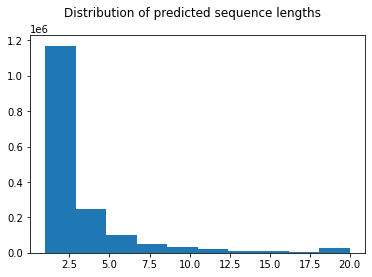

In [ ]:
from matplotlib import pyplot as plt

plt.hist([len(l) for l in labels]);
plt.suptitle('Distribution of predicted sequence lengths');

In [ ]:
# fraction_of_sessions_to_use = 0.000001 # takes about 3 mins to run

# import pandas as pd
# import numpy as np

# train = pd.read_parquet('../input/otto-full-optimized-memory-footprint//train.parquet')
# test = pd.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet')

# sample_sub = pd.read_csv('../input/otto-recommender-system//sample_submission.csv')

# if fraction_of_sessions_to_use != 1:
#     lucky_sessions_train = train.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use, random_state=42)['session']
#     subset_of_train = train[train.session.isin(lucky_sessions_train)]
    
#     lucky_sessions_test = test.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use, random_state=42)['session']
#     subset_of_test = test[test.session.isin(lucky_sessions_test)]
# else:
#     subset_of_train = train
#     subset_of_test = test

# subset_of_train.index = pd.MultiIndex.from_frame(subset_of_train[['session']])
# subset_of_test.index = pd.MultiIndex.from_frame(subset_of_test[['session']])

# chunk_size = 30_000
# min_ts = train.ts.min()
# max_ts = test.ts.max()

# from collections import defaultdict, Counter
# next_AIDs = defaultdict(Counter)

# subsets = pd.concat([subset_of_train, subset_of_test])
# sessions = subsets.session.unique()
# for i in range(0, sessions.shape[0], chunk_size):
#     current_chunk = subsets.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True)
#     current_chunk = current_chunk.groupby('session', as_index=False).nth(list(range(-30,0))).reset_index(drop=True)
#     consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
#     consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
#     consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60)
#     consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed >= 0) & (consecutive_AIDs.days_elapsed <= 1)]
    
#     for aid_x, aid_y in zip(consecutive_AIDs['aid_x'], consecutive_AIDs['aid_y']):
#         next_AIDs[aid_x][aid_y] += 1
    
# del train, subset_of_train, subsets

# session_types = ['clicks', 'carts', 'orders']
# test_session_AIDs = test.reset_index(drop=True).groupby('session')['aid'].apply(list)
# test_session_types = test.reset_index(drop=True).groupby('session')['type'].apply(list)

# labels = []

# no_data = 0
# no_data_all_aids = 0
# type_weight_multipliers = {0: 1, 1: 6, 2: 3}
# for AIDs, types in zip(test_session_AIDs, test_session_types):
#     if len(AIDs) >= 20:
#         weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
#         aids_temp=defaultdict(lambda: 0)
#         for aid,w,t in zip(AIDs,weights,types): 
#             aids_temp[aid]+= w * type_weight_multipliers[t]
            
#         sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
#         labels.append(sorted_aids[:20])
#     else:
#         AIDs = list(dict.fromkeys(AIDs[::-1]))
#         AIDs_len_start = len(AIDs)
        
#         candidates = []
#         for AID in AIDs:
#             if AID in next_AIDs: candidates += [aid for aid, count in next_AIDs[AID].most_common(20)]
#         AIDs += [AID for AID, cnt in Counter(candidates).most_common(40) if AID not in AIDs]
        
#         labels.append(AIDs[:20])
#         if candidates == []: no_data += 1
#         if AIDs_len_start == len(AIDs): no_data_all_aids += 1

# # >>> outputting results to CSV

# labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]

# predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})

In [ ]:
# pp(len(test_session_AIDs.index), len(labels_as_strings))

In [ ]:
# predictions
# prediction_dfs = []

# for st in session_types:
#     modified_predictions = predictions.copy()
#     modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
#     prediction_dfs.append(modified_predictions)

# submission = pd.concat(prediction_dfs).reset_index(drop=True)
# submission.to_csv('submission.csv', index=False)

# print(f'Test sessions that we did not manage to extend based on the co-visitation matrix: {no_data_all_aids}')

## rd: recsys - otto - covisitation simplified - todo: read a post about hyperparam for covisitations https://www.kaggle.com/competitions/otto-recommender-system/discussion/365153